# Norification

TODO:     追加、修正が必要\
FIXME:    既知の不具合があり、修正が必要\
HACK:     リファクタリングが必要\
XXX:      なぜ動作するか分からない\
REVIEW:   意図通りの動作か見直す必要\
OPTIMIZE: 無駄が多く、ボトルネック\
CHANGED:  コードの変更履歴\
NOTE:     なぜそのコードになったかを付記\
WARNING:  注意

# Imports

In [1]:
# standard library imports
import glob
import math
import os
import pathlib
import random
import sys
import warnings

# third party imports
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats
from sklearn import preprocessing

# local imports
import module_anal as analysis

# Initial settings

### warnings

In [16]:
# dfを表示する際の最大行/列数を指定します
# これによってdfが見やすくなります
# pl.options.display.max_rows = 10
# pl.options.display.max_columns = None

# 余計な警告表示をなくしてくれます
warnings.filterwarnings('ignore')

### colors

In [17]:
# Color palette
color_slf  = ['darkslategray', 'mediumseagreen', 'lime']
# color_slf  = ['mediumseagreen' for _ in range(3)]
color_obs  = ['darkblue',      'cornflowerblue', 'cyan']
# color_obs  = ['cornflowerblue' for _ in range(3)] 
color_test = ['maroon',        'orange',         'gold']
# color_test  = ['orange' for _ in range(3)]
colors = [color_slf[1], color_obs[1], color_test[1]]

### subjects

In [18]:
subj_files = glob.glob('/Users/strix_uralensis/Documents/Experiment/analysis/data_backup/*')
subj_files.sort()
subj_num = len(subj_files)//2

### labels

In [19]:
cols = ['game_No', 'seq_No',
        'block', 'seq_pattern','loc_pattern',
        'loc_left', 'loc_right', 'sd', 'pt', 'conf', 'reward',
        't_choice', 't_conf', 'idx_left', 'idx_right',
        'img_choice', 'img_correct', 'loc_choice',
        't_choice_pres', 't_choice_resp',
        't_conf_pres',   't_conf_resp',
        't_reward_pres', 't_reward_resp']

seq_label = ['slf', 'obs', 'test']
pair_label = ['30/40', '40/50', '50/30']

# Load Data 

In [20]:
class Individual:
    """各被験者ごとのdfを取得するためのクラス
    """
    def __init__(self, subj_file, seq_label, si):
        self.subj_file = subj_file
        self.seq_label = seq_label
        self.si  = si
        self.group_num = 1 if self.si%2==1 else 2
        
        self.slf1  = load_data(self.subj_file[0], self.seq_label[0], self.si, pat_num=1, group_num=self.group_num)
        self.obs1  = load_data(self.subj_file[0], self.seq_label[1], self.si, pat_num=1, group_num=self.group_num)
        self.test1 = load_data(self.subj_file[0], self.seq_label[2], self.si, pat_num=1, group_num=self.group_num)
        self.slf2  = load_data(self.subj_file[1], self.seq_label[0], self.si, pat_num=2, group_num=self.group_num)
        self.obs2  = load_data(self.subj_file[1], self.seq_label[1], self.si, pat_num=2, group_num=self.group_num)
        self.test2 = load_data(self.subj_file[1], self.seq_label[2], self.si, pat_num=2, group_num=self.group_num)


# HACK: pl.cloneで書き直す
class Integrated:
    """全被験者の結果を結合したdfを取得するためのクラス
    """
    def __init__(self, subj_files, seq_label, subj_num):
        self.subj_files = subj_files
        self.seq_label = seq_label
        self.subj_num  = subj_num
        
        self.slf1  = load_data(self.subj_files[0], self.seq_label[0], 1, pat_num=1, group_num=1)
        self.obs1  = load_data(self.subj_files[0], self.seq_label[1], 1, pat_num=1, group_num=1)
        self.test1 = load_data(self.subj_files[0], self.seq_label[2], 1, pat_num=1, group_num=1)
        self.slf2  = load_data(self.subj_files[1], self.seq_label[0], 1, pat_num=2, group_num=1)
        self.obs2  = load_data(self.subj_files[1], self.seq_label[1], 1, pat_num=2, group_num=1)
        self.test2 = load_data(self.subj_files[1], self.seq_label[2], 1, pat_num=2, group_num=1)
        
        for si in range(1, self.subj_num):
            add_subj  = Individual([self.subj_files[2*si], self.subj_files[2*si+1]], self.seq_label, -~si)
            
            self.slf1  = pl.concat([self.slf1, add_subj.slf1], how='diagonal')
            self.obs1  = pl.concat([self.obs1, add_subj.obs1], how='diagonal')
            self.test1 = pl.concat([self.test1, add_subj.test1], how='diagonal')
            self.slf2  = pl.concat([self.slf2, add_subj.slf2], how='diagonal')
            self.obs2  = pl.concat([self.obs2, add_subj.obs2], how='diagonal')
            self.test2 = pl.concat([self.test2, add_subj.test2], how='diagonal')


# 出力は[df_slf(36x31), df_obs(36x31), df_test(90x31)]
def load_data(file_name, seq_label, si, pat_num, group_num):
    """被験者の結果が格納された.xlsxファイルを読み込んでdfを取得する

    Args:
        file_name (str): ファイルのパス
        seq_label (str): 読み込むデータのシーケンス (slf、obs、test)
        si (int): 被験者番号 (1 - 15)
        pat_num (int): 読み込むデータのパターン (1 or 2)
        group_num (int): 被験者のグループ (1 or 2)

    Returns:
        DataFrame: .xlsxファイルを読み込んで得られたdf
    """
    df = pl.read_excel(
            file_name,
            sheet_name=seq_label+str(pat_num),
            read_csv_options={'has_header': False, 'new_columns': cols}
            )
    df = df.with_columns(pl.lit(si).alias('subj_No'), pl.lit(seq_label).alias('type'), pl.lit(group_num).alias('group'))

    return df


# individual[被験者番号(1〜15)]とすることで、該当番号の被験者のインスタンスを取得できる
# slf、obs、testの後ろにパターンの1、2をつけることで当該dfを取得できる
# ex) individual[1].slf1　: 被験者1のパターン1におけるselfシーケンスの結果
individual  = [[]]

for si in range(subj_num):
    subj_file = [subj_files[2*si], subj_files[2*si+1]]
    individual.append(Individual(subj_file, seq_label, -~si))

# 全ての被験者の結果を結合したインスタンス
# individual同様に、slf、obs、testの後ろにパターンの1、2をつけることで当該dfを取得できる
integrated = Integrated(subj_files, seq_label, subj_num)

In [30]:
individual[1].slf1

game_No,seq_No,block,seq_pattern,loc_pattern,loc_left,loc_right,sd,pt,conf,reward,t_choice,t_conf,idx_left,idx_right,img_choice,img_correct,loc_choice,t_choice_pres,t_choice_resp,t_conf_pres,t_conf_resp,t_reward_pres,t_reward_resp,subj_No,type,group
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,i32,str,i32
1,1,1,0,2,50,40,10,1,7,56.696738,2.116,0.575,3,2,1,1,50,5.529,7.645,8.719,9.295,10.318,12.328,1,"""slf""",1
2,2,1,0,1,40,30,10,1,7,39.446779,1.444,0.6,2,1,1,1,40,12.852,14.295,15.311,15.911,16.929,18.935,1,"""slf""",1
3,3,1,0,3,30,50,10,0,7,24.337548,0.743,0.566,1,3,1,2,30,19.457,20.2,21.212,21.777,22.795,24.794,1,"""slf""",1
4,4,1,0,2,40,50,10,1,9,32.518189,1.318,0.532,2,3,2,2,50,25.317,26.635,27.645,28.177,29.202,31.201,1,"""slf""",1
5,5,1,0,1,30,40,10,1,7,31.40703,1.109,1.233,1,2,2,2,40,31.726,32.835,33.845,35.078,36.1,38.1,1,"""slf""",1
6,6,1,0,3,50,30,10,0,7,17.652333,1.584,0.505,3,1,2,1,30,38.627,40.211,41.229,41.734,42.756,44.761,1,"""slf""",1
7,7,1,0,2,50,40,10,1,7,49.341833,0.879,0.599,3,2,1,1,50,45.29,46.169,47.178,47.777,48.805,50.811,1,"""slf""",1
8,8,1,0,1,40,30,10,1,7,42.135556,1.172,0.323,2,1,1,1,40,51.34,52.513,53.529,53.852,54.875,56.878,1,"""slf""",1
9,9,1,0,3,30,50,10,1,9,60.831591,0.925,0.449,1,3,2,2,50,57.409,58.334,59.346,59.794,60.833,62.834,1,"""slf""",1


In [16]:

# loc_left_exp_key, loc_right_exp_key, img_correct_exp_key, pt_exp_key\
#     = 'loc_left_exp', 'loc_right_exp', 'img_correct_exp', 'pt_exp'

# 主にグラフのラベル用のリストです
xlim_slf, xlim_obs, xlim_test    = 36, 36, 90
xstep_slf, xstep_obs, xstep_test = 12, 12, 30
ylim_img, ylim_conf = 5.0, 3.0
num_list     = [1, 2, 3]
loc_list     = [30, 40, 50]
seq_label1   = ['Self', 'Observation', 'Test']
seq_label2   = ['Observation', 'Self', 'Test']
type_label   = ['slf', 'obs', 'test']
choice_label = ['S_choice', 'O_choice', 'T_choice']
conf_label   = ['S_conf', 'O_conf', 'T_conf']
block_label  = ['_1st', '_2nd', '_3rd']
S_seq_label  = ['S' + i for i in block_label]
O_seq_label  = ['O' + i for i in block_label]
T_seq_label  = ['T' + i for i in block_label]

img_prefix = 'img/'
img_suffix = '.png'


# Reaction Time

### through tha Game

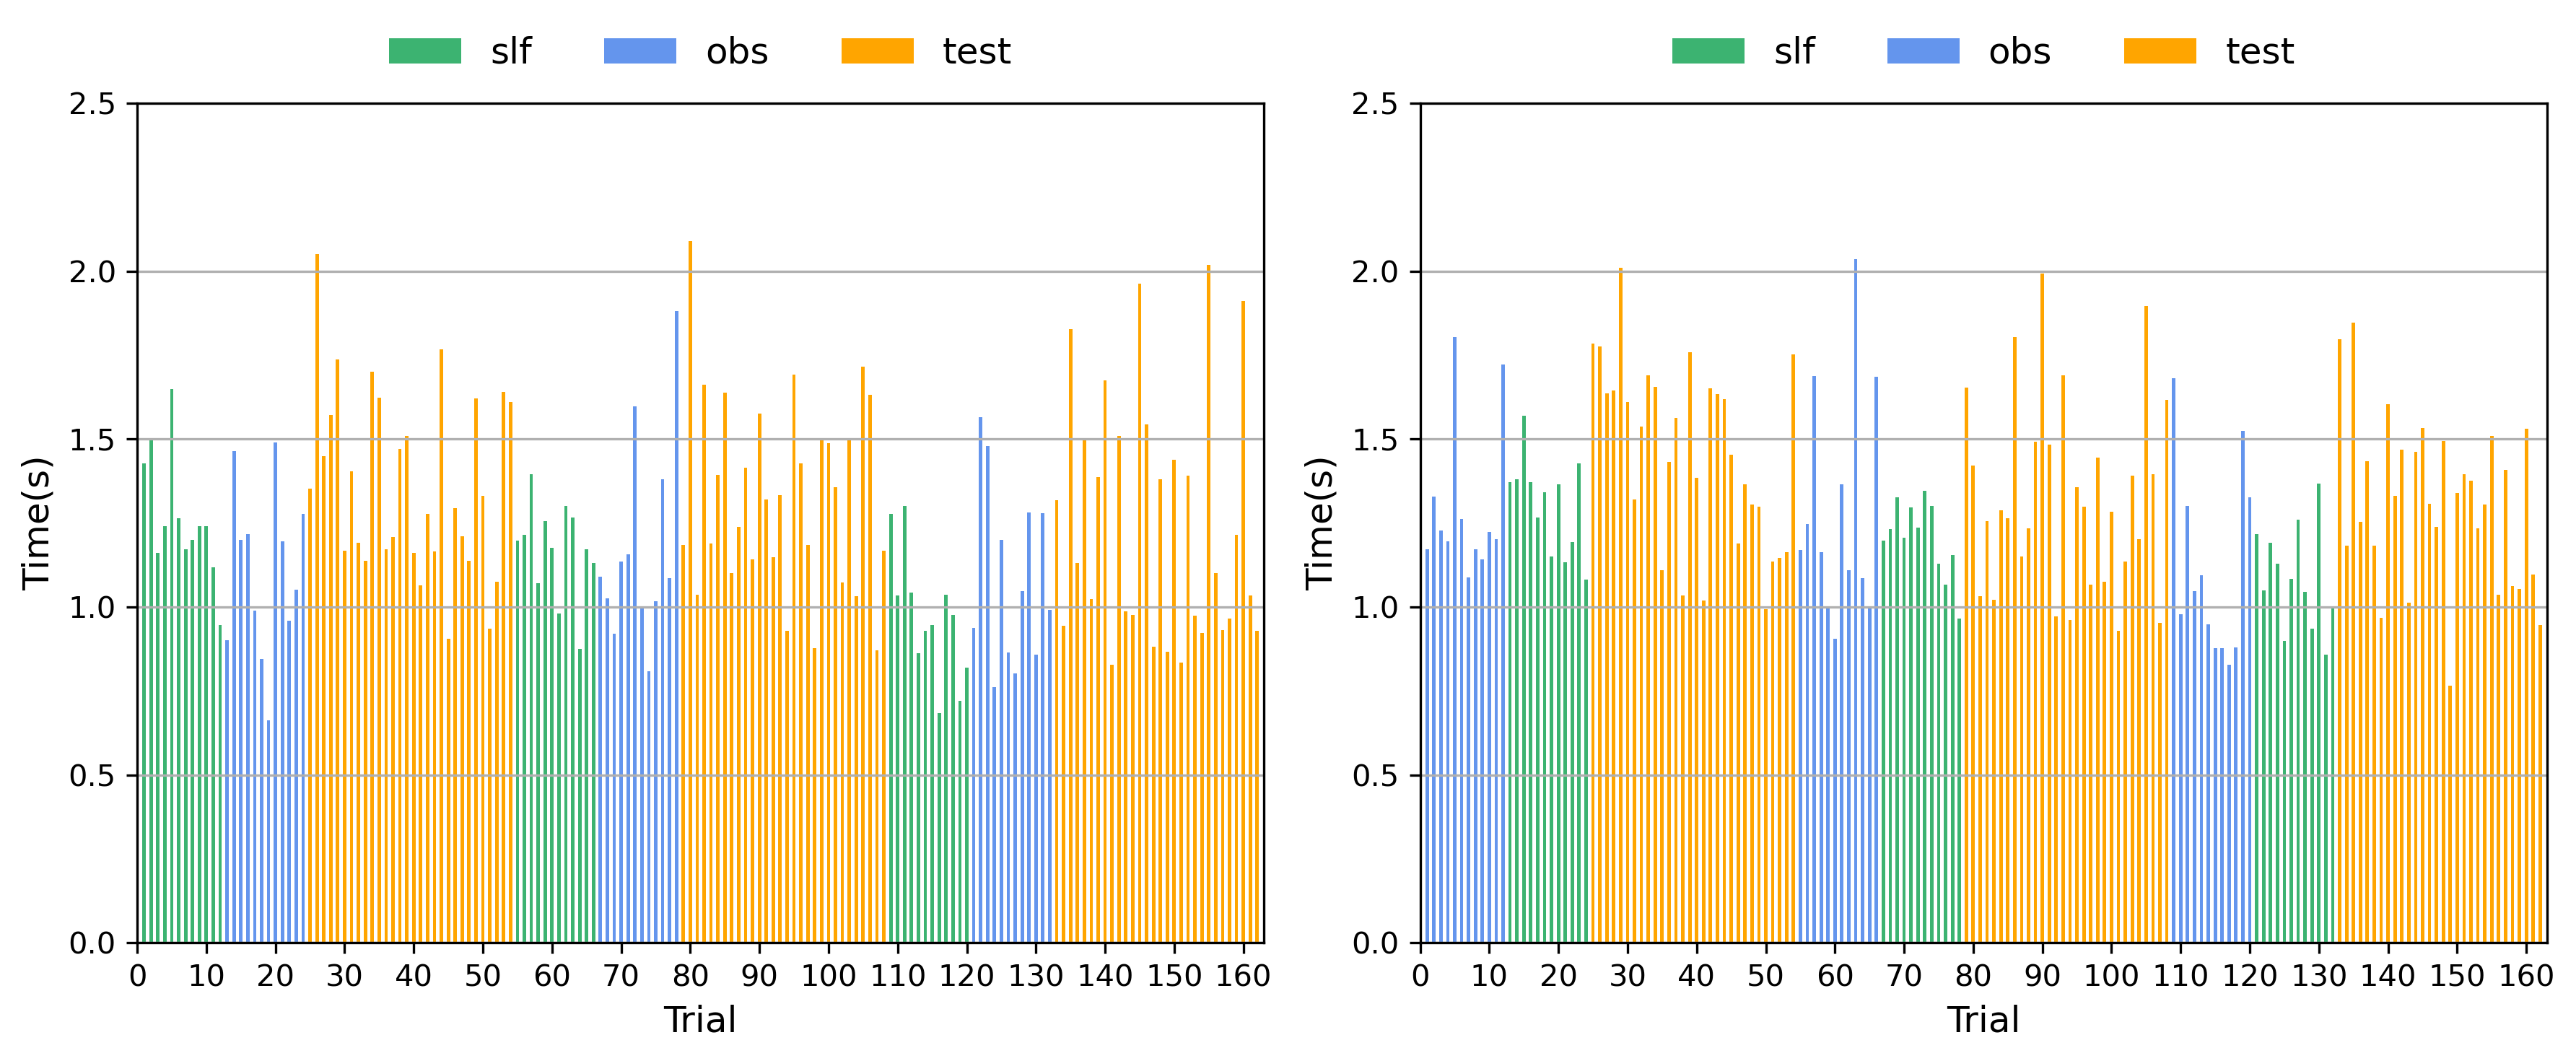

In [18]:
def rt_through_game(ax, df, seq, color):
    df = df.select(pl.col('game_No', 't_choice')).groupby('game_No').mean().sort(by='game_No')
    
    ax.bar(df.get_column('game_No'),
            df.get_column('t_choice'),
            label=seq,
            width=.5,
            color=color
            )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300, tight_layout=True, sharey=False)
rt_through_game(ax[0], integrated.slf1, seq_label[0], colors[0])
rt_through_game(ax[0], integrated.obs1, seq_label[1], colors[1])
rt_through_game(ax[0], integrated.test1, seq_label[2], colors[2])

rt_through_game(ax[1], integrated.slf2, seq_label[0], colors[0])
rt_through_game(ax[1], integrated.obs2, seq_label[1], colors[1])
rt_through_game(ax[1], integrated.test2, seq_label[2], colors[2])

xlim = 162
ylim = 2.5

for axis in ax:
    axis.set_xlim(0, -~xlim)
    axis.set_ylim(0, ylim)
    axis.set_xticks(np.arange(0, 165, step=10))
    axis.set_yticks(np.arange(0, ylim+.1, .5))
    axis.set_xlabel('Trial', fontsize=12)
    axis.set_ylabel('Time(s)', fontsize=12)

    axis.grid(axis='y')
    axis.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)

### Each Sequence (Slf: 36 trials, Obs: 36 trials, Test: 90 trials)

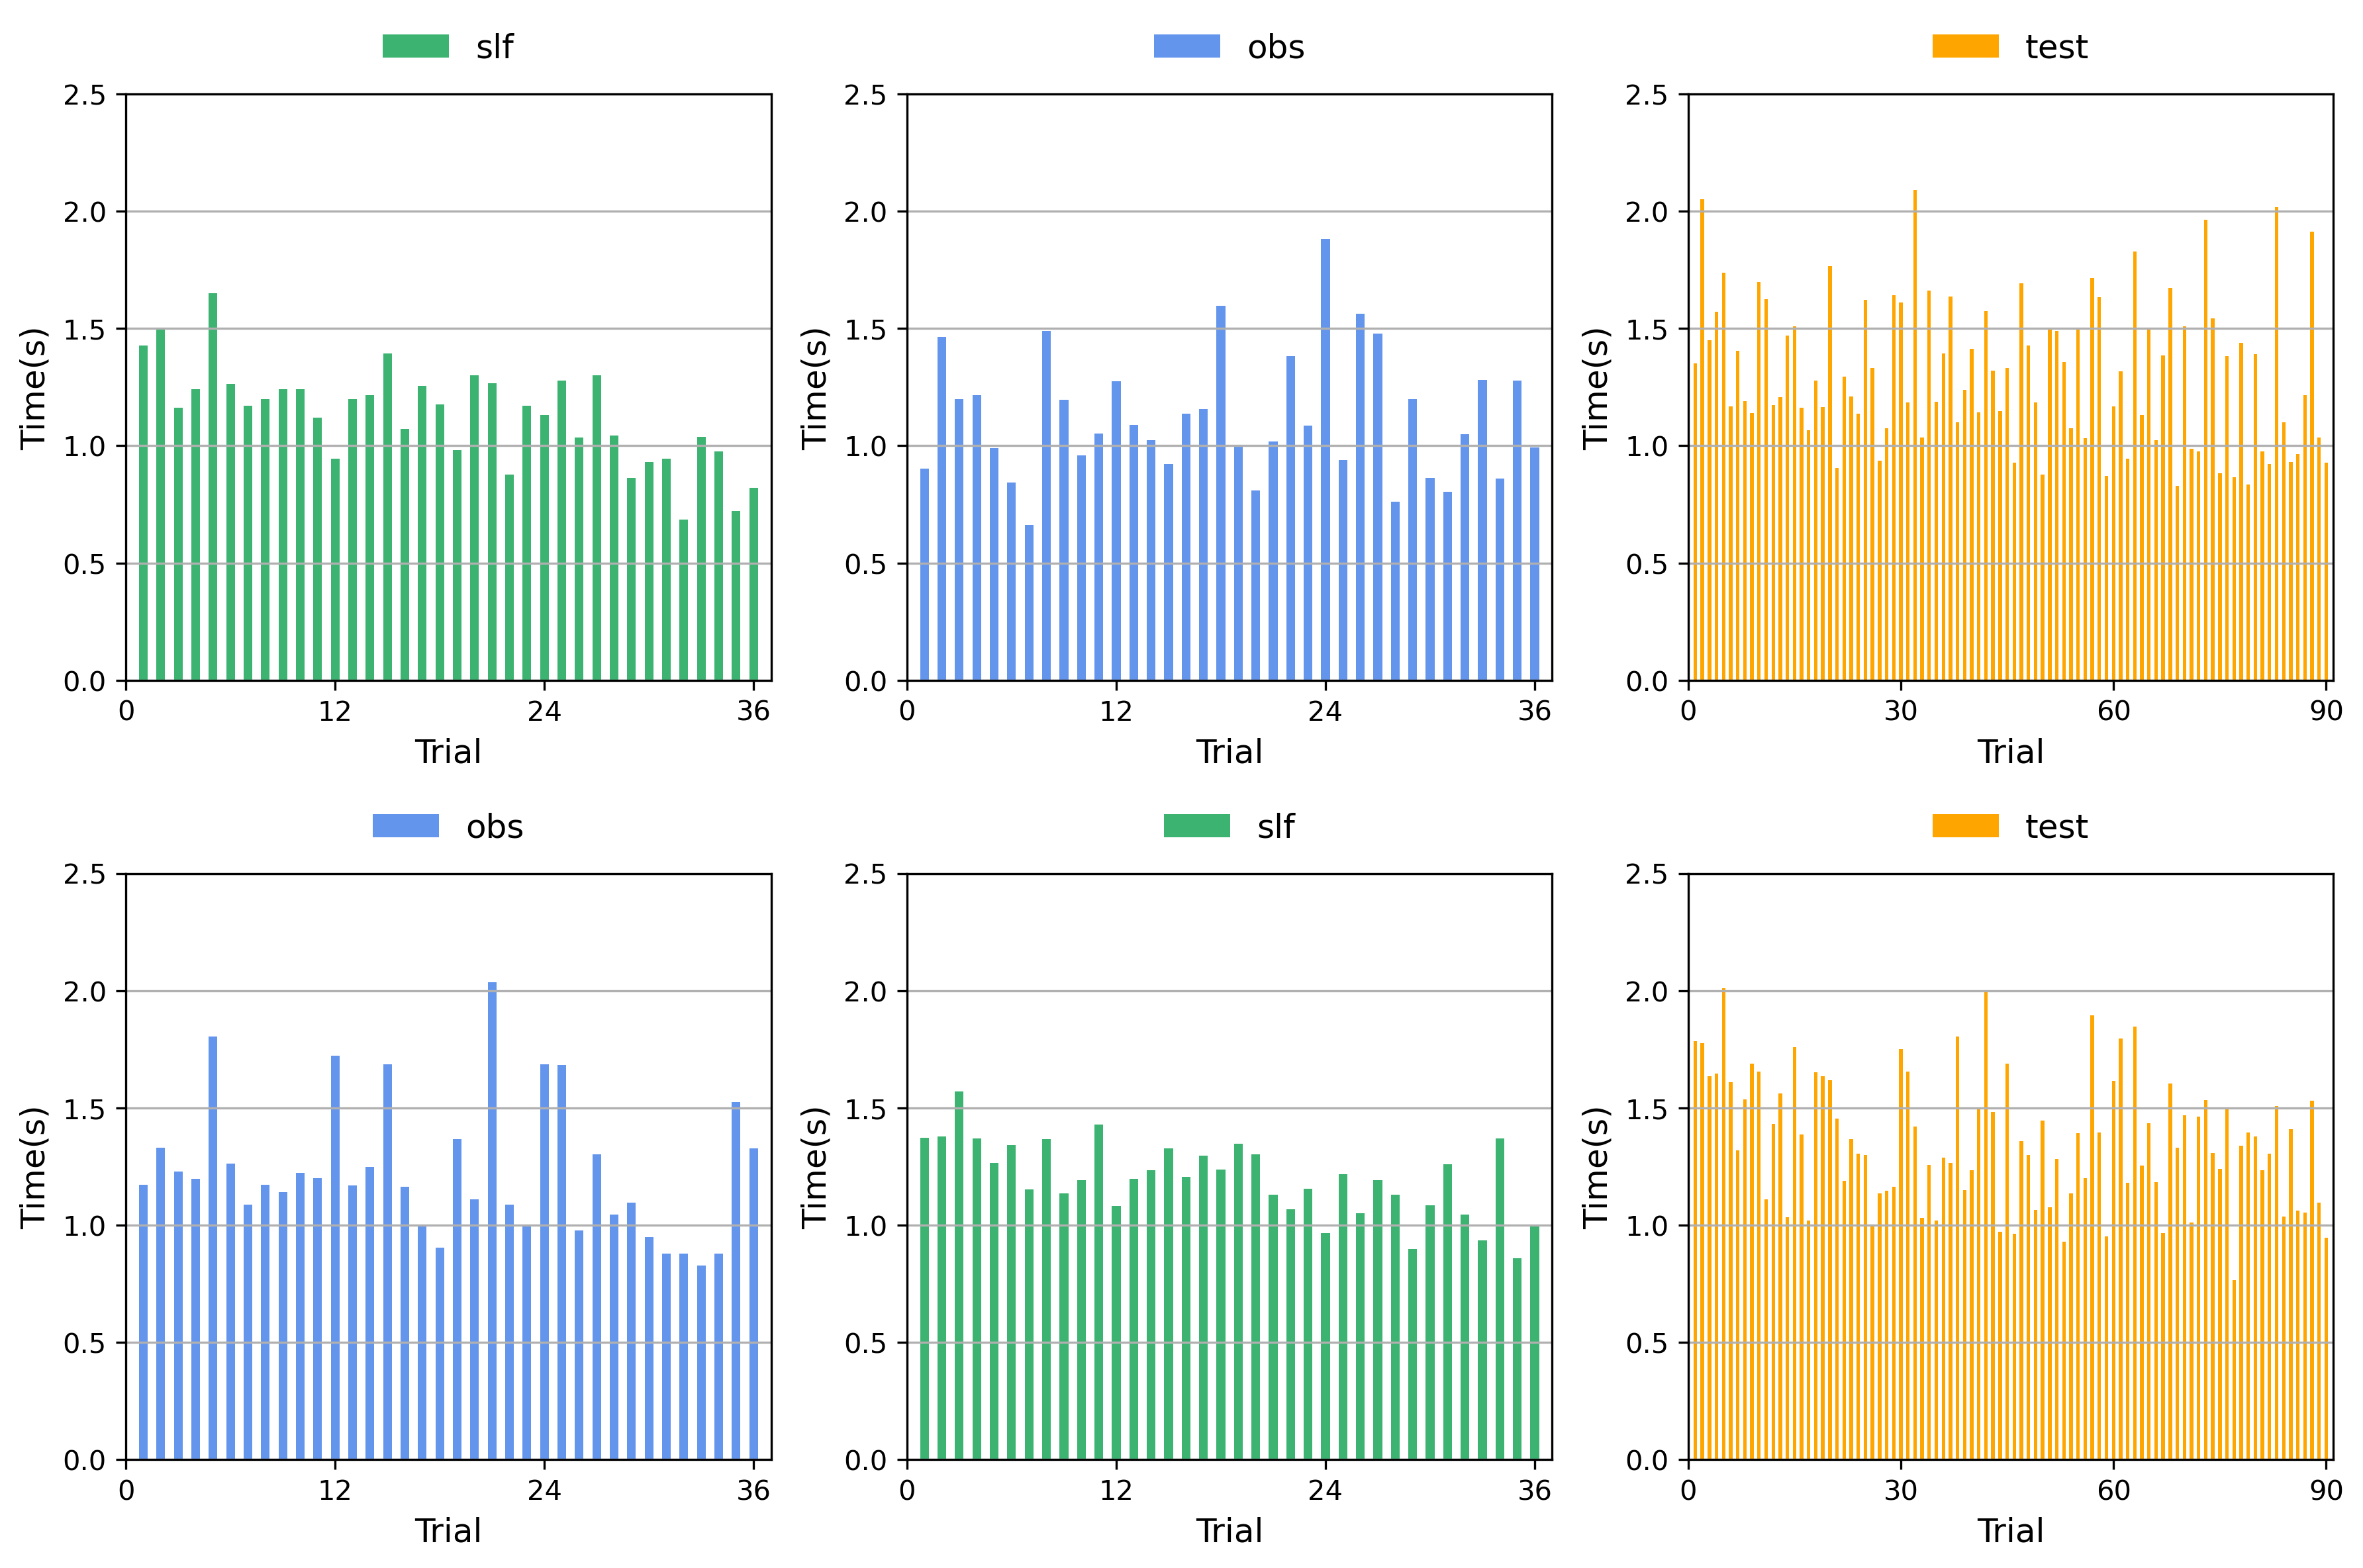

In [19]:
def rt_each_seq(ax, df, seq, color, xlim, ylim):
    df = df.select(pl.col('seq_No', 't_choice')).groupby('seq_No').mean().sort(by='seq_No')
    
    ax.bar(df.get_column('seq_No'),
            df.get_column('t_choice'),
            label=seq,
            width=.5,
            color=color
            )
    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=xlim//3))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Trial', fontsize=12)
    ax.set_ylabel('Time(s)', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)
xlim_so = 36
xlim_t = 90
ylim = 2.5

rt_each_seq(ax[0][0], integrated.slf1, seq_label[0], colors[0], xlim_so, ylim)
rt_each_seq(ax[0][1], integrated.obs1, seq_label[1], colors[1], xlim_so, ylim)
rt_each_seq(ax[0][2], integrated.test1, seq_label[2], colors[2], xlim_t, ylim)

rt_each_seq(ax[1][1], integrated.slf2, seq_label[0], colors[0], xlim_so, ylim)
rt_each_seq(ax[1][0], integrated.obs2, seq_label[1], colors[1], xlim_so, ylim)
rt_each_seq(ax[1][2], integrated.test2, seq_label[2], colors[2], xlim_t, ylim)

### Each Pair

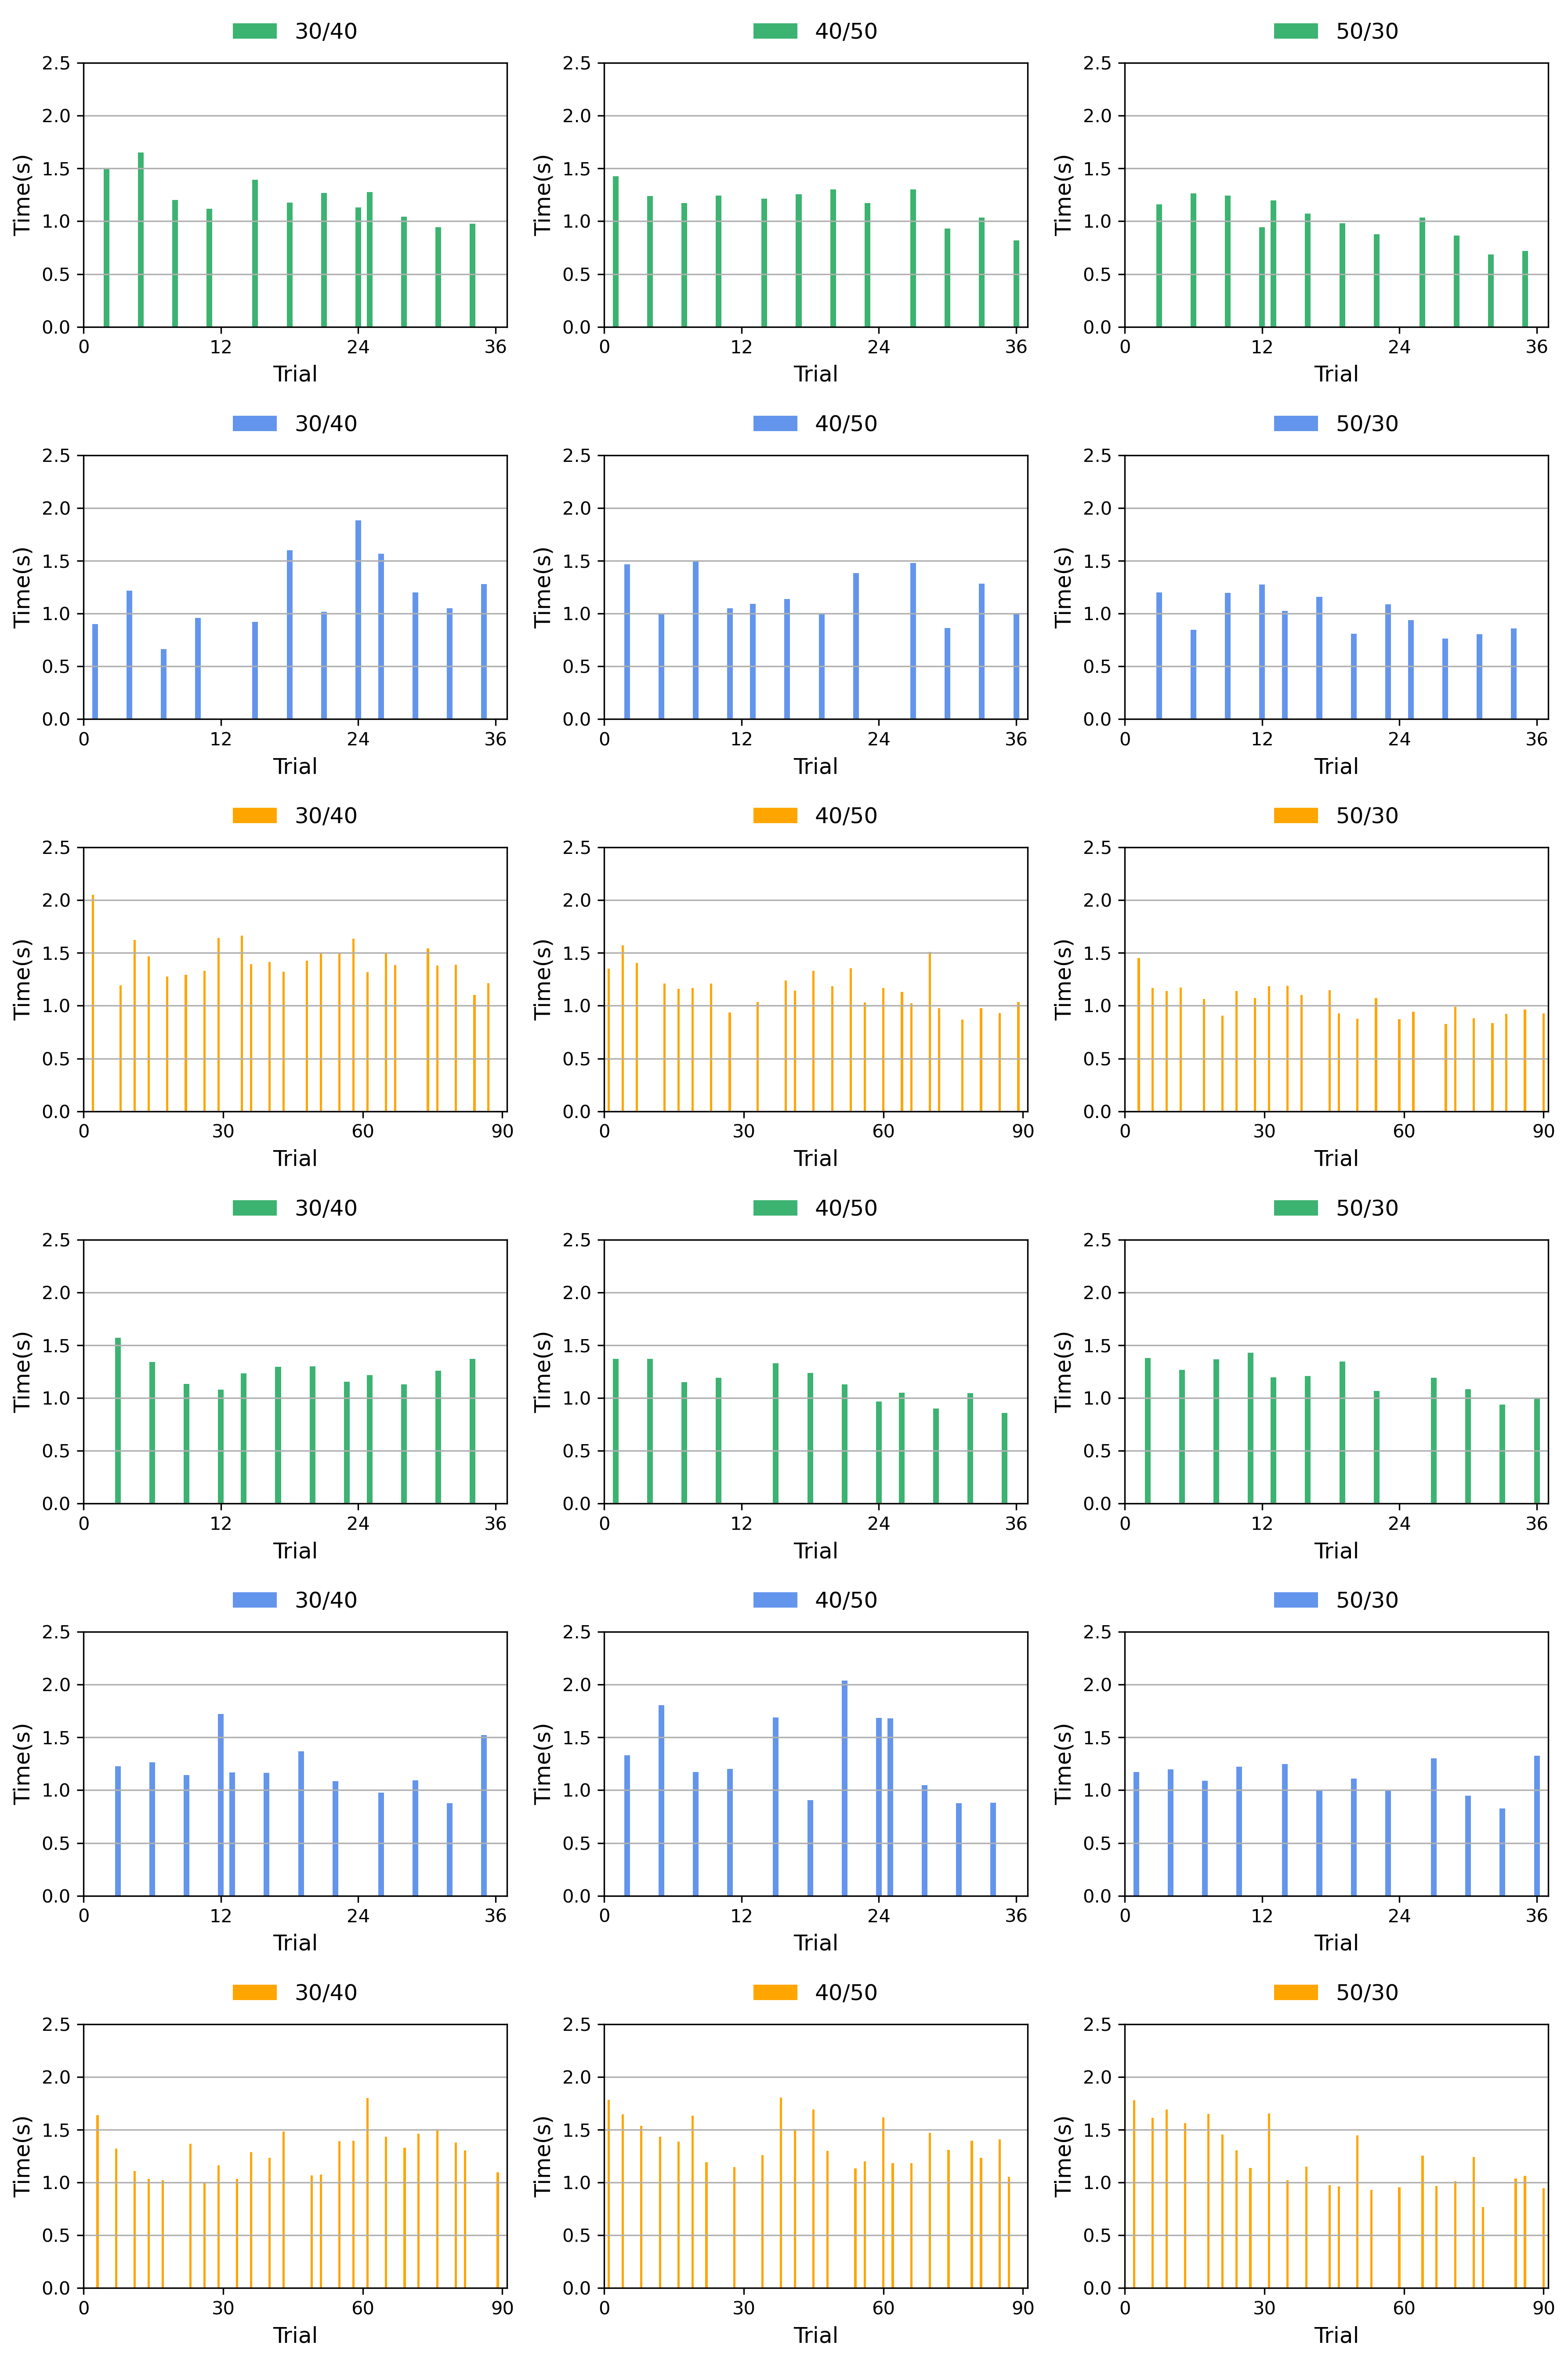

In [20]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12, 18), dpi=300, tight_layout=True, sharey=False)
xlim_so = 36
xlim_t = 90
ylim = 2.5

rt_each_seq(ax[0][0], integrated.slf1.filter(pl.col('loc_pattern')==1), pair_label[0], colors[0], xlim_so, ylim)
rt_each_seq(ax[0][1], integrated.slf1.filter(pl.col('loc_pattern')==2), pair_label[1], colors[0], xlim_so, ylim)
rt_each_seq(ax[0][2], integrated.slf1.filter(pl.col('loc_pattern')==3), pair_label[2], colors[0], xlim_so, ylim)

rt_each_seq(ax[1][0], integrated.obs1.filter(pl.col('loc_pattern')==1), pair_label[0], colors[1], xlim_so, ylim)
rt_each_seq(ax[1][1], integrated.obs1.filter(pl.col('loc_pattern')==2), pair_label[1], colors[1], xlim_so, ylim)
rt_each_seq(ax[1][2], integrated.obs1.filter(pl.col('loc_pattern')==3), pair_label[2], colors[1], xlim_so, ylim)

rt_each_seq(ax[2][0], integrated.test1.filter(pl.col('loc_pattern')==1), pair_label[0], colors[2], xlim_t, ylim)
rt_each_seq(ax[2][1], integrated.test1.filter(pl.col('loc_pattern')==2), pair_label[1], colors[2], xlim_t, ylim)
rt_each_seq(ax[2][2], integrated.test1.filter(pl.col('loc_pattern')==3), pair_label[2], colors[2], xlim_t, ylim)

rt_each_seq(ax[3][0], integrated.slf2.filter(pl.col('loc_pattern')==1), pair_label[0], colors[0], xlim_so, ylim)
rt_each_seq(ax[3][1], integrated.slf2.filter(pl.col('loc_pattern')==2), pair_label[1], colors[0], xlim_so, ylim)
rt_each_seq(ax[3][2], integrated.slf2.filter(pl.col('loc_pattern')==3), pair_label[2], colors[0], xlim_so, ylim)

rt_each_seq(ax[4][0], integrated.obs2.filter(pl.col('loc_pattern')==1), pair_label[0], colors[1], xlim_so, ylim)
rt_each_seq(ax[4][1], integrated.obs2.filter(pl.col('loc_pattern')==2), pair_label[1], colors[1], xlim_so, ylim)
rt_each_seq(ax[4][2], integrated.obs2.filter(pl.col('loc_pattern')==3), pair_label[2], colors[1], xlim_so, ylim)

rt_each_seq(ax[5][0], integrated.test2.filter(pl.col('loc_pattern')==1), pair_label[0], colors[2], xlim_t, ylim)
rt_each_seq(ax[5][1], integrated.test2.filter(pl.col('loc_pattern')==2), pair_label[1], colors[2], xlim_t, ylim)
rt_each_seq(ax[5][2], integrated.test2.filter(pl.col('loc_pattern')==3), pair_label[2], colors[2], xlim_t, ylim)

# Confidence

### Each Block

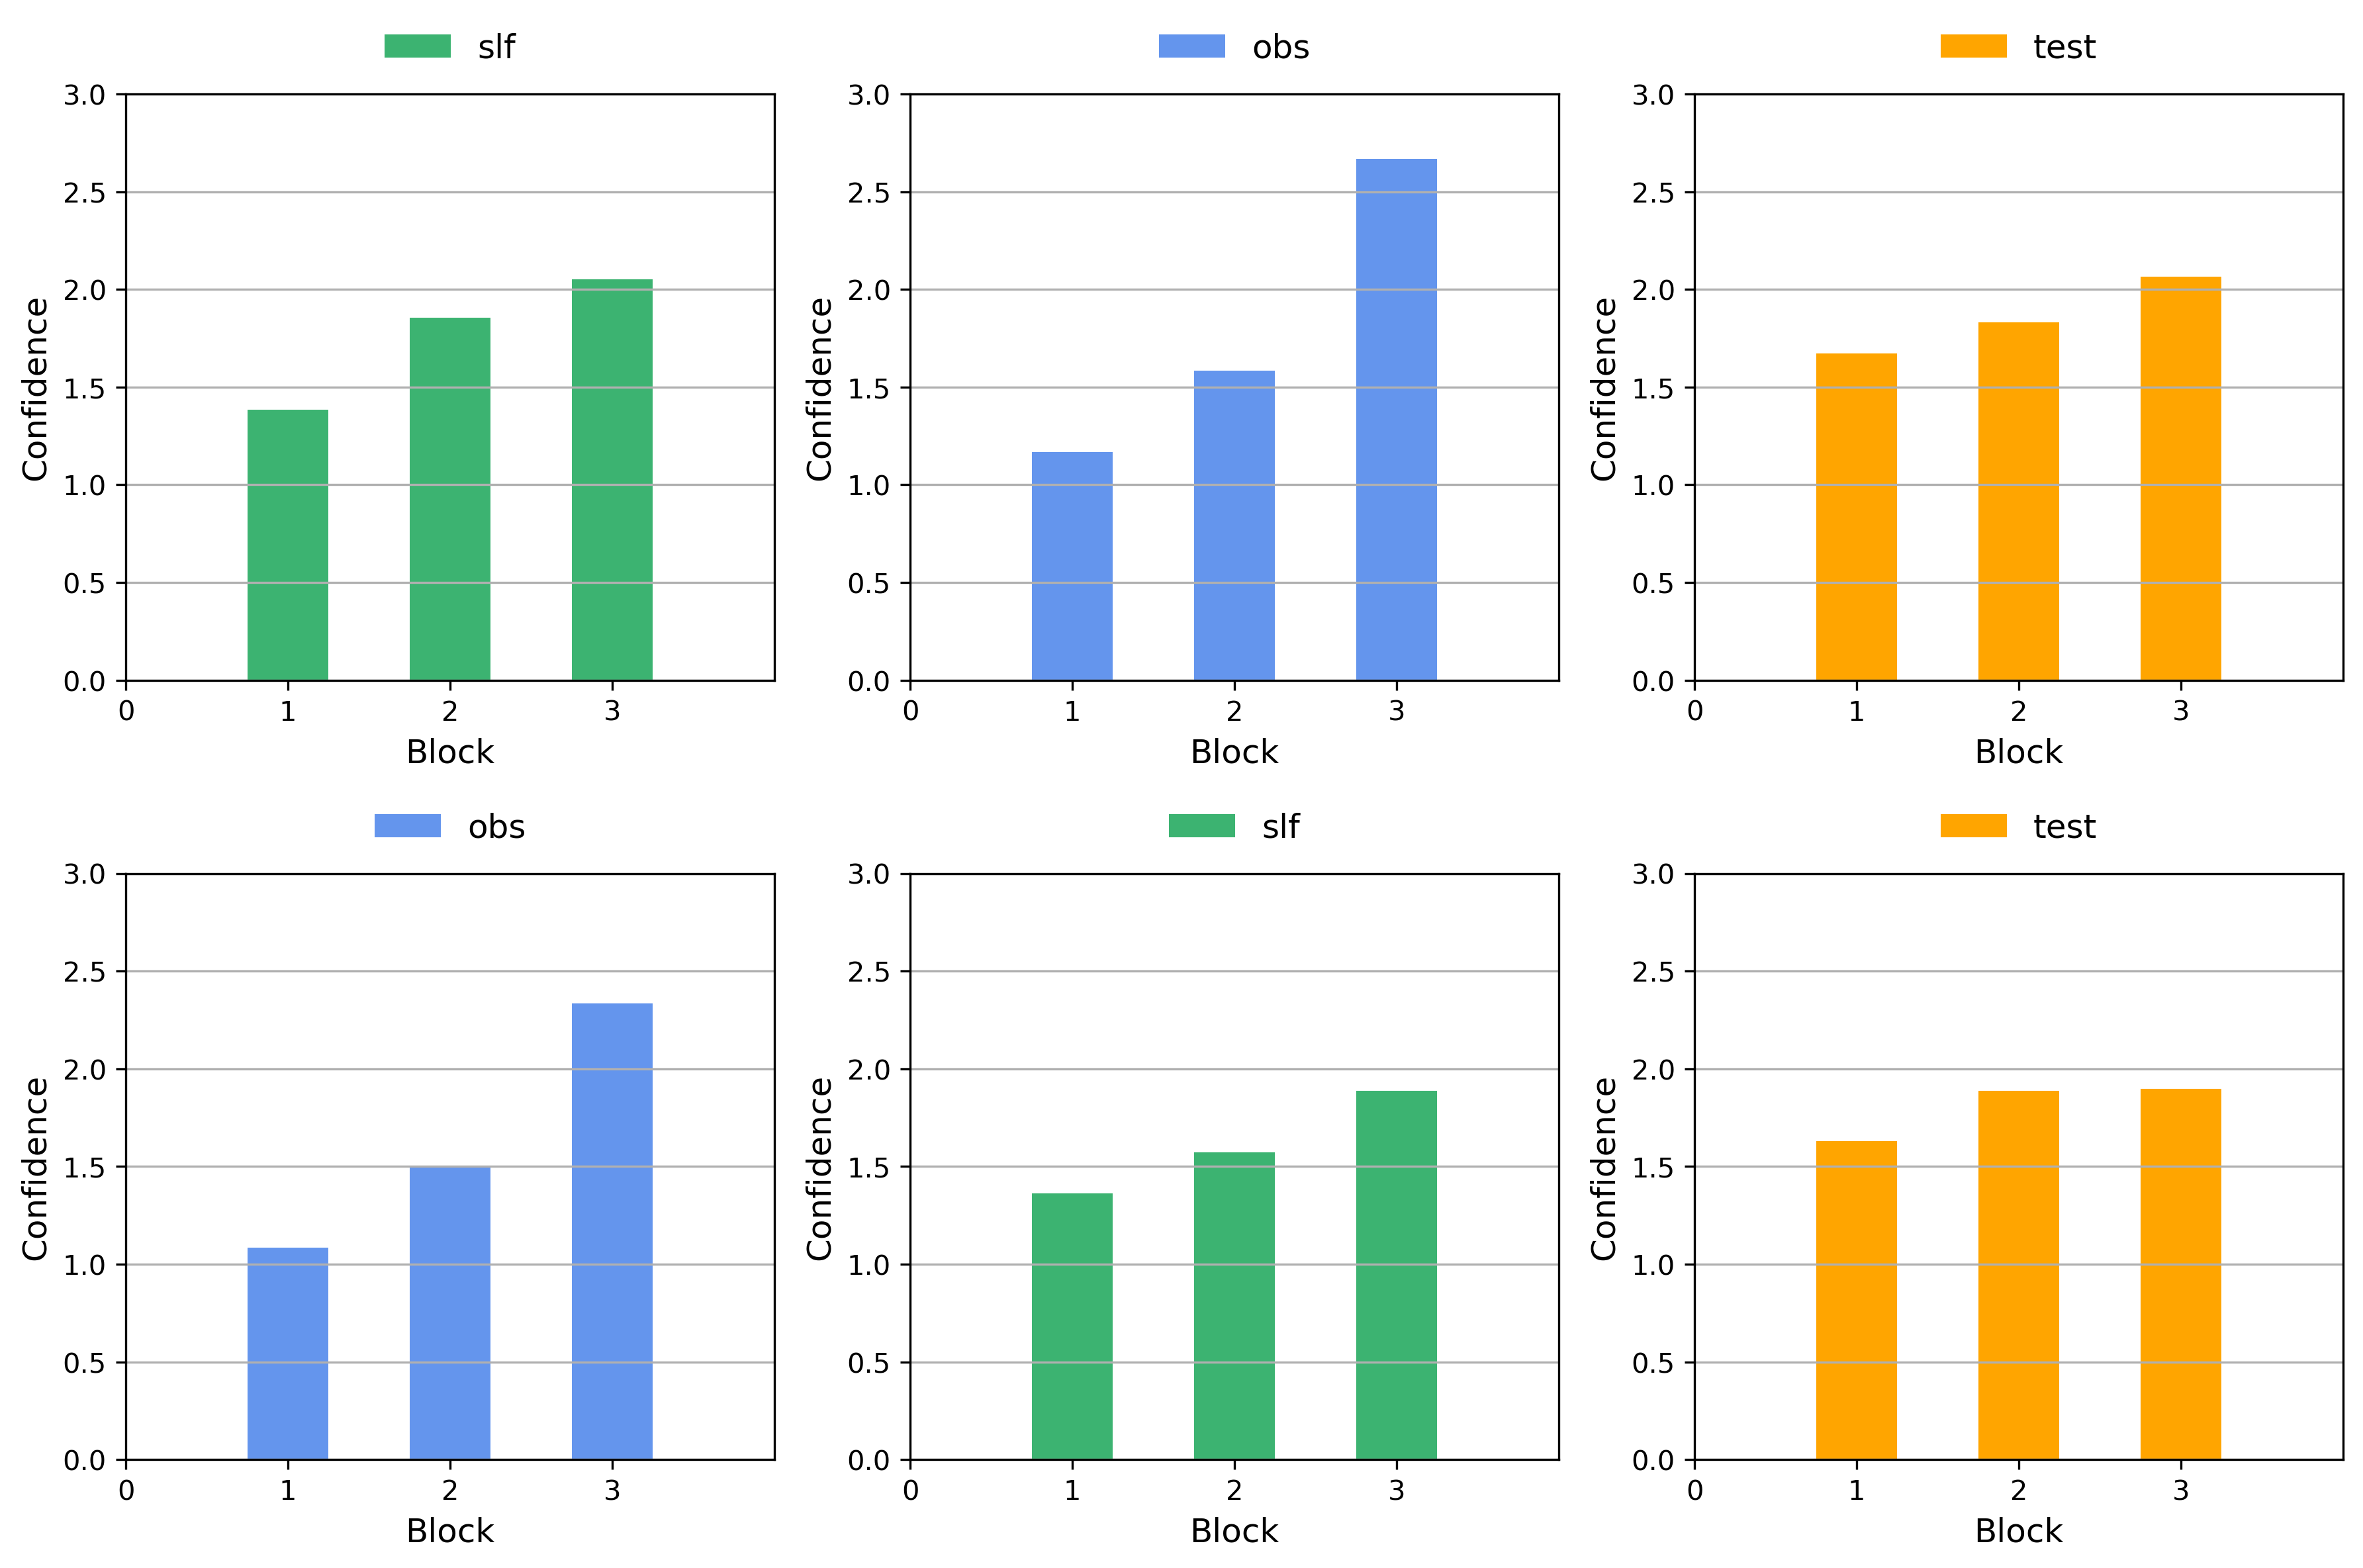

In [21]:
def conf_each_block(ax, df, seq, width, color, xlim, ylim):
    df = df.select(pl.col('block', 'conf')).groupby('block').mean().sort(by='block').with_columns(pl.col('conf')-6)

    ax.bar(df.get_column('block'),
            df.get_column('conf'),
            label=seq,
            width=width,
            color=color
            )
    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Block', fontsize=12)
    ax.set_ylabel('Confidence', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

width = .5

xlim_so = 3
xlim_t = 3
ylim = 3

conf_each_block(ax[0][0], integrated.slf1, seq_label[0], width, colors[0], xlim_so, ylim)
conf_each_block(ax[0][1], integrated.obs1, seq_label[1], width, colors[1], xlim_so, ylim)
conf_each_block(ax[0][2], integrated.test1, seq_label[2], width, colors[2], xlim_t, ylim)

conf_each_block(ax[1][1], integrated.slf2, seq_label[0], width, colors[0], xlim_so, ylim)
conf_each_block(ax[1][0], integrated.obs2, seq_label[1], width, colors[1], xlim_so, ylim)
conf_each_block(ax[1][2], integrated.test2, seq_label[2], width, colors[2], xlim_t, ylim)

### Each Pair

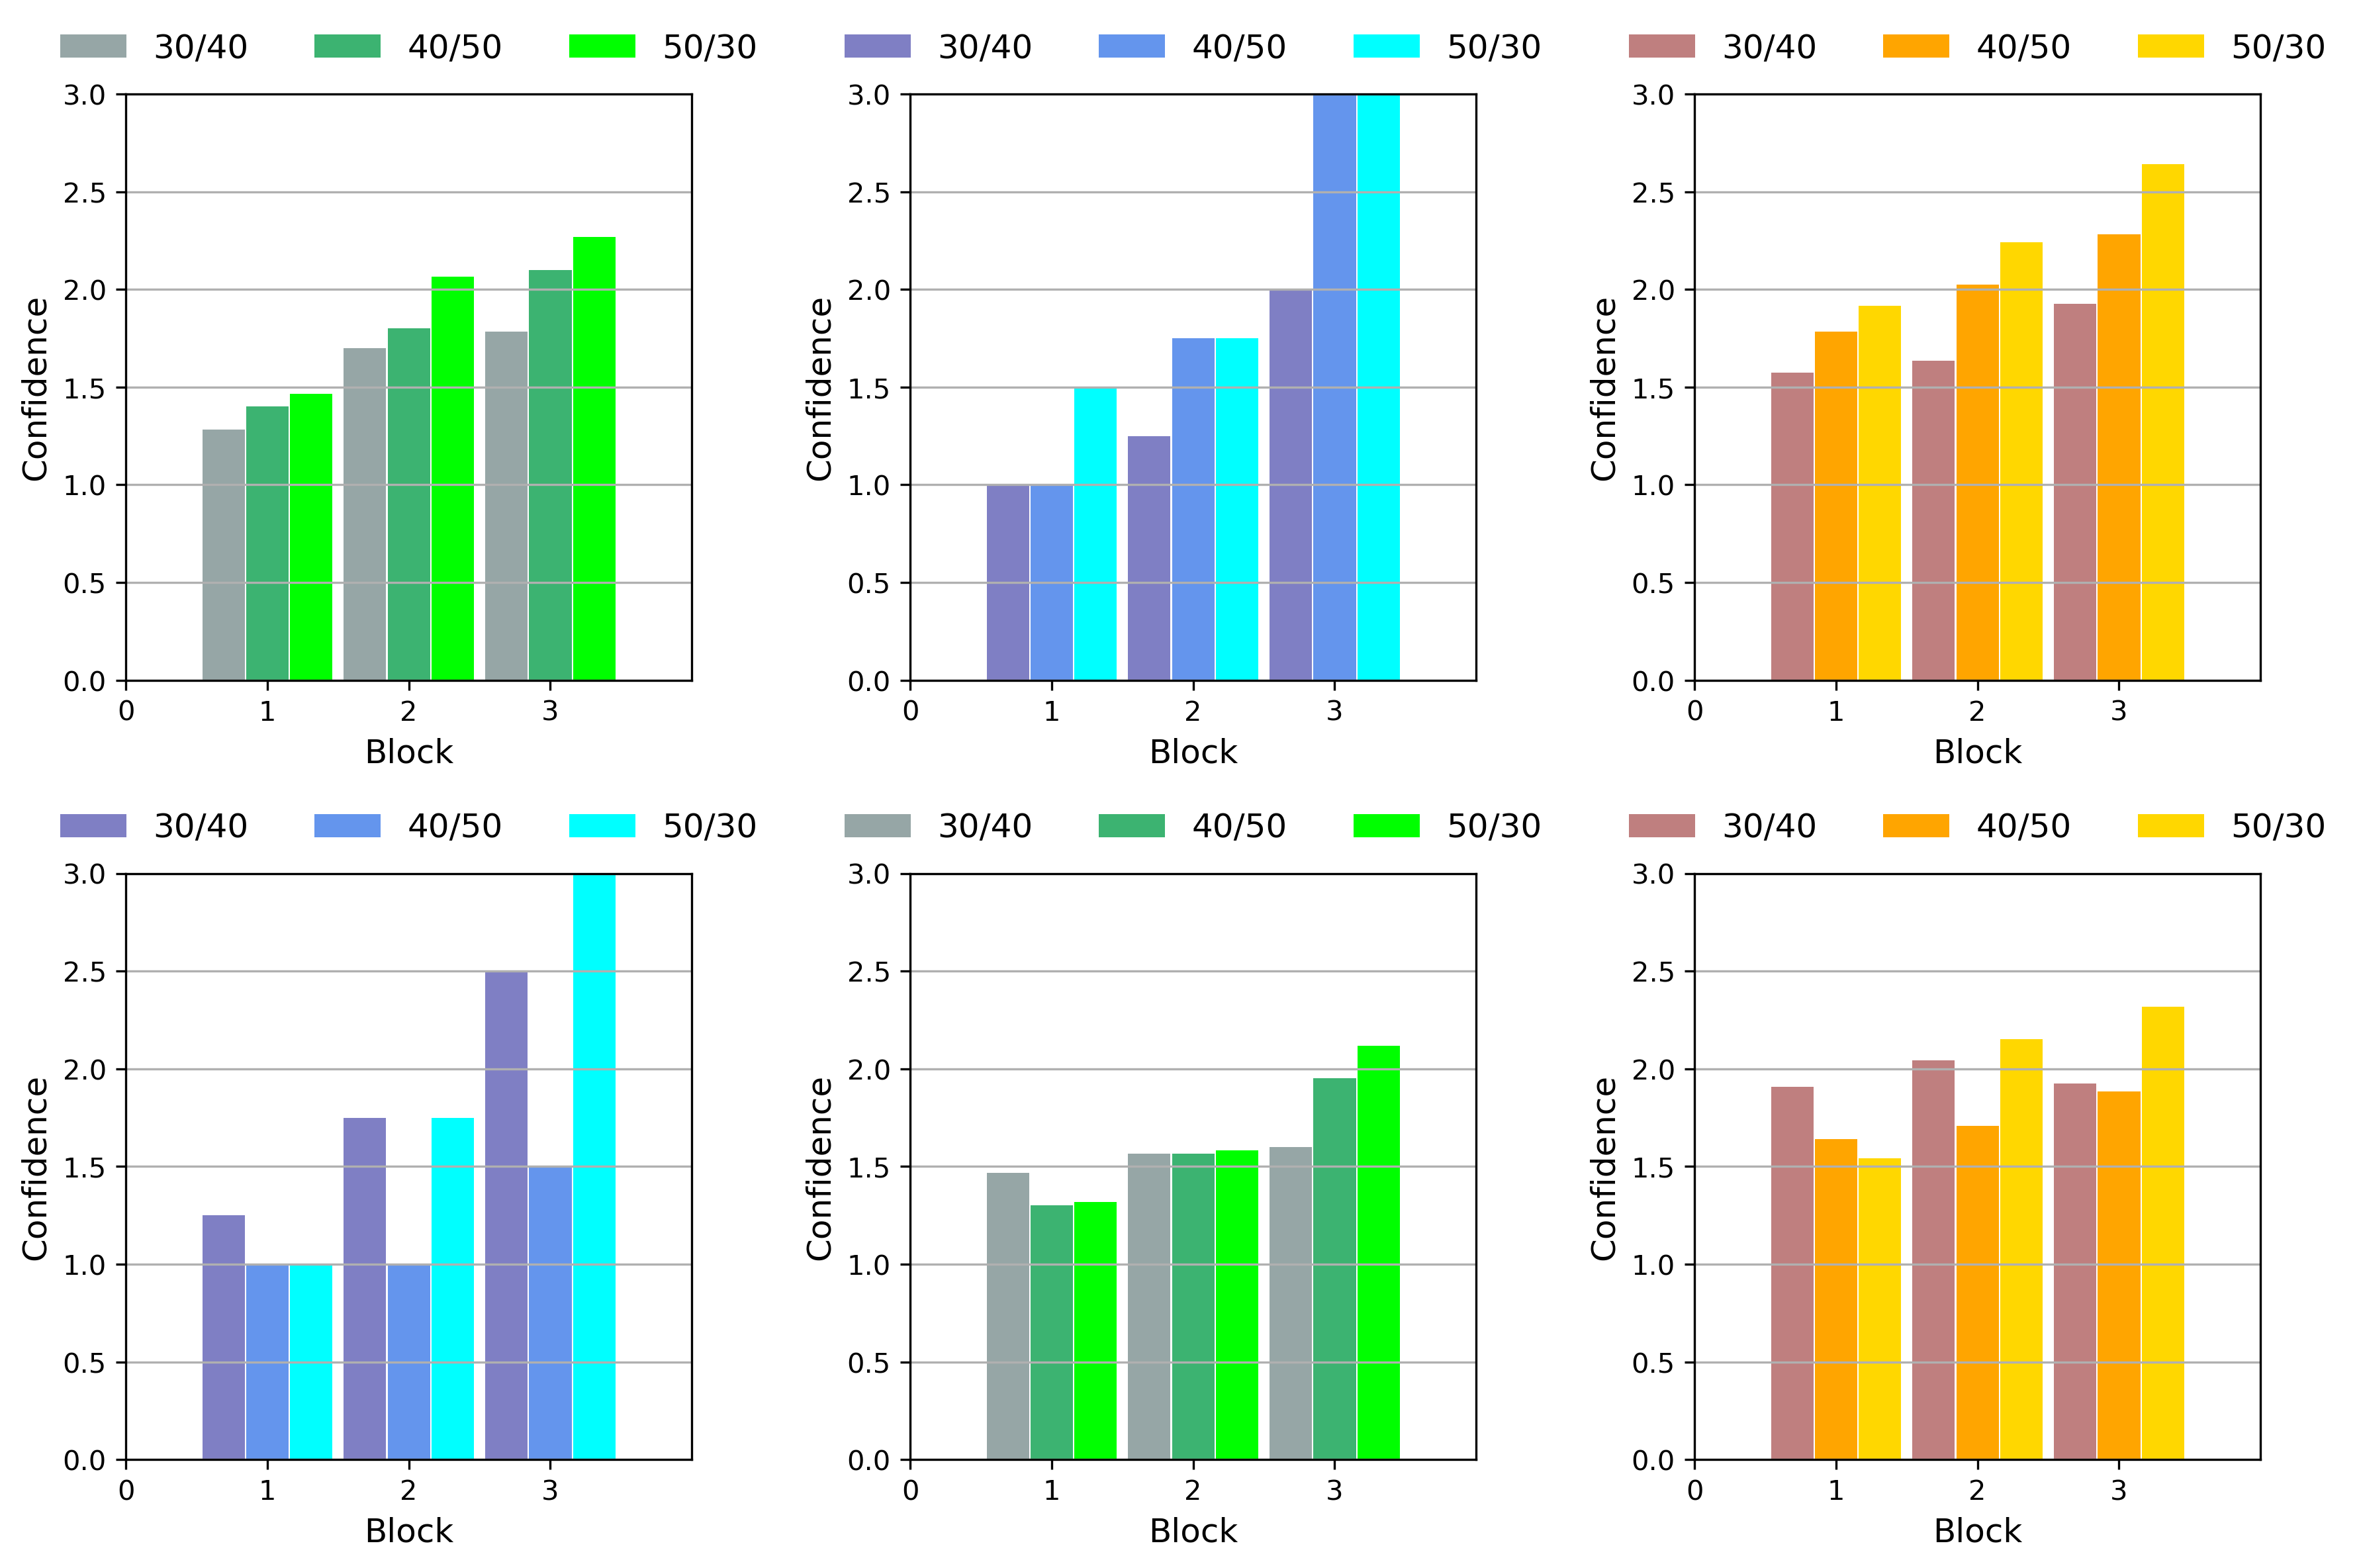

In [22]:
def conf_each_pair(ax, df, gap, pair, width, color, alpha, xlim, ylim):
    df = df.select(pl.col('block', 'loc_pattern', 'conf')).groupby('block', 'loc_pattern')\
        .mean().sort(by='block').with_columns(pl.col('conf')-6)

    df1 = df.filter(pl.col('loc_pattern')==1).with_columns(pl.col('block')-gap)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3).with_columns(pl.col('block')+gap)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.bar(df_.get_column('block'),
                df_.get_column('conf'),
                label=pair[i],
                width=width,
                color=color[i],
                alpha=alpha[i]
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Block', fontsize=12)
    ax.set_ylabel('Confidence', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 3

conf_each_pair(ax[0][0], integrated.slf1, gap, pair_label, width, color_slf, alpha, xlim_so, ylim)
conf_each_pair(ax[0][1], integrated.obs1, gap, pair_label, width, color_obs, alpha, xlim_so, ylim)
conf_each_pair(ax[0][2], integrated.test1, gap, pair_label, width, color_test, alpha, xlim_t, ylim)

conf_each_pair(ax[1][1], integrated.slf2, gap, pair_label, width, color_slf, alpha, xlim_so, ylim)
conf_each_pair(ax[1][0], integrated.obs2, gap, pair_label, width, color_obs, alpha, xlim_so, ylim)
conf_each_pair(ax[1][2], integrated.test2, gap, pair_label, width, color_test, alpha, xlim_t, ylim)

### Each Condition in Test (SS, OO, SO) 

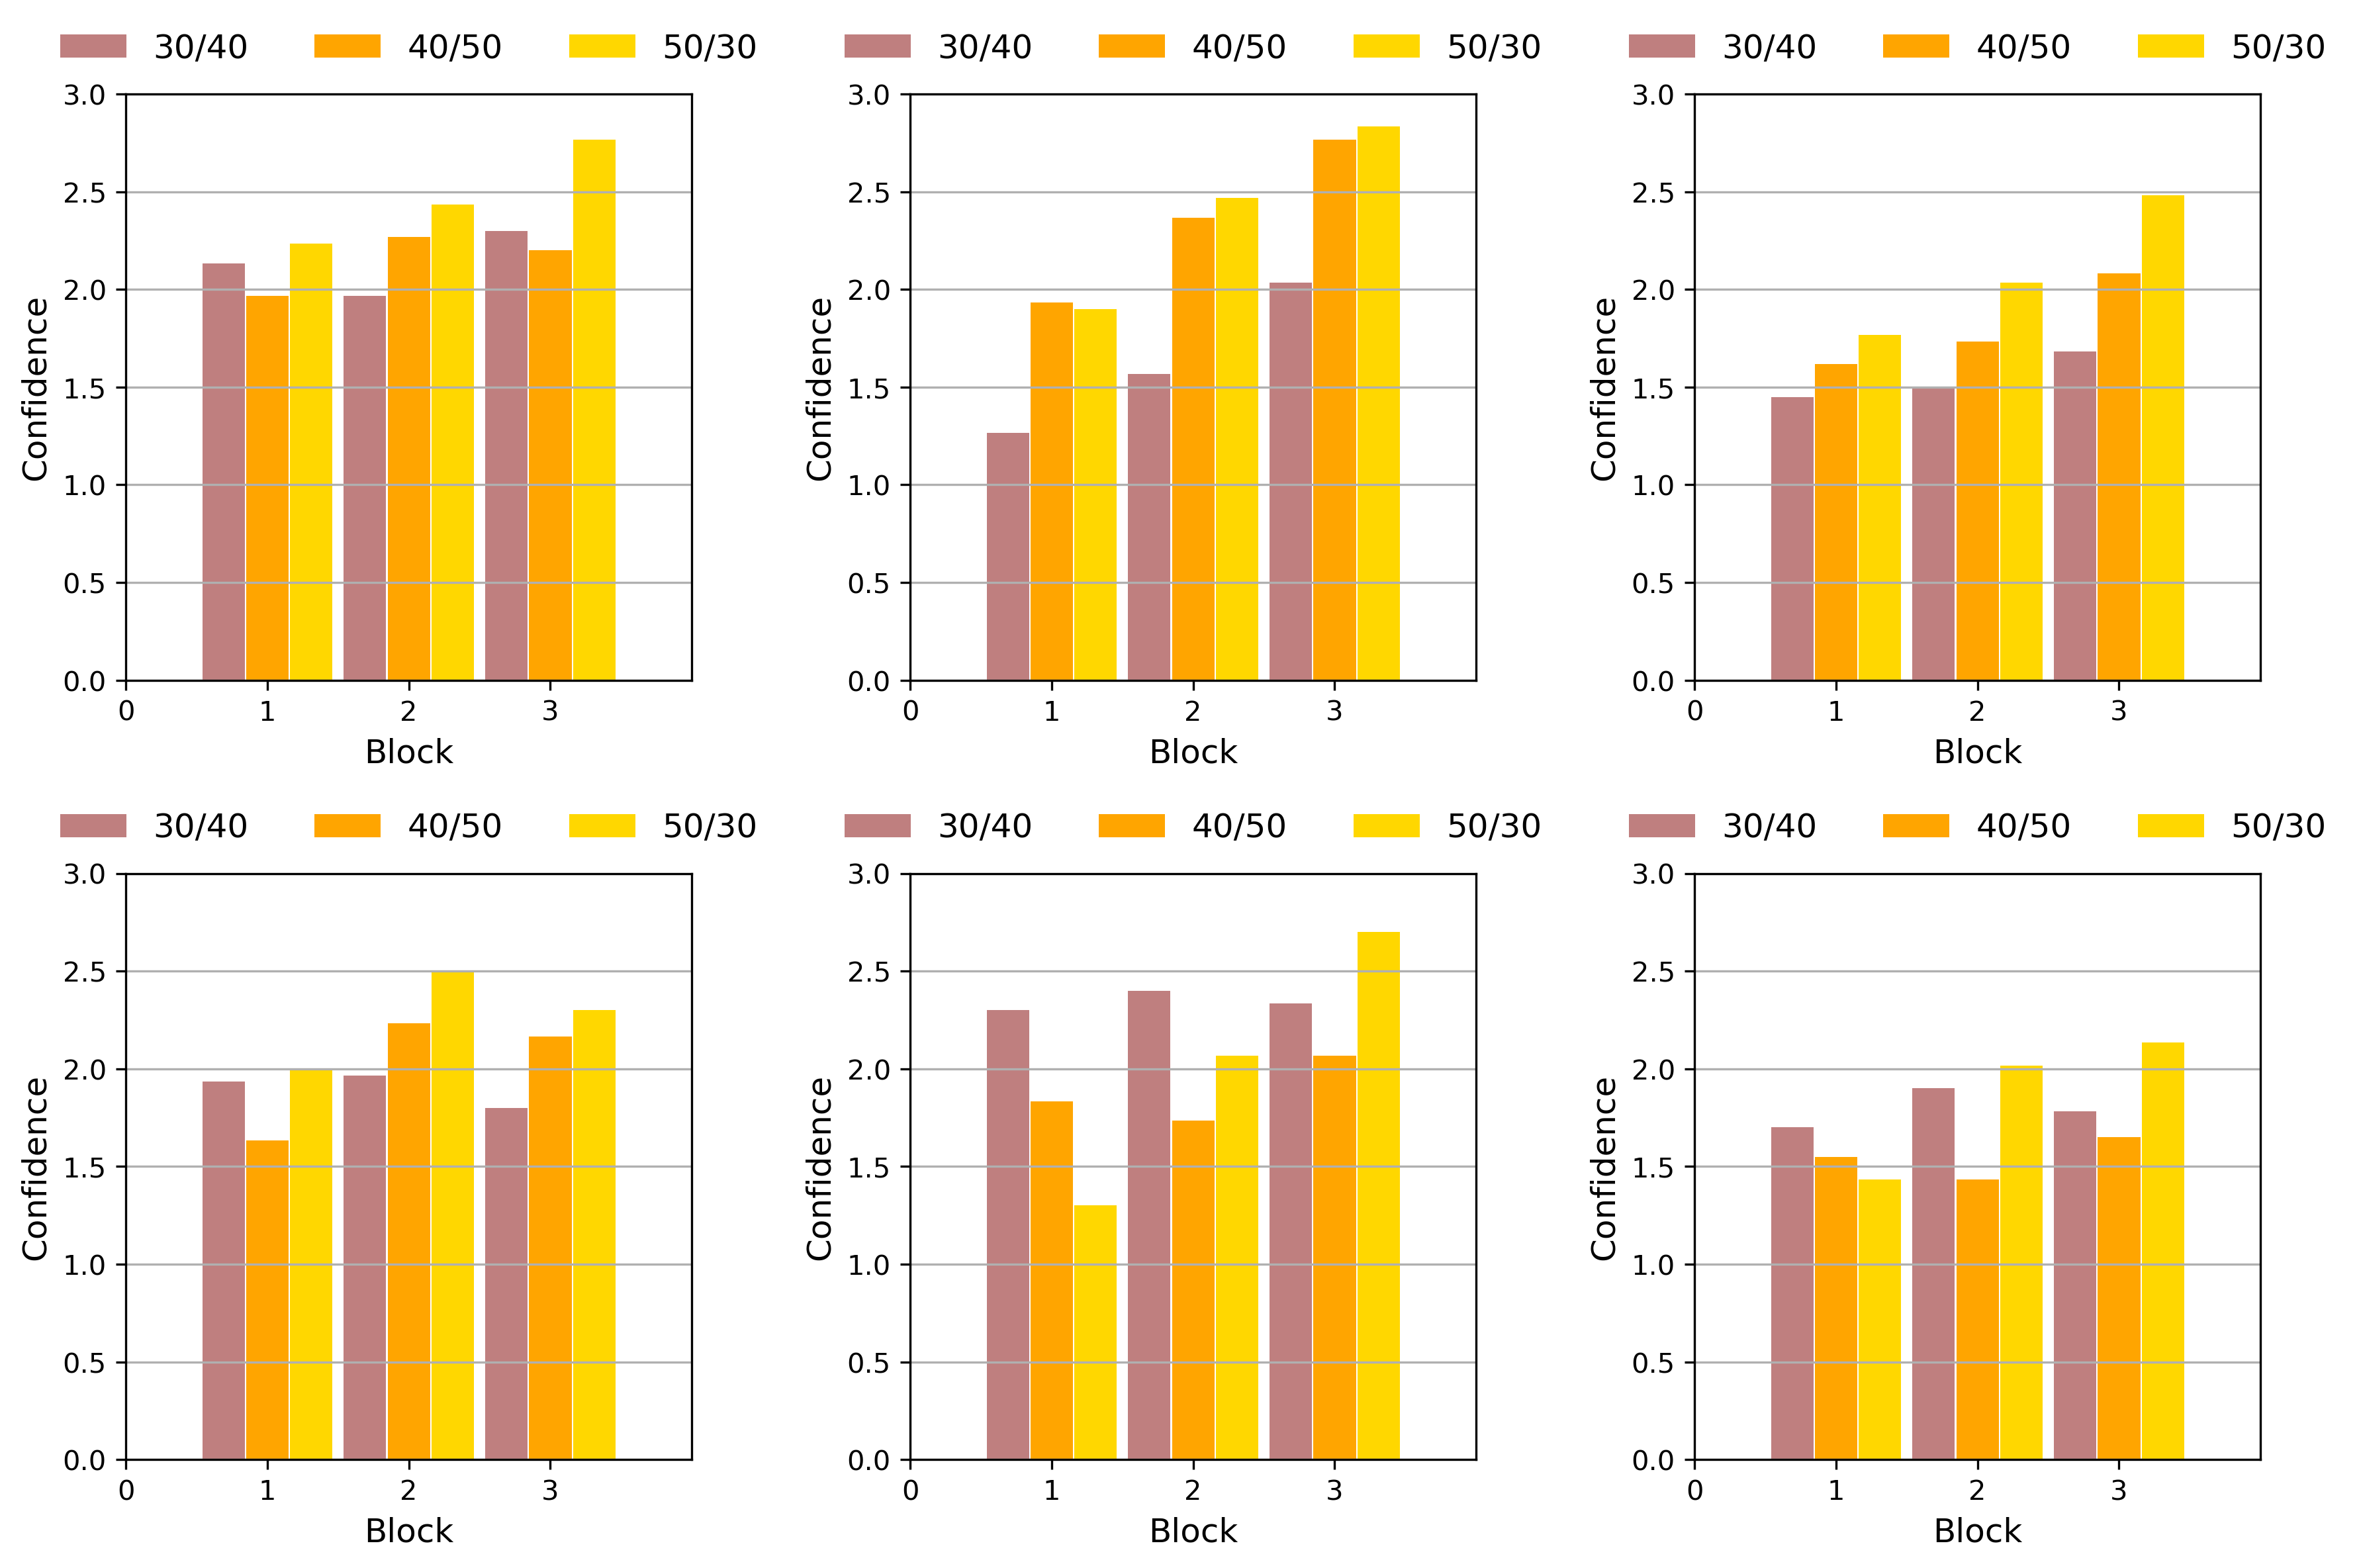

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 3

conf_each_pair(ax[0][0], integrated.test1.filter(pl.col('seq_pattern')==1),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
conf_each_pair(ax[0][1], integrated.test1.filter(pl.col('seq_pattern')==2),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
conf_each_pair(ax[0][2], integrated.test1.filter(pl.col('seq_pattern')>=3),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)

conf_each_pair(ax[1][0], integrated.test2.filter(pl.col('seq_pattern')==1),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
conf_each_pair(ax[1][1], integrated.test2.filter(pl.col('seq_pattern')==2),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
conf_each_pair(ax[1][2], integrated.test2.filter(pl.col('seq_pattern')>=3),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)

# Accuracy

### Each Block

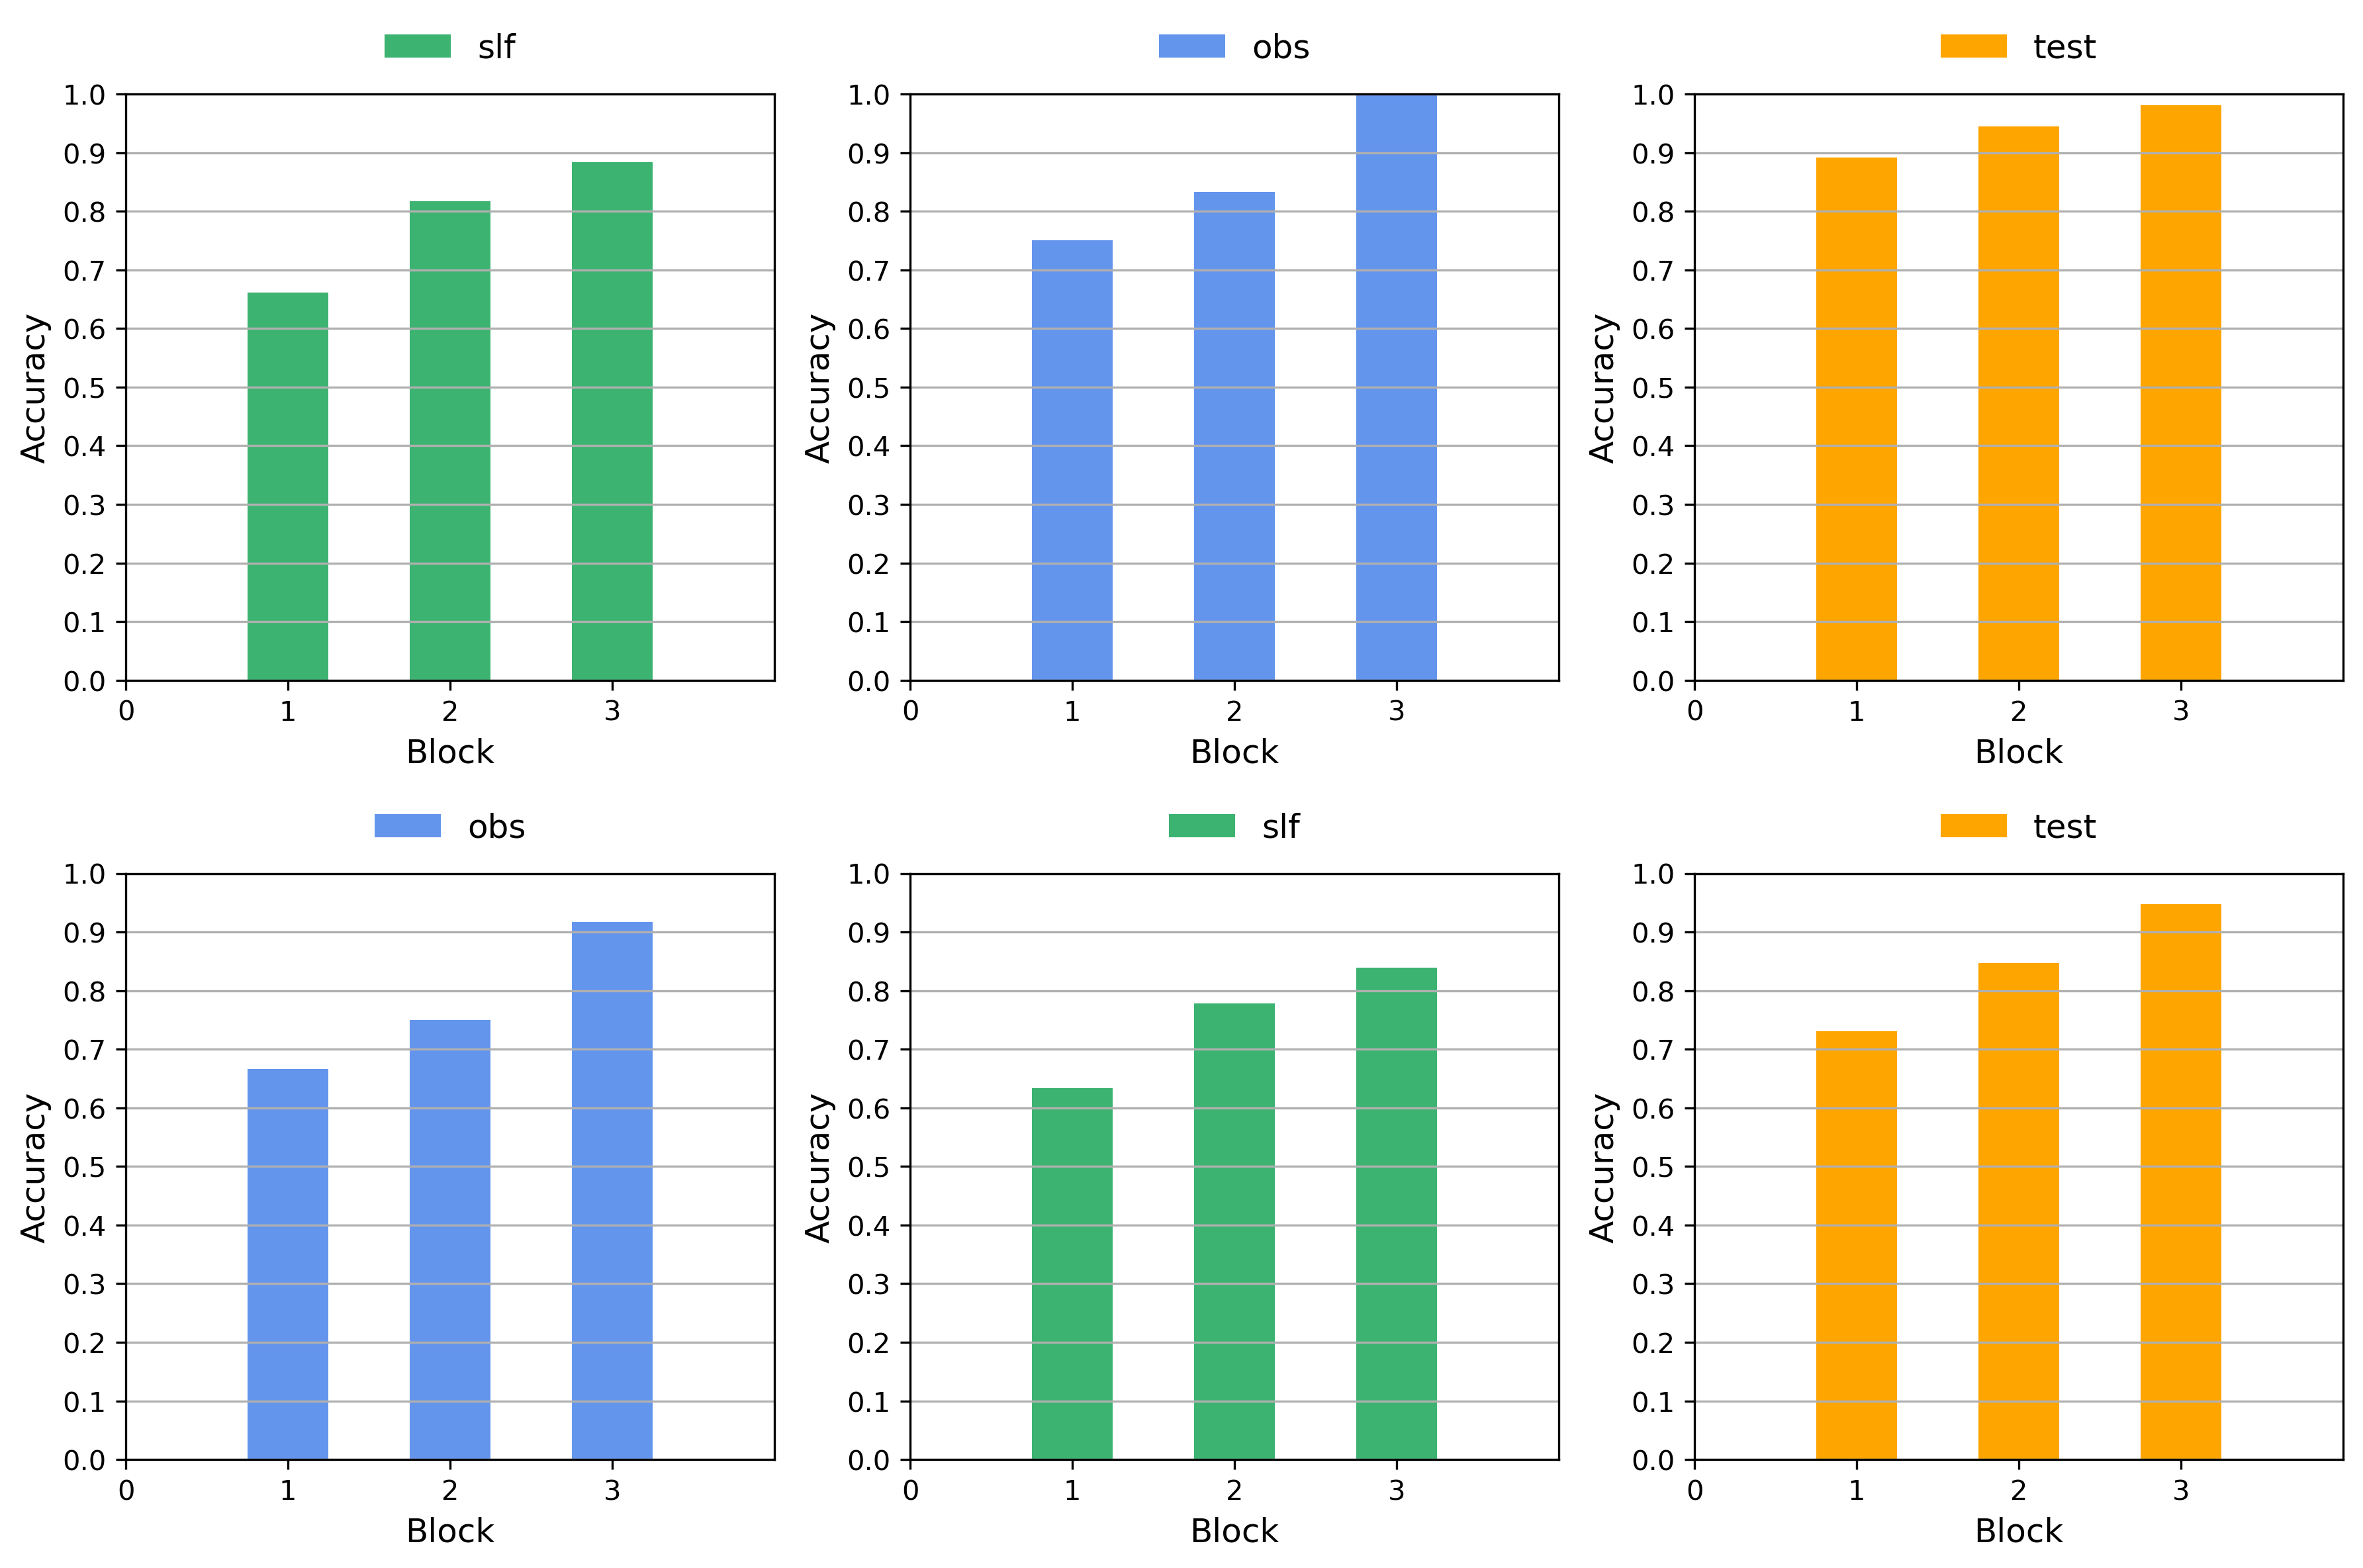

In [24]:
def accuracy_each_block(ax, df, seq, width, color, xlim, ylim):
    df = df.filter(pl.col('loc_pattern')<=3).select(pl.col('block', 'pt')).groupby('block').mean().sort(by='block')

    ax.bar(df.get_column('block'),
            df.get_column('pt'),
            label=seq,
            width=width,
            color=color
            )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.01, .1))
    ax.set_xlabel('Block', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

width = .5

xlim_so = 3
xlim_t = 3
ylim = 1

accuracy_each_block(ax[0][0], integrated.slf1, seq_label[0], width, colors[0], xlim_so, ylim)
accuracy_each_block(ax[0][1], integrated.obs1, seq_label[1], width, colors[1], xlim_so, ylim)
accuracy_each_block(ax[0][2], integrated.test1, seq_label[2], width, colors[2], xlim_t, ylim)

accuracy_each_block(ax[1][1], integrated.slf2, seq_label[0], width, colors[0], xlim_so, ylim)
accuracy_each_block(ax[1][0], integrated.obs2, seq_label[1], width, colors[1], xlim_so, ylim)
accuracy_each_block(ax[1][2], integrated.test2, seq_label[2], width, colors[2], xlim_t, ylim)

### Each Pair

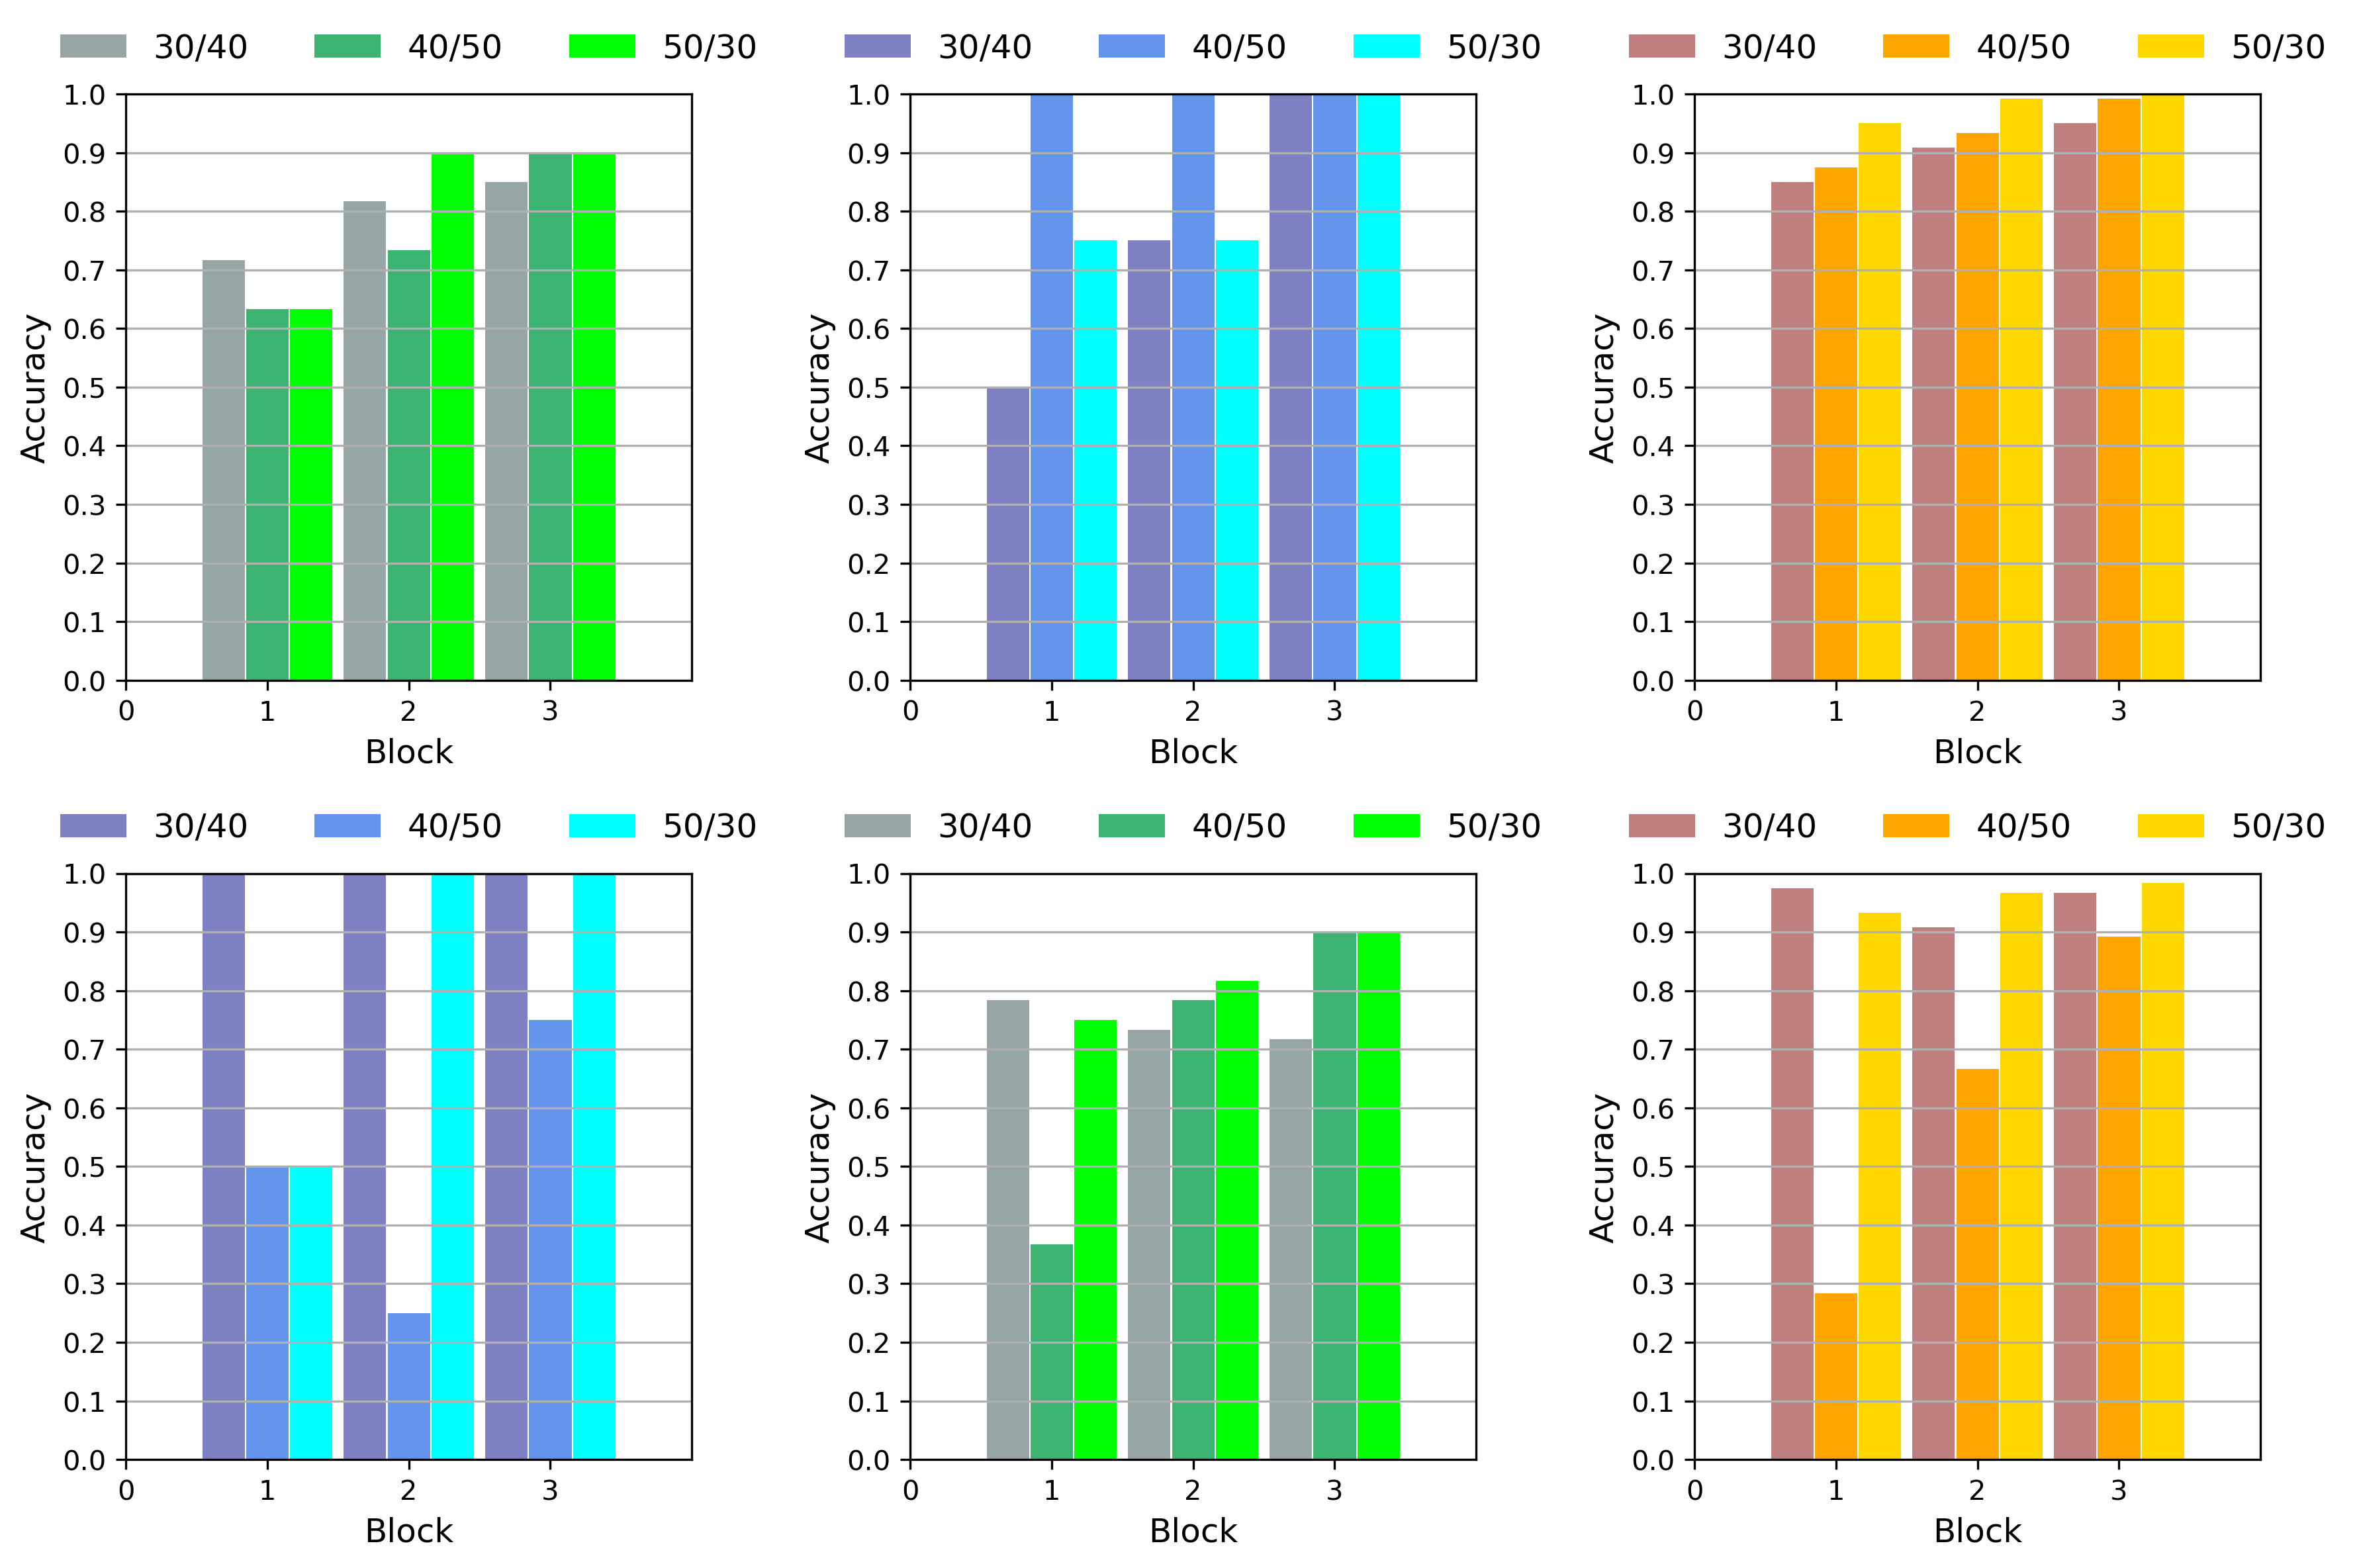

In [25]:
def accuracy_each_pair(ax, df, gap, pair, width, color, alpha, xlim, ylim):
    df = df.filter(pl.col('loc_pattern')<=3).select(pl.col('block', 'loc_pattern', 'pt'))\
        .groupby('block', 'loc_pattern').mean().sort(by='block')

    df1 = df.filter(pl.col('loc_pattern')==1).with_columns(pl.col('block')-gap)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3).with_columns(pl.col('block')+gap)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.bar(df_.get_column('block'),
                df_.get_column('pt'),
                label=pair[i],
                width=width,
                color=color[i],
                alpha=alpha[i]
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.01, .1))
    ax.set_xlabel('Block', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 1

accuracy_each_pair(ax[0][0], integrated.slf1, gap, pair_label, width, color_slf, alpha, xlim_so, ylim)
accuracy_each_pair(ax[0][1], integrated.obs1, gap, pair_label, width, color_obs, alpha, xlim_so, ylim)
accuracy_each_pair(ax[0][2], integrated.test1, gap, pair_label, width, color_test, alpha, xlim_t, ylim)

accuracy_each_pair(ax[1][1], integrated.slf2, gap, pair_label, width, color_slf, alpha, xlim_so, ylim)
accuracy_each_pair(ax[1][0], integrated.obs2, gap, pair_label, width, color_obs, alpha, xlim_so, ylim)
accuracy_each_pair(ax[1][2], integrated.test2, gap, pair_label, width, color_test, alpha, xlim_t, ylim)

### Each Condition in Test (SS, OO, SO) 

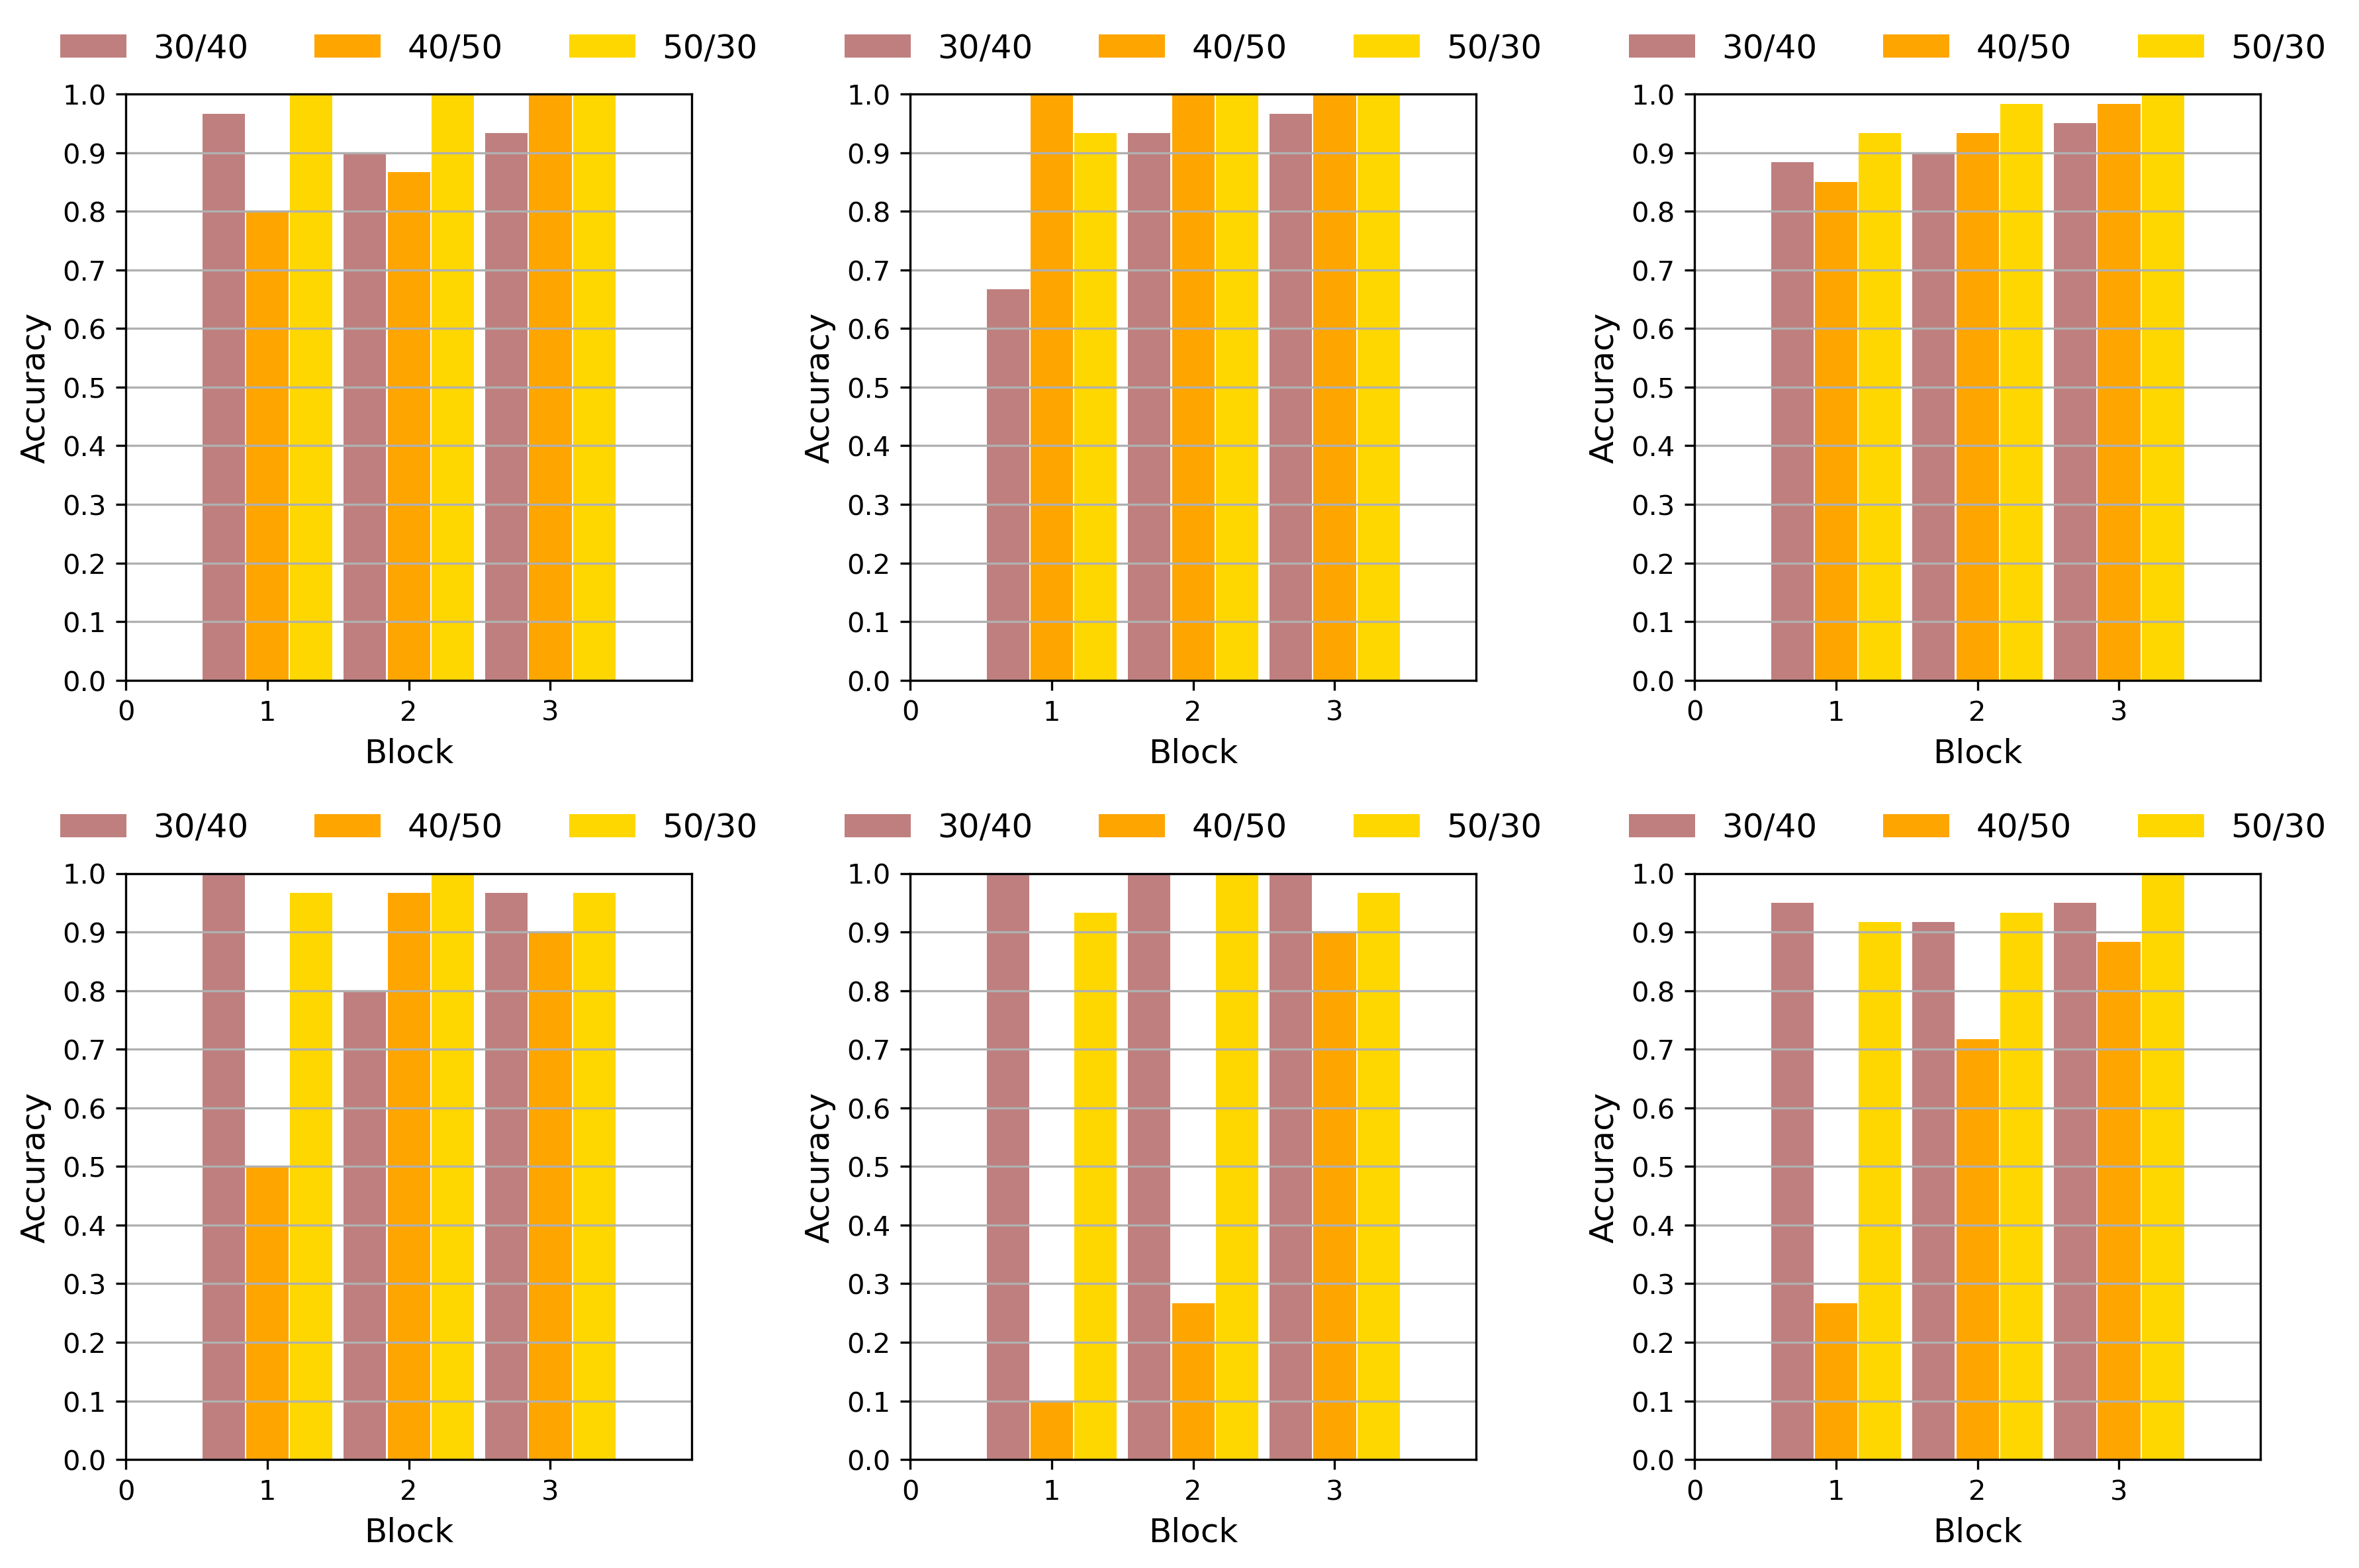

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 1

accuracy_each_pair(ax[0][0], integrated.test1.filter(pl.col('seq_pattern')==1),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
accuracy_each_pair(ax[0][1], integrated.test1.filter(pl.col('seq_pattern')==2),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
accuracy_each_pair(ax[0][2], integrated.test1.filter(pl.col('seq_pattern')>=3),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)

accuracy_each_pair(ax[1][0], integrated.test2.filter(pl.col('seq_pattern')==1),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
accuracy_each_pair(ax[1][1], integrated.test2.filter(pl.col('seq_pattern')==2),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)
accuracy_each_pair(ax[1][2], integrated.test2.filter(pl.col('seq_pattern')>=3),
                gap, pair_label, width, color_test, alpha, xlim_t, ylim)

# Statistical Test

In [ ]:
def mannwhitneyu_test_group(t1, t2):
    p =[0 for _ in range(9)]

    for bi in range(3):
        arr_ss1 = t1[(t1['seq_pattern']==1) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_ss2 = t2[(t2['seq_pattern']==1) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_oo1 = t1[(t1['seq_pattern']==2) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_oo2 = t2[(t2['seq_pattern']==2) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_so1 = t1[(t1['seq_pattern']>=3) & (t1['loc_pattern']<=3) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_so2 = t2[(t2['seq_pattern']>=3) & (t2['loc_pattern']<=3) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        p[bi]   = stats.mannwhitneyu(arr_ss1, arr_ss2, alternative='two-sided').pvalue
        p[bi+3] = stats.mannwhitneyu(arr_oo1, arr_oo2, alternative='two-sided').pvalue
        p[bi+6] = stats.mannwhitneyu(arr_so1, arr_so2, alternative='two-sided').pvalue

    return p


def binomial_test_chance(t):
    p =[0 for _ in range(9)]
    block = [1, 2, 3]

    for bi in block:
        arr_ss = t[(t['seq_pattern']==1) & (t['block']==bi)]['pt']
        corr_ss = np.count_nonzero(arr_ss == 1)

        arr_oo = t[(t['seq_pattern']==2) & (t['block']==bi)]['pt']
        corr_oo = np.count_nonzero(arr_oo == 1)

        arr_so = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==bi)]['pt']
        corr_so = np.count_nonzero(arr_so == 1)

        p[bi-1] = stats.binomtest(corr_ss, len(arr_ss), 0.5, 'greater').pvalue
        p[bi+2] = stats.binomtest(corr_oo, len(arr_oo), 0.5, 'greater').pvalue
        p[bi+5] = stats.binomtest(corr_so, len(arr_so), 0.5, 'greater').pvalue

    return p


def wilcoxon_test_diff(t):
    p =[0 for _ in range(6)]

    for bi in range(2):
        arr_ss1 = t[(t['seq_pattern']==1) & (t['block']==bi+1)].groupby('subj').mean()['pt']
        arr_ss2 = t[(t['seq_pattern']==1) & (t['block']==bi+2)].groupby('subj').mean()['pt']

        arr_oo1 = t[(t['seq_pattern']==2) & (t['block']==bi+1)].groupby('subj').mean()['pt']
        arr_oo2 = t[(t['seq_pattern']==2) & (t['block']==bi+2)].groupby('subj').mean()['pt']

        arr_so1 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==bi+1)].groupby('subj').mean()['pt']
        arr_so2 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==bi+2)].groupby('subj').mean()['pt']

        p[bi]   = stats.wilcoxon(arr_ss1, arr_ss2, zero_method='zsplit', alternative='less').pvalue
        p[bi+2] = stats.wilcoxon(arr_oo1, arr_oo2, zero_method='zsplit', alternative='less').pvalue
        p[bi+4] = stats.wilcoxon(arr_so1, arr_so2, zero_method='zsplit', alternative='less').pvalue

    return p


def wilcoxon_test_diff2(t):
    p =[0 for _ in range(3)]

    arr_ss1 = t[(t['seq_pattern']==1) & (t['block']==1)].groupby('subj').mean()['pt']
    arr_ss2 = t[(t['seq_pattern']==1) & (t['block']==3)].groupby('subj').mean()['pt']

    arr_oo1 = t[(t['seq_pattern']==2) & (t['block']==1)].groupby('subj').mean()['pt']
    arr_oo2 = t[(t['seq_pattern']==2) & (t['block']==3)].groupby('subj').mean()['pt']

    arr_so1 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==1)].groupby('subj').mean()['pt']
    arr_so2 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==3)].groupby('subj').mean()['pt']

    p[0]   = stats.wilcoxon(arr_ss1, arr_ss2, zero_method='zsplit', alternative='less').pvalue
    p[1] = stats.wilcoxon(arr_oo1, arr_oo2, zero_method='zsplit', alternative='less').pvalue
    p[2] = stats.wilcoxon(arr_so1, arr_so2, zero_method='zsplit', alternative='less').pvalue

    return p


def wilcoxon_test_pat(t1, t2):
    p =[0 for _ in range(9)]

    for bi in range(3):
        arr_ss1 = t1[(t1['seq_pattern']==1) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_ss2 = t2[(t2['seq_pattern']==1) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_oo1 = t1[(t1['seq_pattern']==2) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_oo2 = t2[(t2['seq_pattern']==2) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_so1 = t1[(t1['seq_pattern']>=3) & (t1['loc_pattern']<=3) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_so2 = t2[(t2['seq_pattern']>=3) & (t2['loc_pattern']<=3) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        p[bi]   = stats.wilcoxon(arr_ss1, arr_ss2, alternative='greater').pvalue
        p[bi+3] = stats.wilcoxon(arr_oo1, arr_oo2, alternative='greater').pvalue
        p[bi+6] = stats.wilcoxon(arr_so1, arr_so2, alternative='greater').pvalue

    return p

In [ ]:
print('\n','between groups : U two-sided')
for i in range(2):
    pvalue = mannwhitneyu_test_group(integrated_data_1[i][2], integrated_data_2[i][2])
    print(f'pattern{i+1} : {pvalue}')

print('\n','chance level : Binomial greater')
for i in range(2):
    pvalue = binomial_test_chance(integrated_data_0[i][2])
    print(f'pattern{i+1} : {np.max(pvalue)}')

print('\n','between blocks : Wilcoxon less')
for i in range(2):
    pvalue = wilcoxon_test_diff(integrated_data_1[i][2])
    print(f'pattern{i+1}, blocks : {pvalue}')

print('\n','between block1 to 3 : Wilcoxon less')
for i in range(2):
    pvalue = wilcoxon_test_diff2(integrated_data_0[i][2])
    print(f'pattern{i+1}, b1-b3 : {pvalue}')

print('\n','between patterns : Wilcoxon less')
pvalue = wilcoxon_test_pat(integrated_data_0[0][2], integrated_data_0[1][2])
print(f'pattern1-pattern2 : {pvalue}')


 between groups : U two-sided
pattern1 : [0.26248932960549853, 0.26248932960549853, 0.4226780741706355, 0.21224679413671388, 0.34957480612329817, 0.4226780741706355, 0.22020941657927107, 1.0, 0.6190161801767022]
pattern2 : [0.25507183899458385, 0.1453682902254159, 0.09742168927634334, 0.37215383020417214, 0.32136290470164053, 0.4557473162658464, 0.11241908820212458, 0.5109393498748492, 0.6785561298651183]

 chance level : Binomial greater
pattern1 : 2.601215001541593e-13
pattern2 : 0.0004863803539756835

 between blocks : Wilcoxon less
pattern1, blocks : [0.5, 0.13569800878653, 0.0319825310473083, 0.726753202296709, 0.03248889098803485, 0.13601972394786777]
pattern2, blocks : [0.5563014102976949, 0.3331138227048094, 0.06581410942268072, 0.005987951838404253, 0.12954322659078793, 0.010197420091687953]

 between block1 to 3 : Wilcoxon less
pattern1, b1-b3 : [0.10233344038523562, 0.01447156892397598, 0.007593099278532261]
pattern2, b1-b3 : [0.03940559544966772, 0.00035923087354130156, 6.

In [ ]:
def negative_likelihood(df, ax, col, gap, label, width, ymax, color, transparency):
    capsize = 3
    df_ll = df[['pattern', col]]
    sem_ll = [df_ll[df_ll['pattern']==i][col].sem() for i in [1,2]]
    df_ll = df_ll.pivot_table(index='pattern', values=col, aggfunc=np.mean)

    ax.bar(df_ll.index+gap, -df_ll[col], label=label, width=width, color=color, alpha=transparency, yerr=sem_ll, capsize=capsize)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, ymax)
    ax.set_xticks(np.arange(1, 3, step=1), fontsize=18)
    ax.set_yticks(np.arange(0, ymax+.1, step=1), fontsize=18)
    ax.set_xlabel('Pattern', fontsize=20)
    ax.set_ylabel('Negative Log-Likelihood', fontsize=20)
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=20)
    # ax.set_title(T_title_label[i], x=.5, y=1.15, fontsize=20)


def negative_likelihood_so(df, ax, col, gap, label, width, ymax, ystep, color, transparency):
    capsize = 3

    df_ll = df[['pattern', col]]
    sem_ll = [df_ll[df_ll['pattern']==i][col].sem() for i in [1,2]]
    df_ll = df_ll.pivot_table(index='pattern', values=col, aggfunc=np.mean)

    ax.bar(df_ll.index+gap, -df_ll[col], label=label, width=width, color=color, alpha=transparency, yerr=sem_ll, capsize=capsize)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, ymax)
    ax.set_xticks(np.arange(1, 3, step=1), fontsize=18)
    ax.set_yticks(np.arange(0, ymax+.1, step=ystep), fontsize=18)
    ax.set_xlabel('Pattern', fontsize=20)
    ax.set_ylabel('Negative Log-Likelihood', fontsize=20)
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=20)
    # ax.set_title(T_title_label[i], x=.5, y=1.15, fontsize=20)

# Reinforcement Learning (RL)

### Most Likelihood Estimation (MLE)

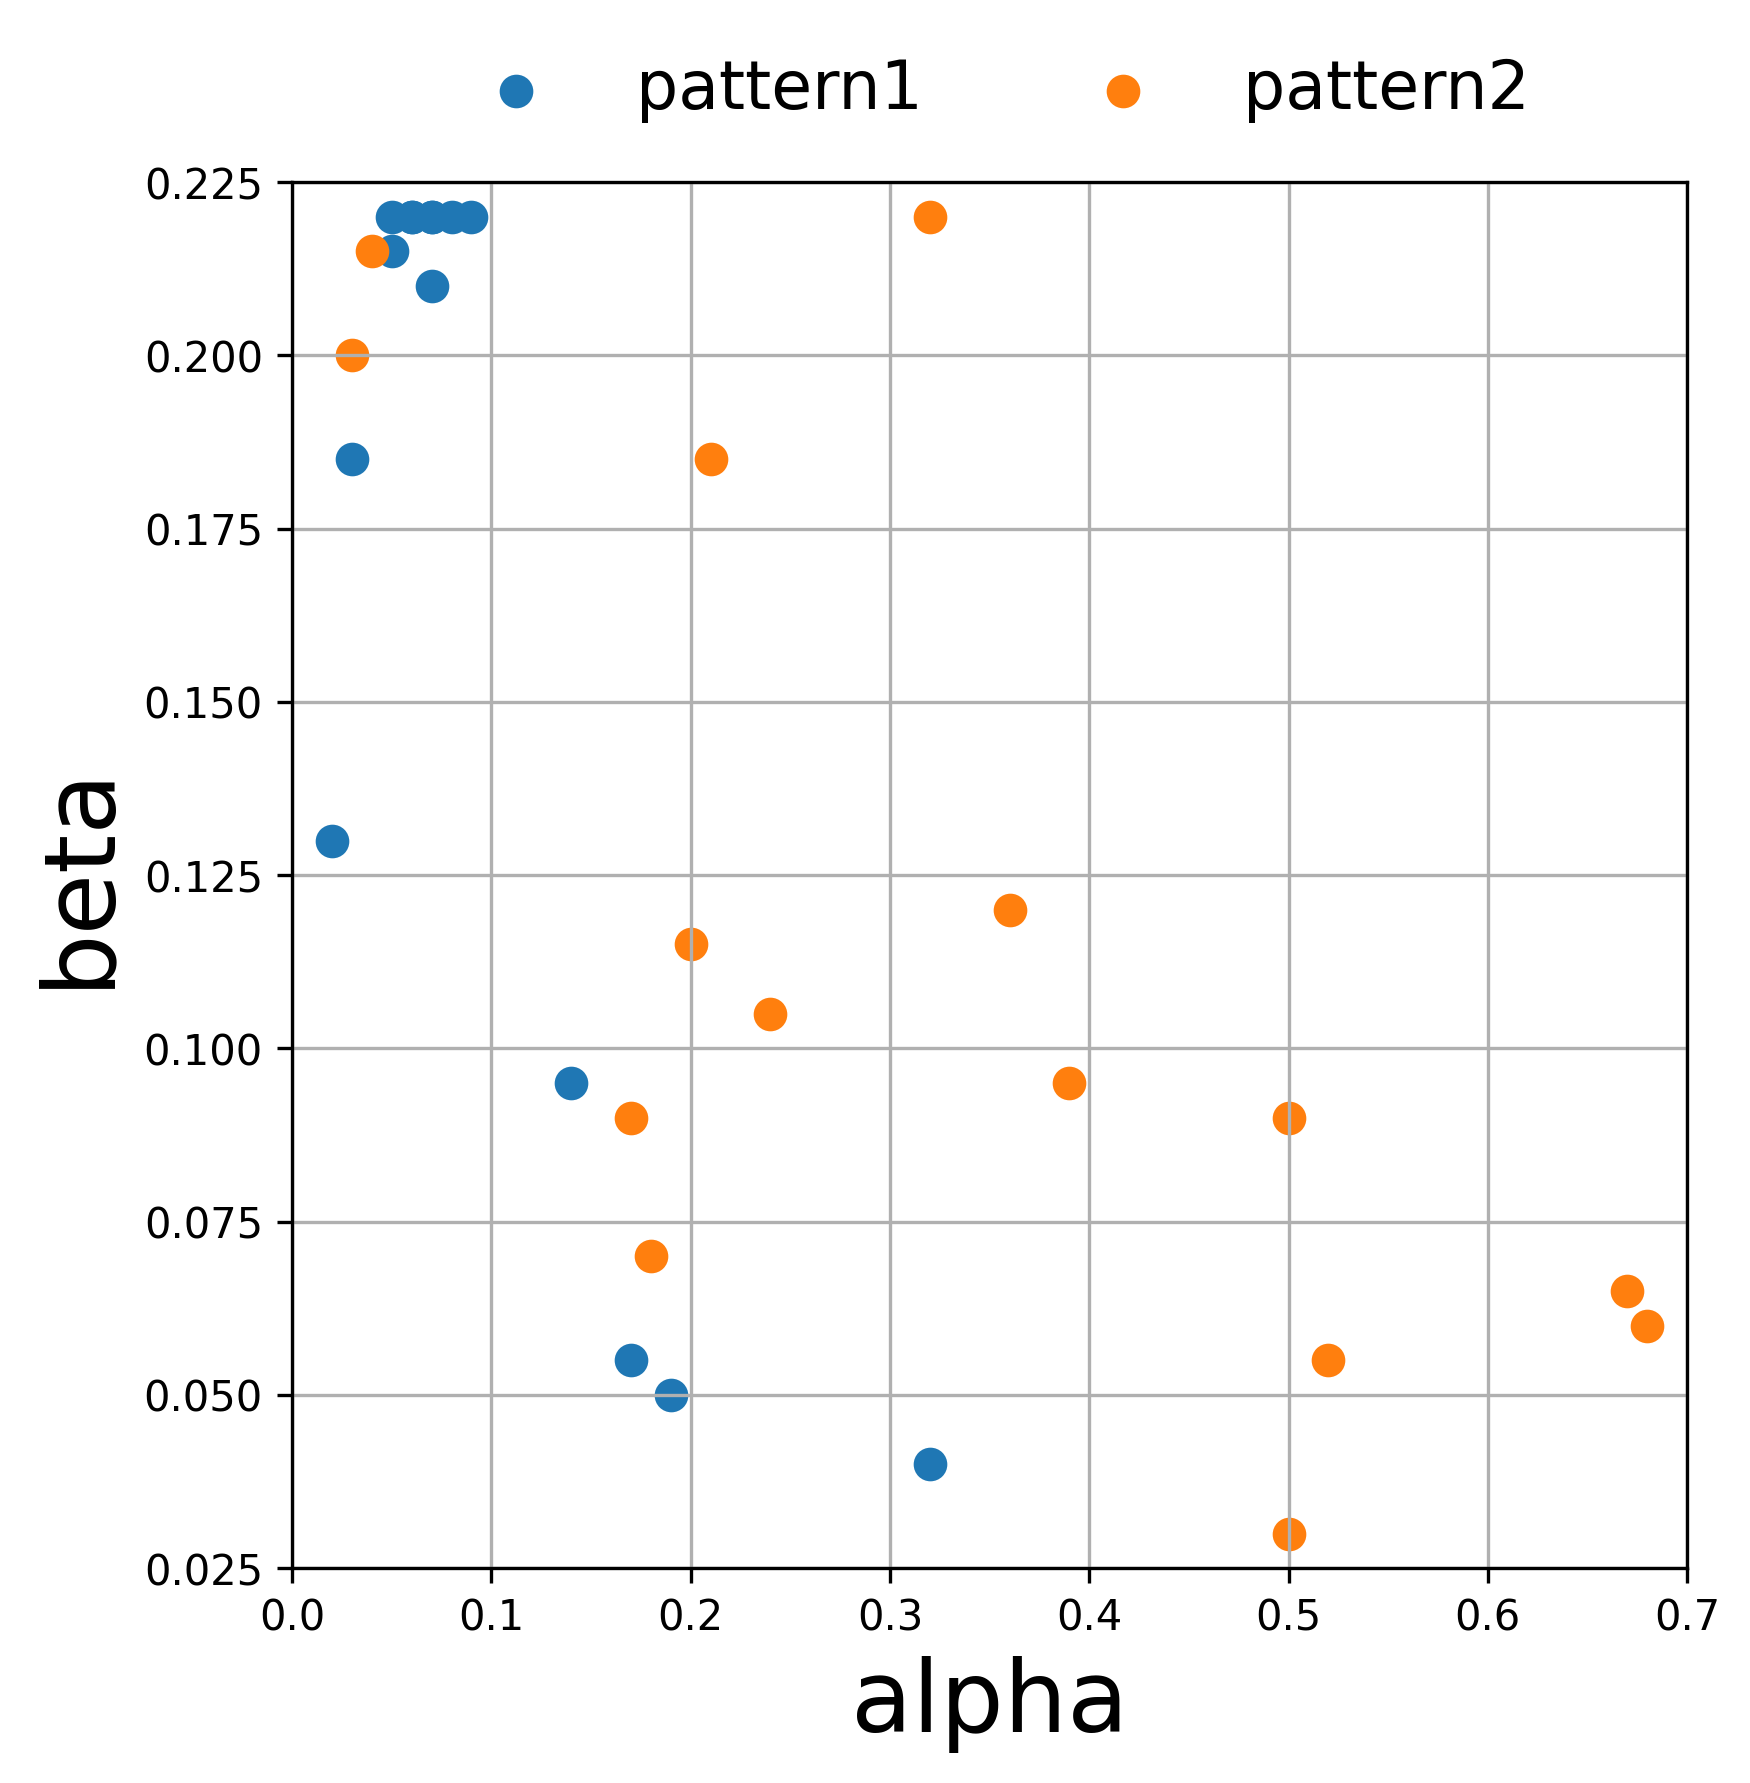

In [ ]:
df = pd.read_excel('params.xlsx')
corr1 = df[df['pattern']==1][['alpha_MLE', 'beta_MLE']].corr()
corr2 = df[df['pattern']==2][['alpha_MLE', 'beta_MLE']].corr()

fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax.scatter(df[df['pattern']==1]['alpha_MLE'], df[df['pattern']==1]['beta_MLE'], marker='o', s=50, label='pattern1')
ax.scatter(df[df['pattern']==2]['alpha_MLE'], df[df['pattern']==2]['beta_MLE'], marker='o', s=50, label='pattern2')

ax.set_xlim(0, 0.7)
ax.set_ylim(0.025, 0.225)
ax.set_xlabel('alpha', fontsize=24)
ax.set_ylabel('beta', fontsize=24)
ax.grid()
ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=16)

<AxesSubplot: >

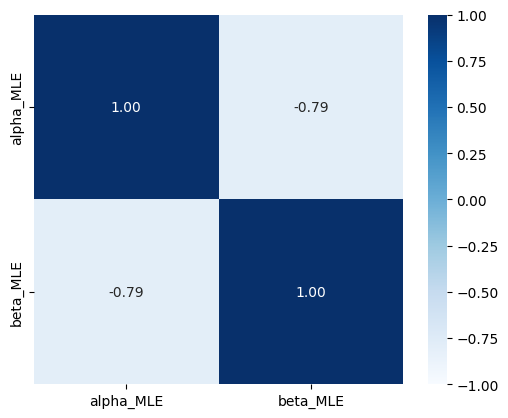

In [ ]:
sns.heatmap(corr1, vmin=-1.0, vmax=1.0, cmap='Blues'  , center=0, annot=True, fmt='.2f', square=True)

<AxesSubplot: >

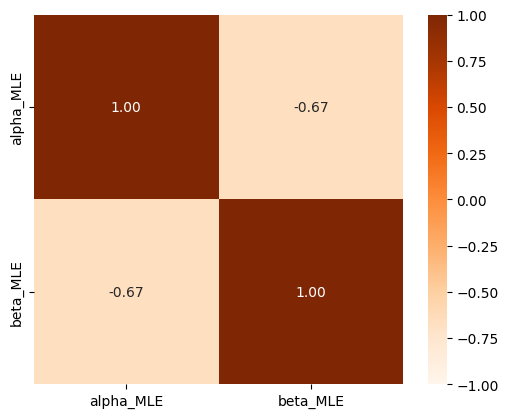

In [ ]:
sns.heatmap(corr2, vmin=-1.0, vmax=1.0, cmap='Oranges', center=0, annot=True, fmt='.2f', square=True)

### Comarison of Negative Log-likelihood

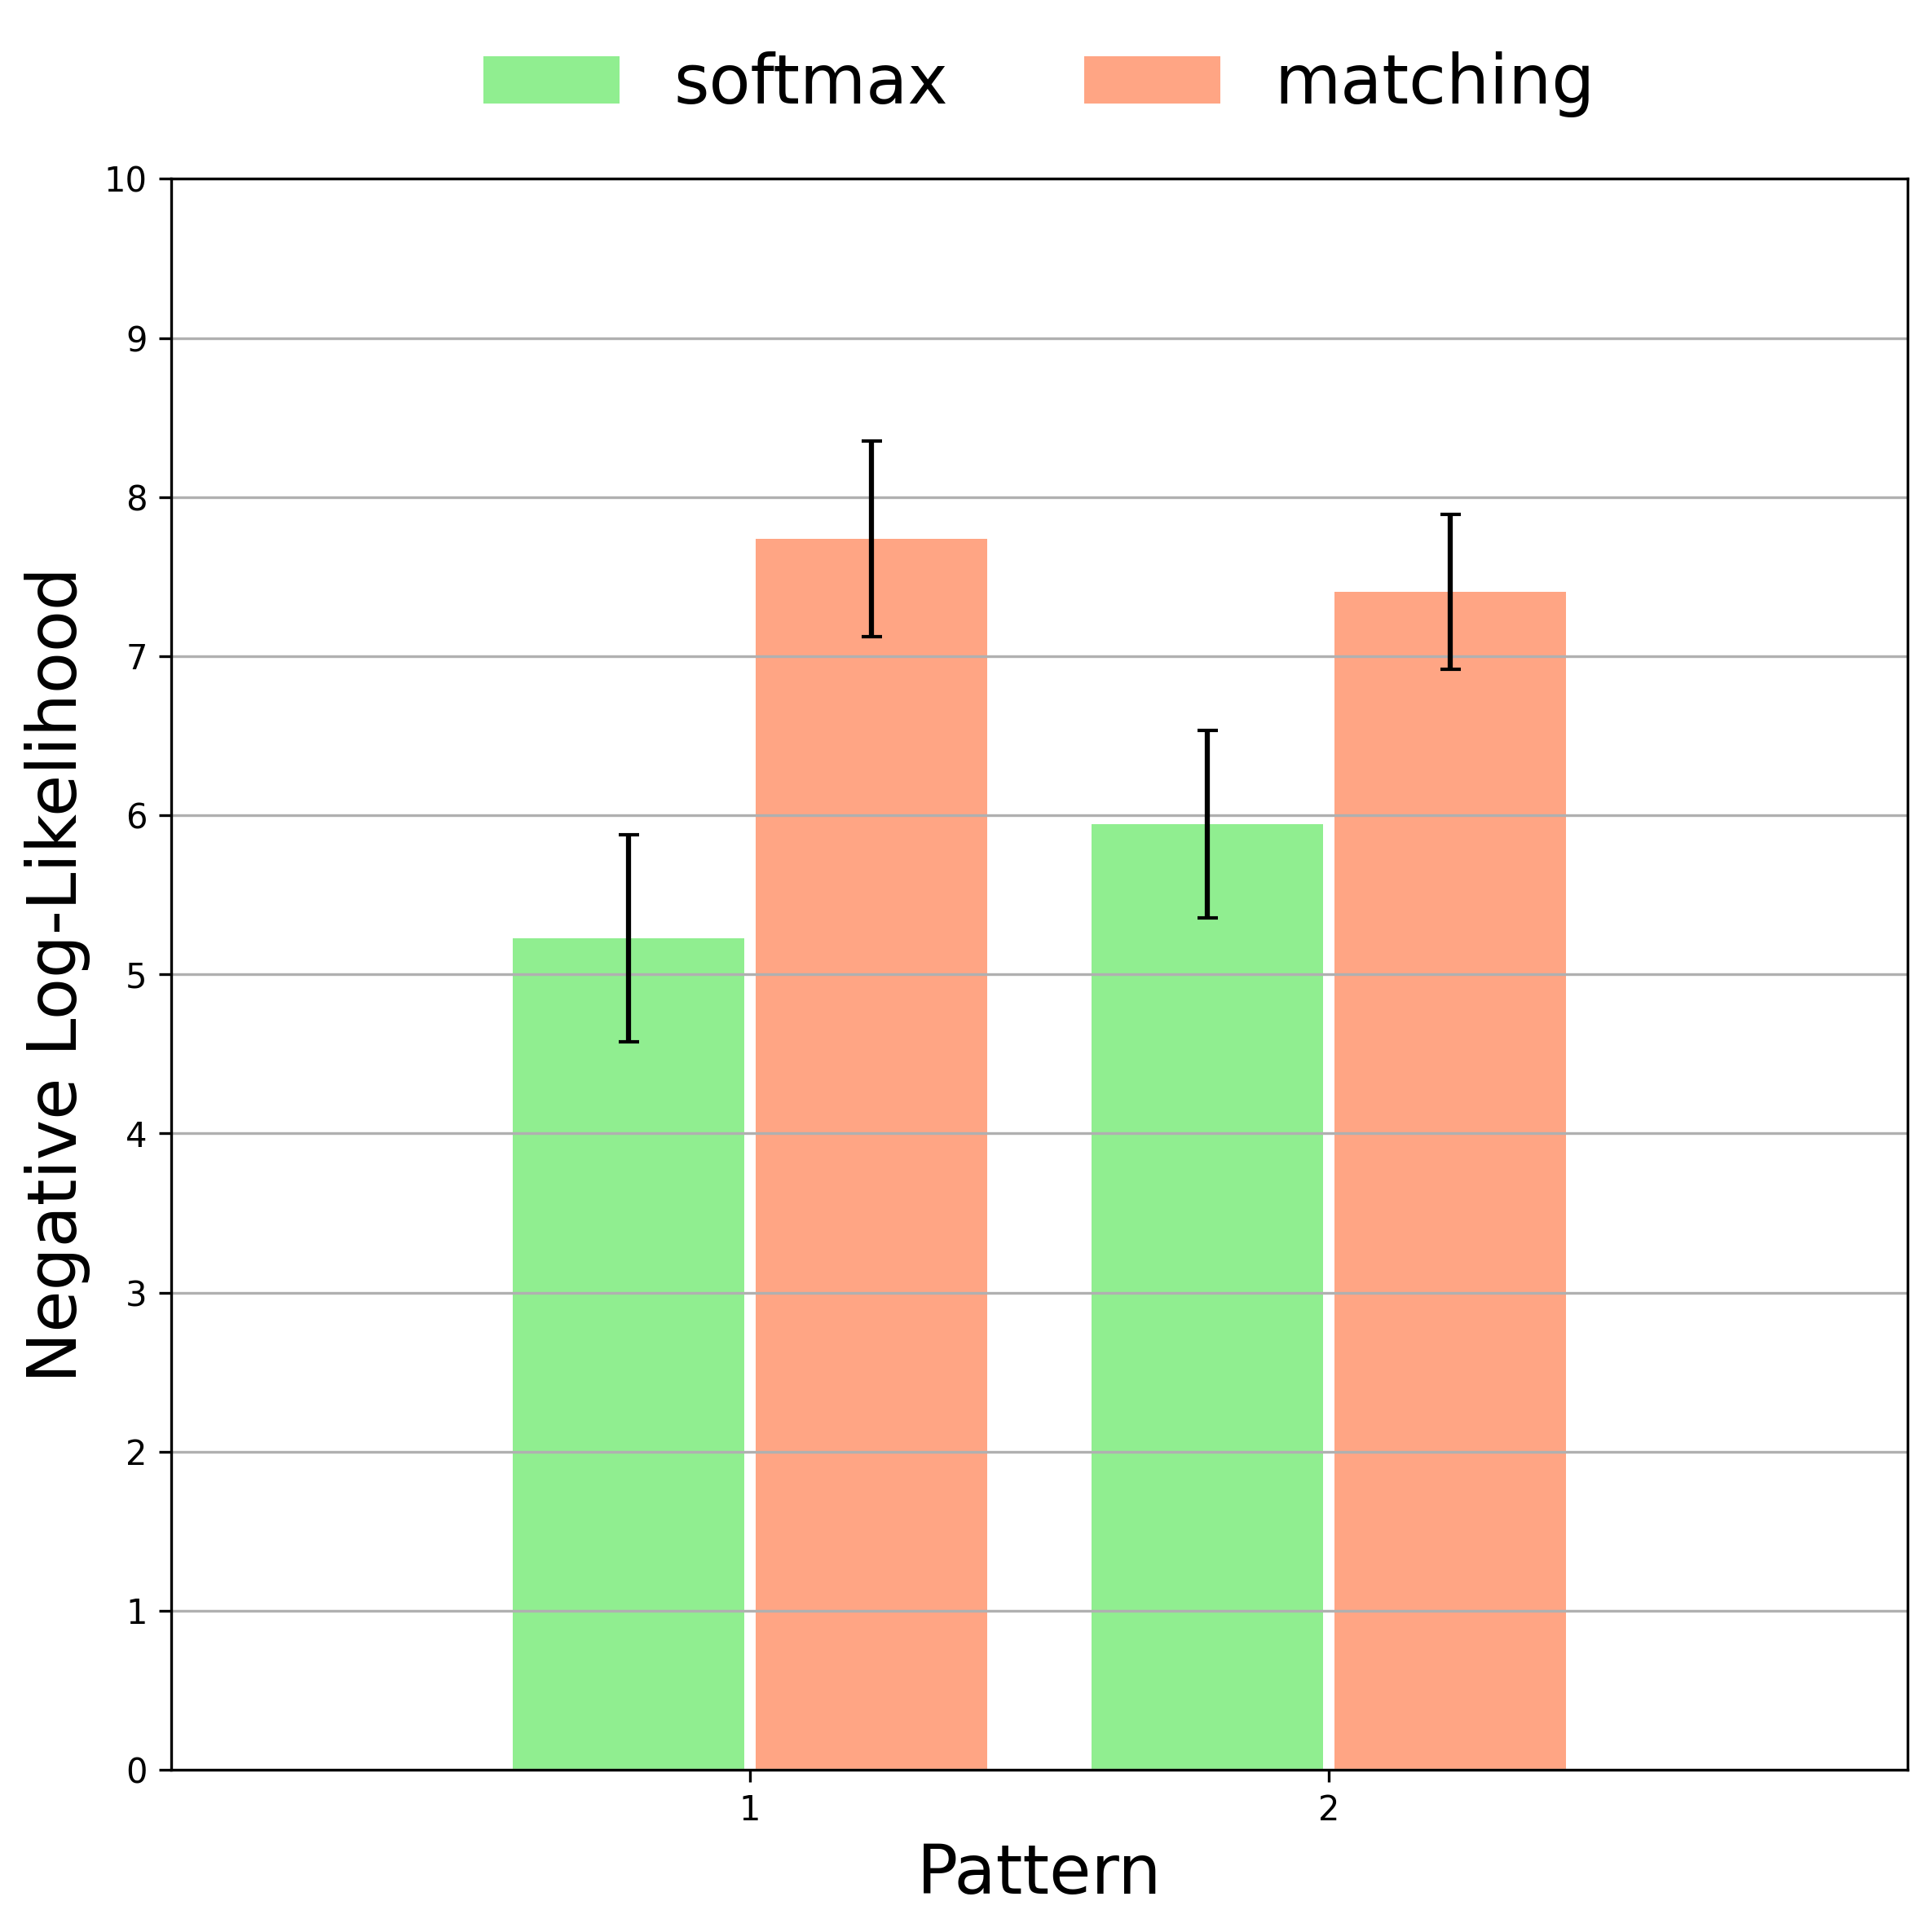

between patterns : Wilcoxon less
pattern1, softmax-matching : 6.103515625e-05
pattern2, softmax-matching : 0.001312255859375


In [ ]:
df_ss = pd.read_excel('result_ss.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood(df_ss, ax, 'll_softmax',  -gap, 'softmax',  width, ymax, 'lightgreen', 1)
negative_likelihood(df_ss, ax, 'll_matching',  gap, 'matching', width, ymax, 'coral',      0.7)

ax.grid(axis='y')
plt.show()

print('between patterns : Wilcoxon less')
pvalue1 = stats.wilcoxon(-(df_ss[df_ss['pattern']==1]['ll_softmax']), -(df_ss[df_ss['pattern']==1]['ll_matching']), alternative='less').pvalue
pvalue2 = stats.wilcoxon(-(df_ss[df_ss['pattern']==2]['ll_softmax']), -(df_ss[df_ss['pattern']==2]['ll_matching']), alternative='less').pvalue
print(f'pattern1, softmax-matching : {pvalue1}')
print(f'pattern2, softmax-matching : {pvalue2}')

# Inverse Reinforcement Learning (IRL)

### Comarison of Negative Log-likelihood

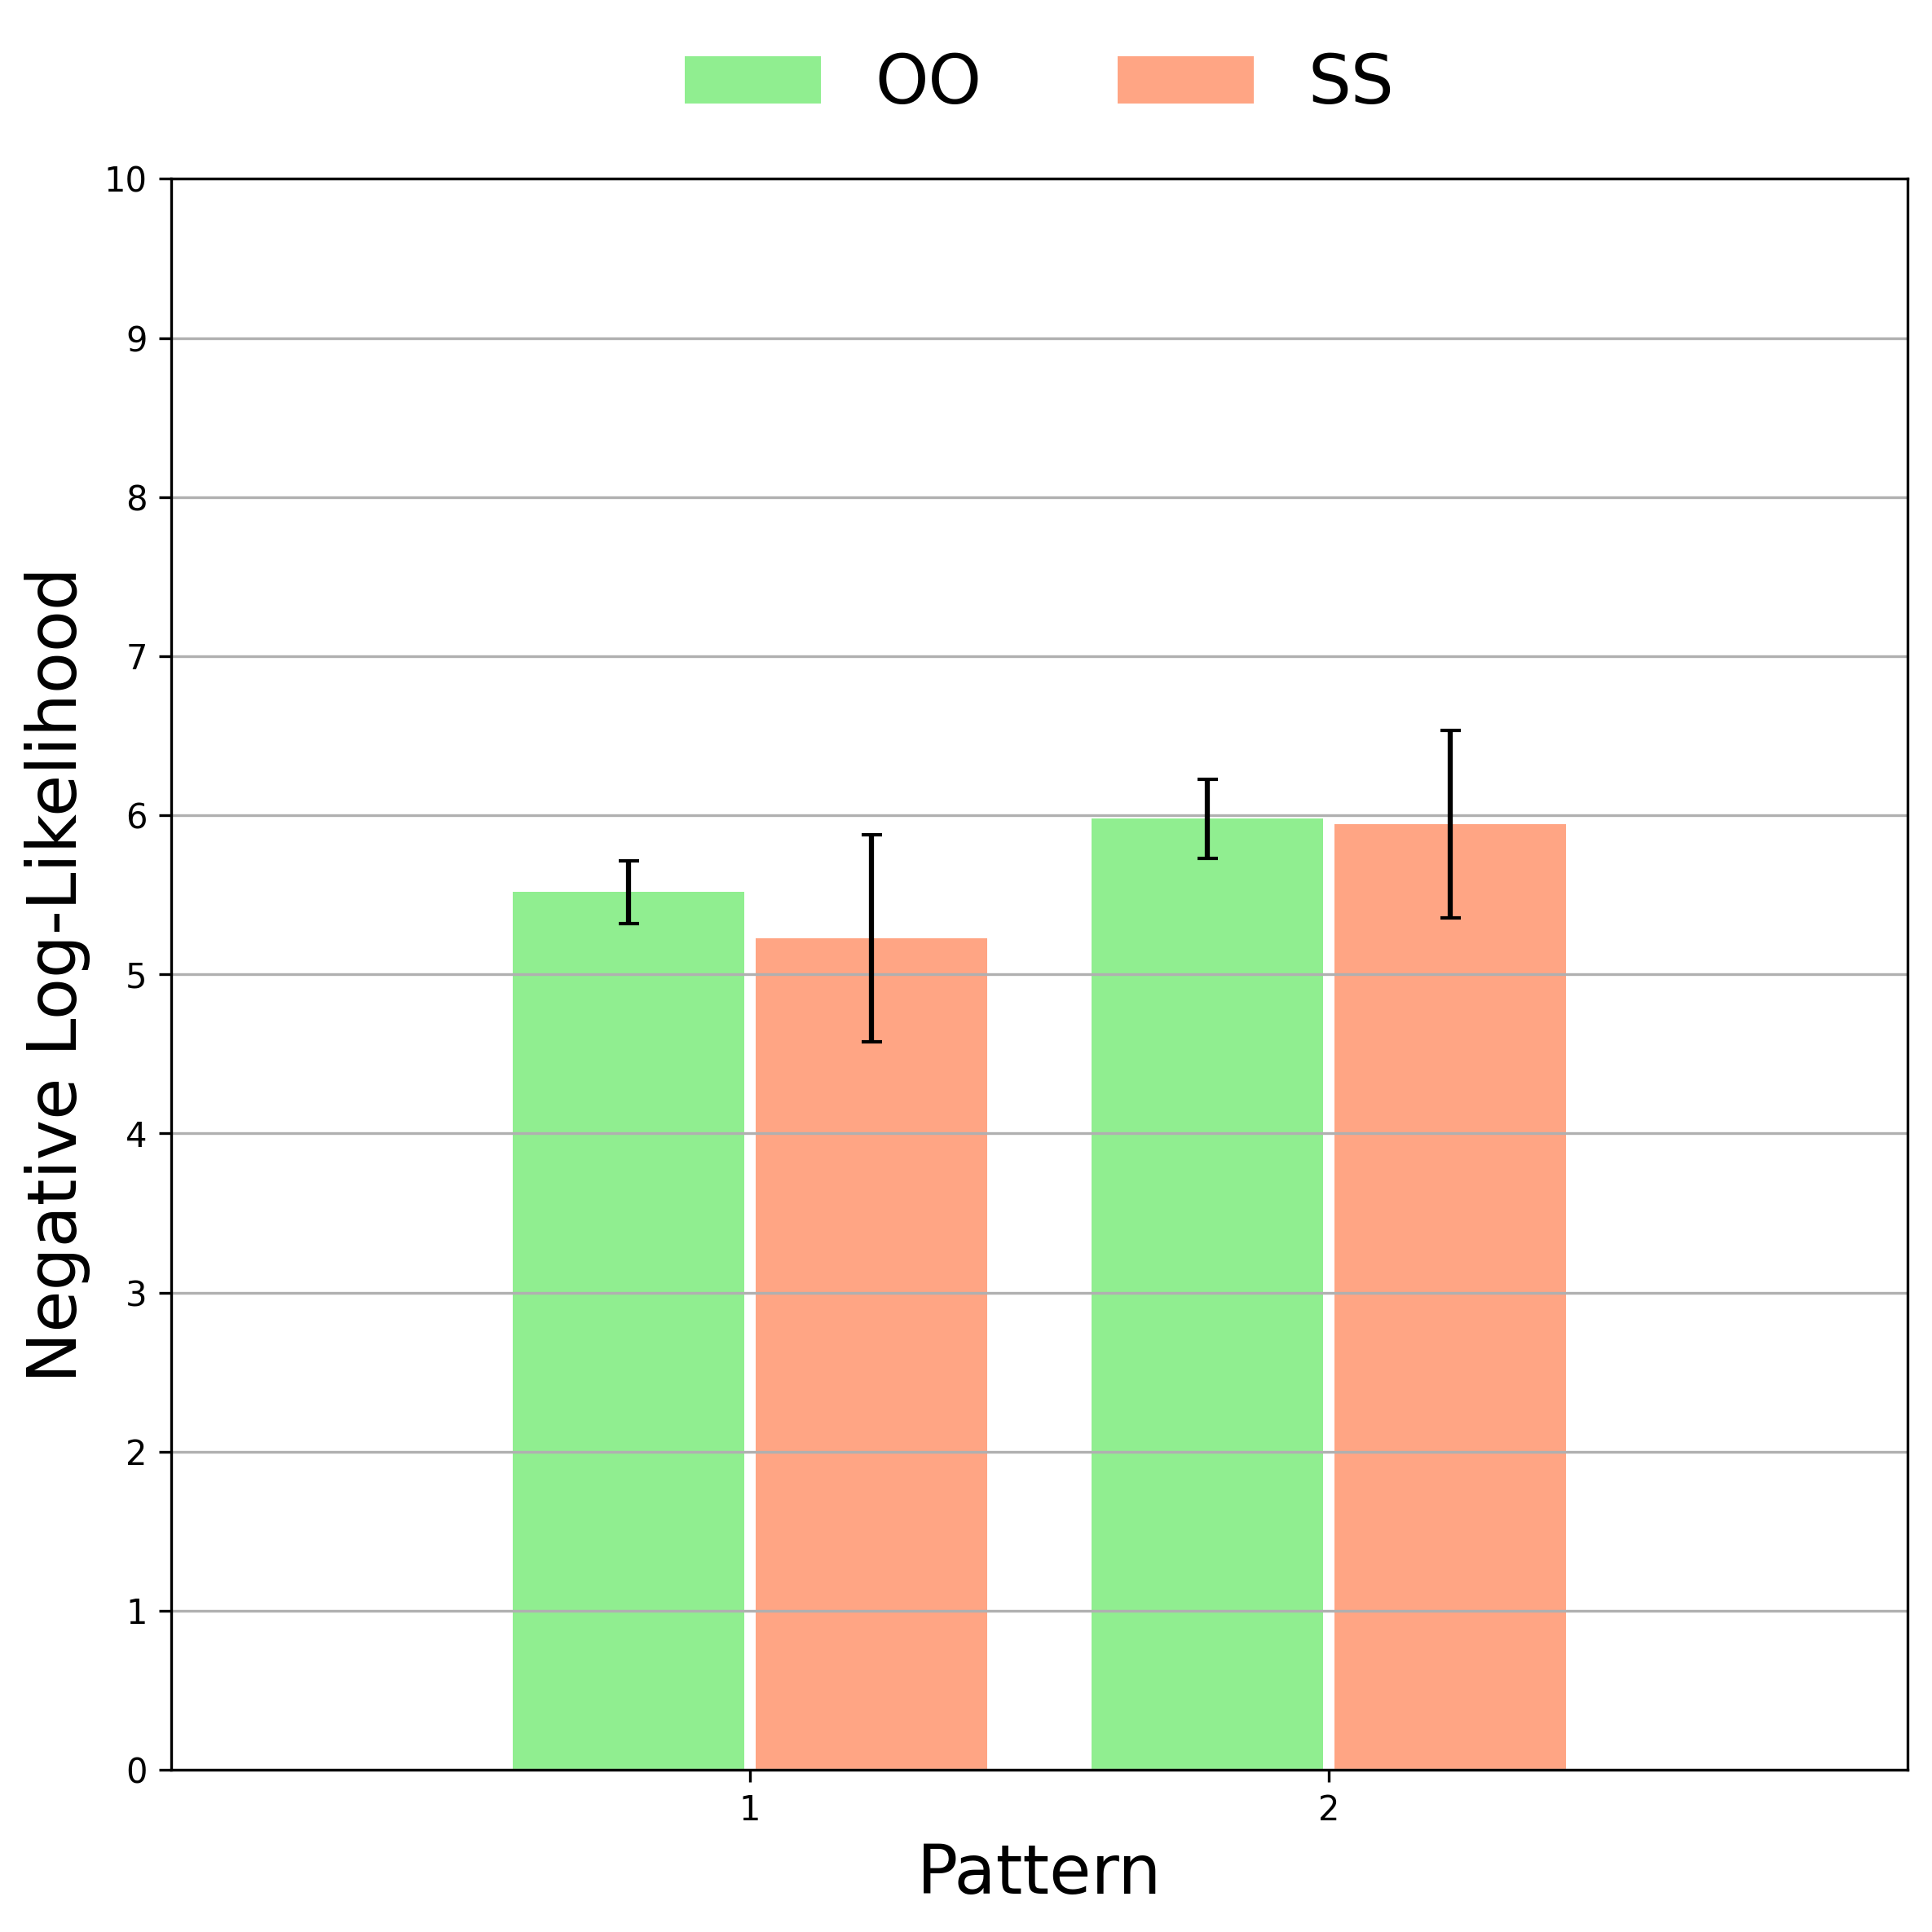

between conditions, oo-ss : Wilcoxon two-sided
pattern1, oo-ss : 0.42120361328125
pattern2, oo-ss : 0.93408203125


In [ ]:
# pd.set_option('display.max_rows', None)
df_oo = pd.read_excel('result_oo.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood(df_oo, ax, 'll_softmax', -gap, 'OO', width, ymax, 'lightgreen', 1)
negative_likelihood(df_ss, ax, 'll_softmax',  gap, 'SS', width, ymax,      'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between conditions, oo-ss : Wilcoxon two-sided')
pvalue1 = stats.wilcoxon(-(df_oo[df_oo['pattern']==1]['ll_softmax']), -(df_ss[df_ss['pattern']==1]['ll_softmax']), alternative='two-sided').pvalue
pvalue2 = stats.wilcoxon(-(df_oo[df_oo['pattern']==2]['ll_softmax']), -(df_ss[df_ss['pattern']==2]['ll_softmax']), alternative='two-sided').pvalue
print(f'pattern1, oo-ss : {pvalue1}')
print(f'pattern2, oo-ss : {pvalue2}')

# Integration of learning

### Comarison of Negative Log-likelihood

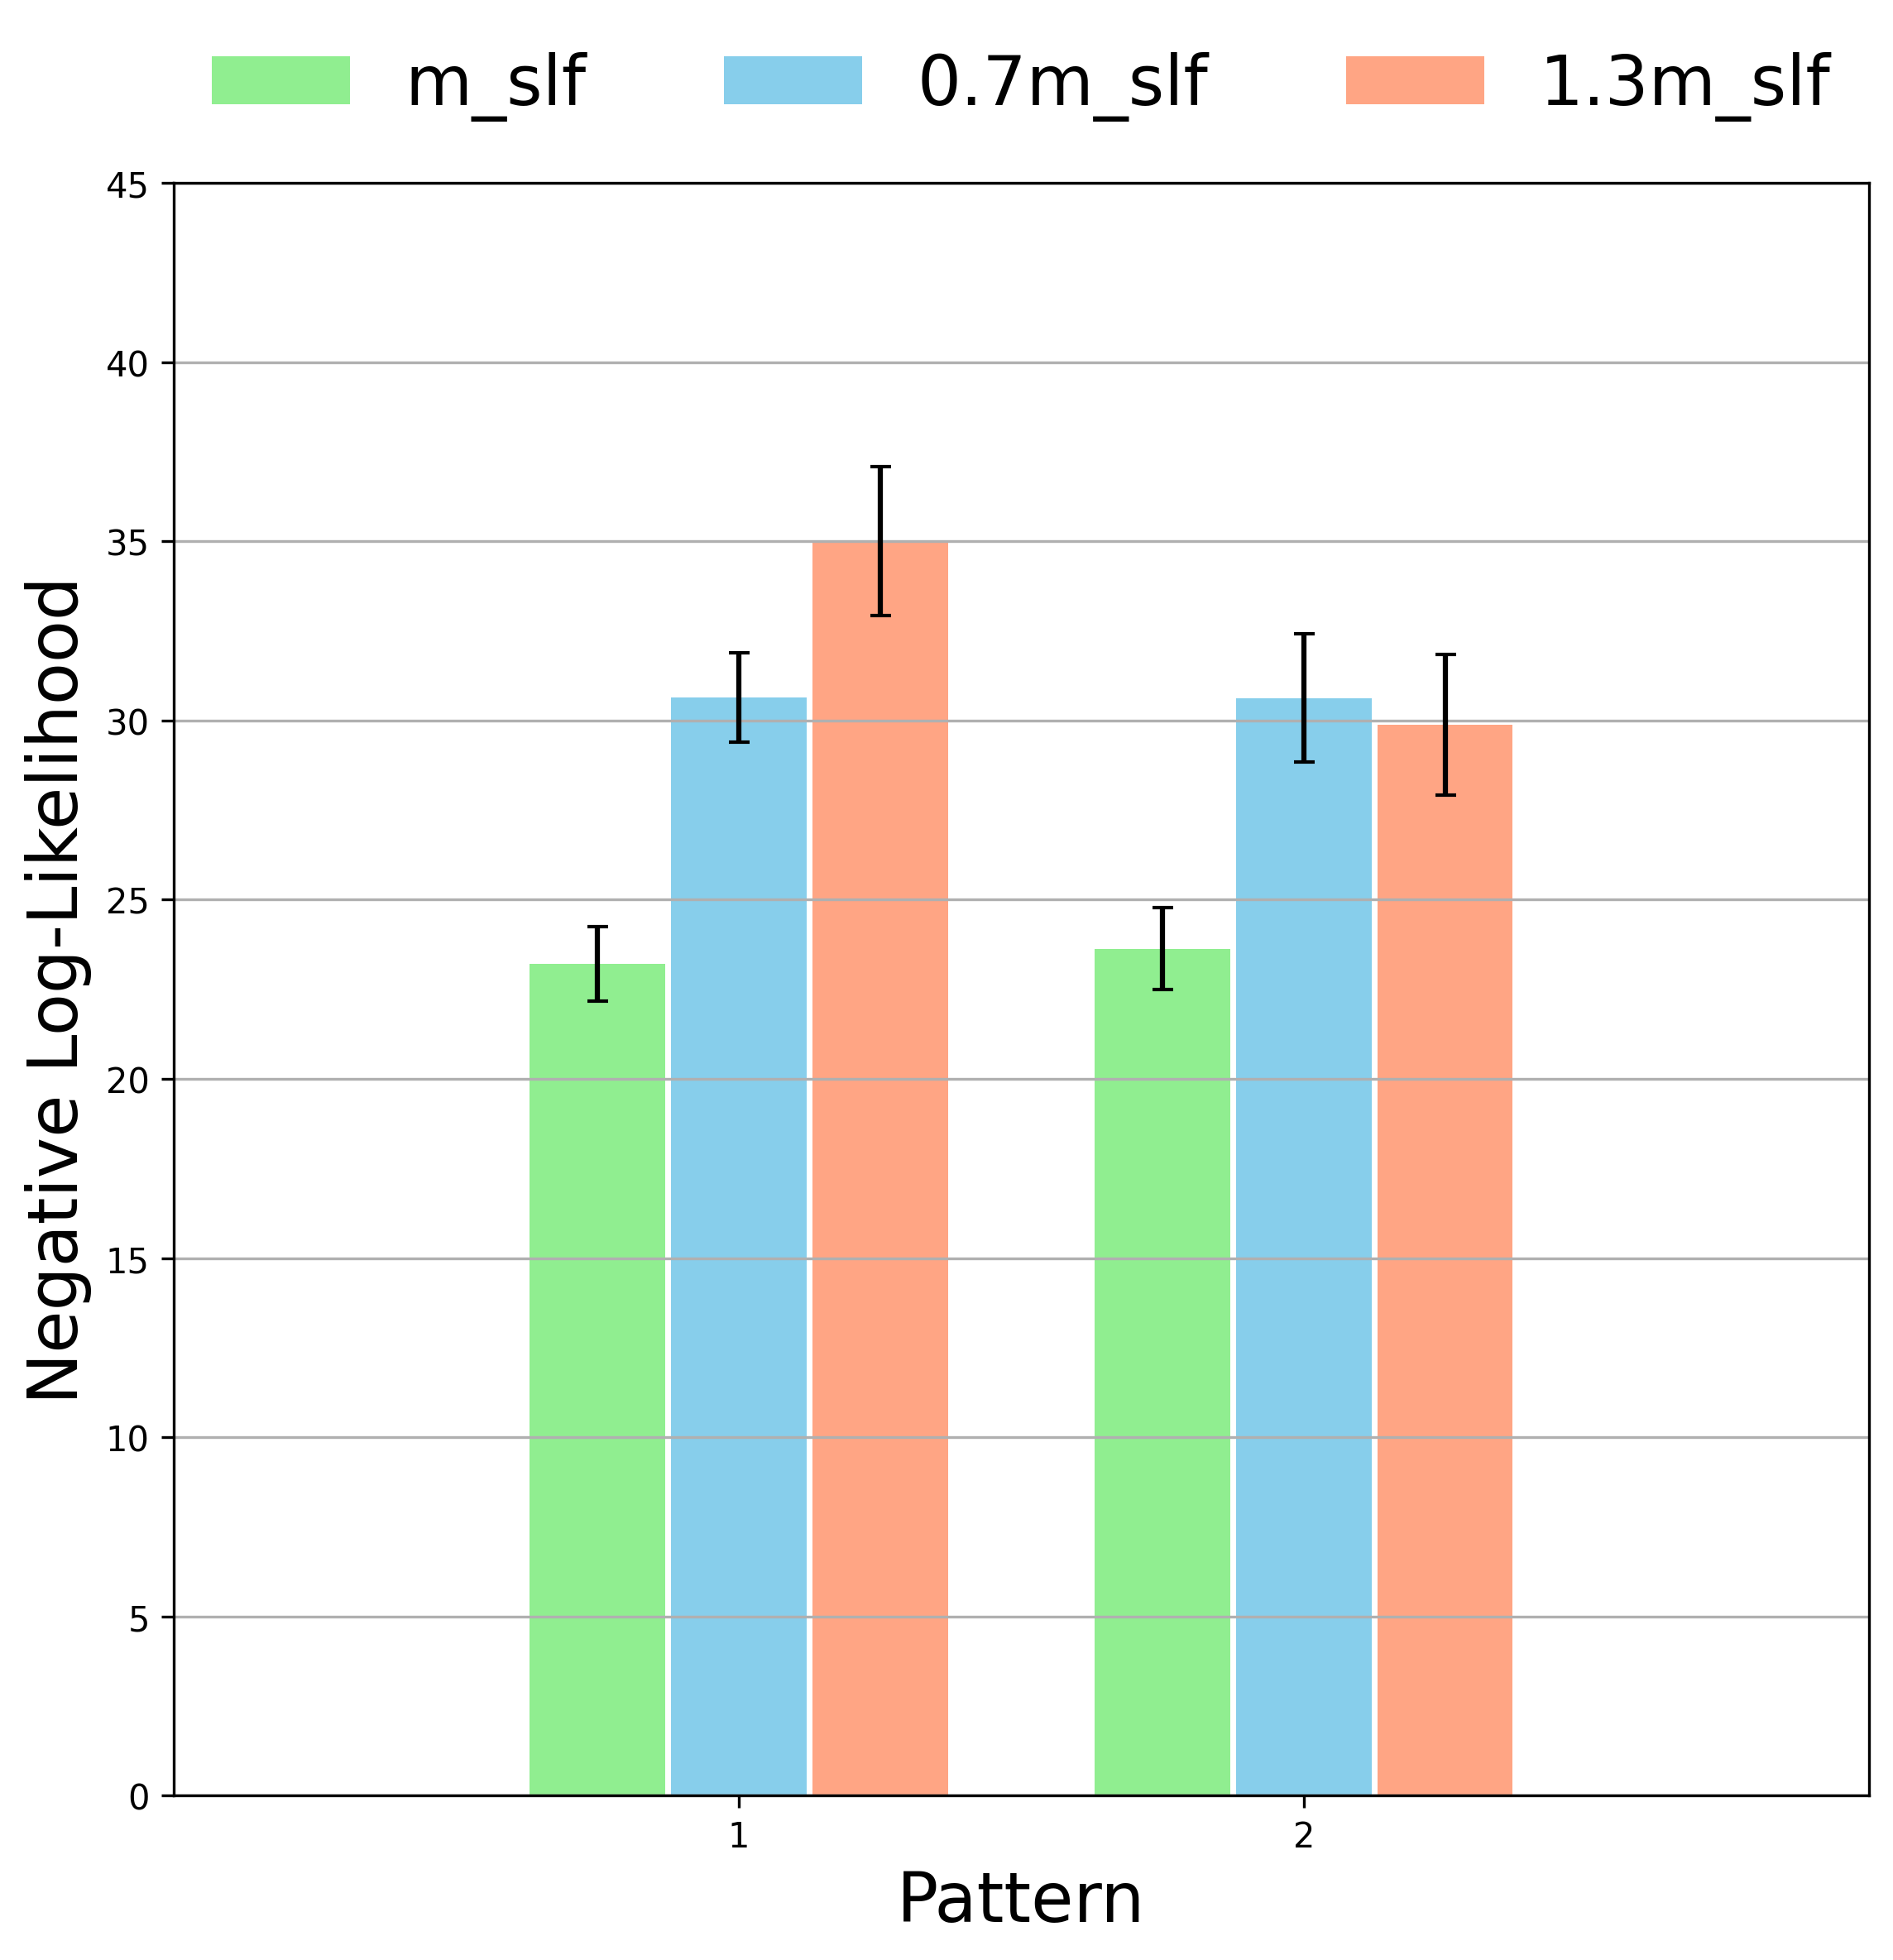

between initials, so : Wilcoxon less
pattern1, 1.0-0.7 : 0.000579833984375
pattern2, 1.0-0.7 : 0.00030517578125
pattern1, 1.0-1.3 : 6.103515625e-05
pattern2, 1.0-1.3 : 3.0517578125e-05


In [ ]:
df_so_10 = pd.read_excel('result_so m=1.0.xlsx')
df_so_07 = pd.read_excel('result_so m=0.7.xlsx')
df_so_13 = pd.read_excel('result_so m=1.3.xlsx')

width = .24
gap = width+.01
transparency = .7
ymax = 45
ytick = 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood_so(df_so_10, ax, 'll_softmax', -gap,    'm_slf', width, ymax, ytick, 'lightgreen', 1)
negative_likelihood_so(df_so_07, ax, 'll_softmax',    0, '0.7m_slf', width, ymax, ytick, 'skyblue', 1)
negative_likelihood_so(df_so_13, ax, 'll_softmax',  gap, '1.3m_slf', width, ymax, ytick, 'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between initials, so : Wilcoxon less')
pvalue1_1007 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==1]['ll_softmax']), -(df_so_07[df_so_07['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2_1007 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==2]['ll_softmax']), -(df_so_07[df_so_07['pattern']==2]['ll_softmax']), alternative='less').pvalue
pvalue1_1013 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==1]['ll_softmax']), -(df_so_13[df_so_13['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2_1013 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==2]['ll_softmax']), -(df_so_13[df_so_13['pattern']==2]['ll_softmax']), alternative='less').pvalue

print(f'pattern1, 1.0-0.7 : {pvalue1_1007}')
print(f'pattern2, 1.0-0.7 : {pvalue2_1007}')
print(f'pattern1, 1.0-1.3 : {pvalue1_1013}')
print(f'pattern2, 1.0-1.3 : {pvalue2_1013}')

# Confidece Evaluation

### Comarison of Negative Log-likelihood

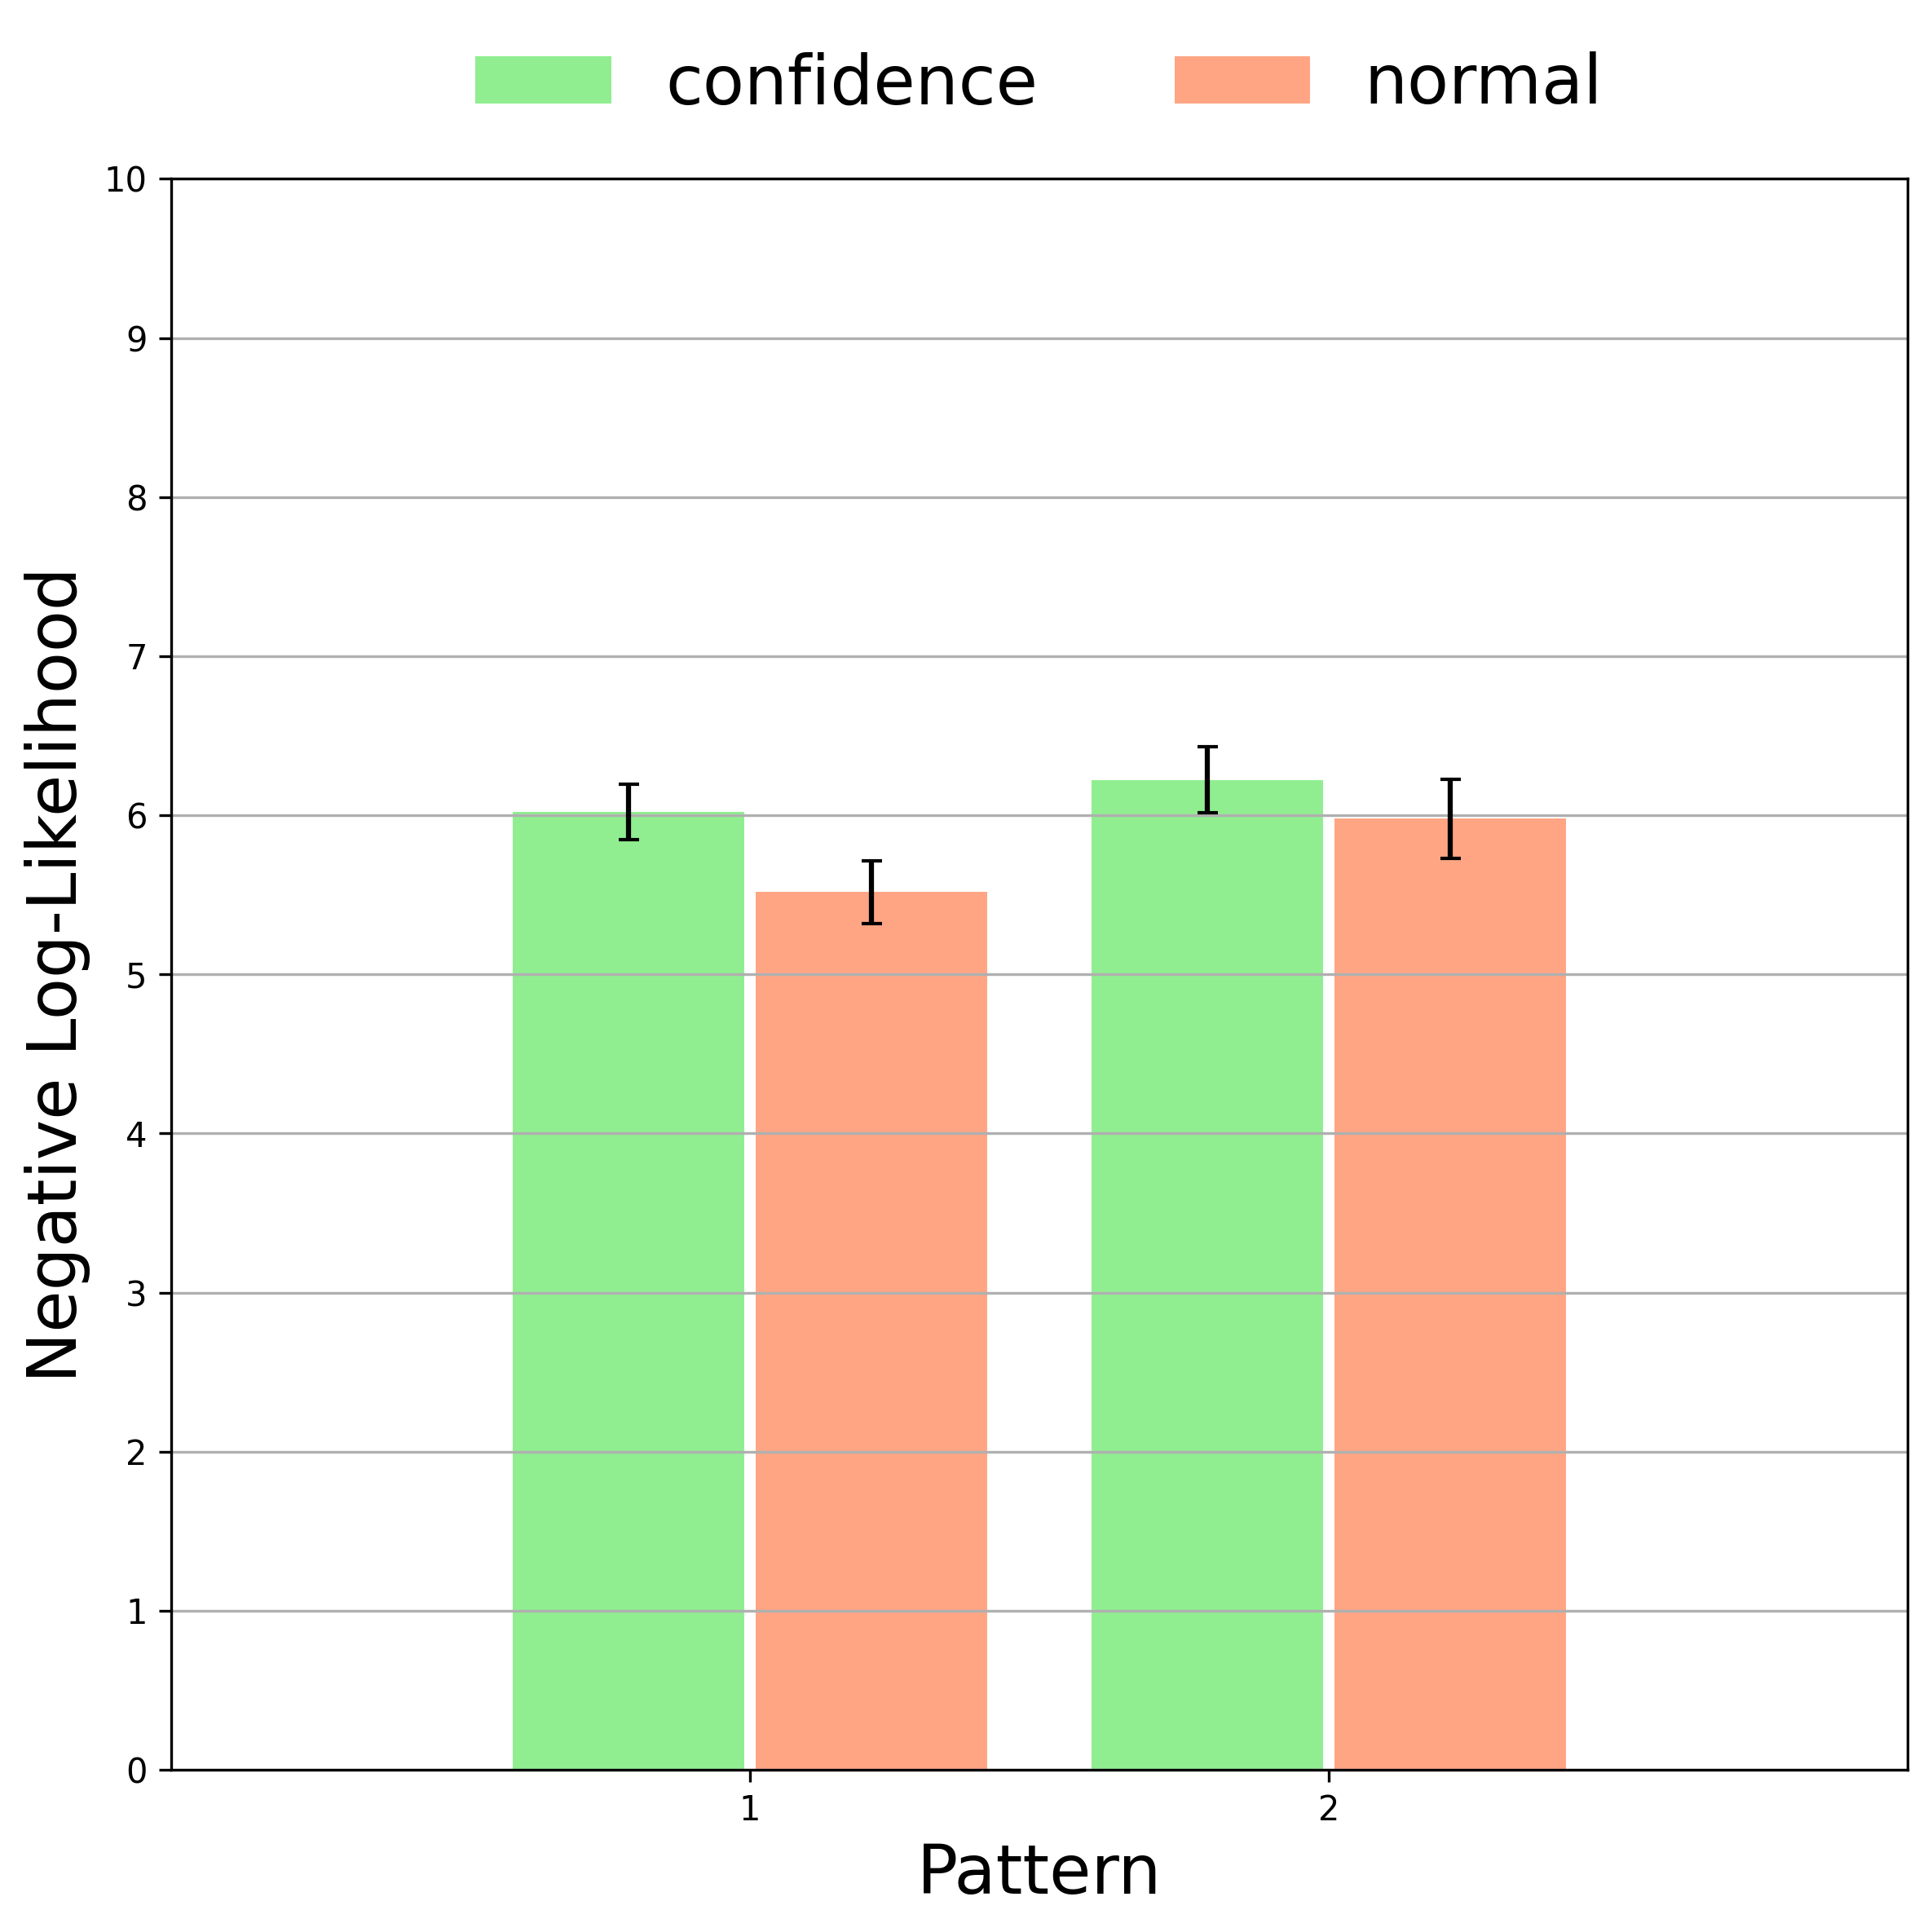

between patterns, oo : Wilcoxon less
pattern1, conf-normal : 1.0
pattern2, conf-normal : 0.999237060546875


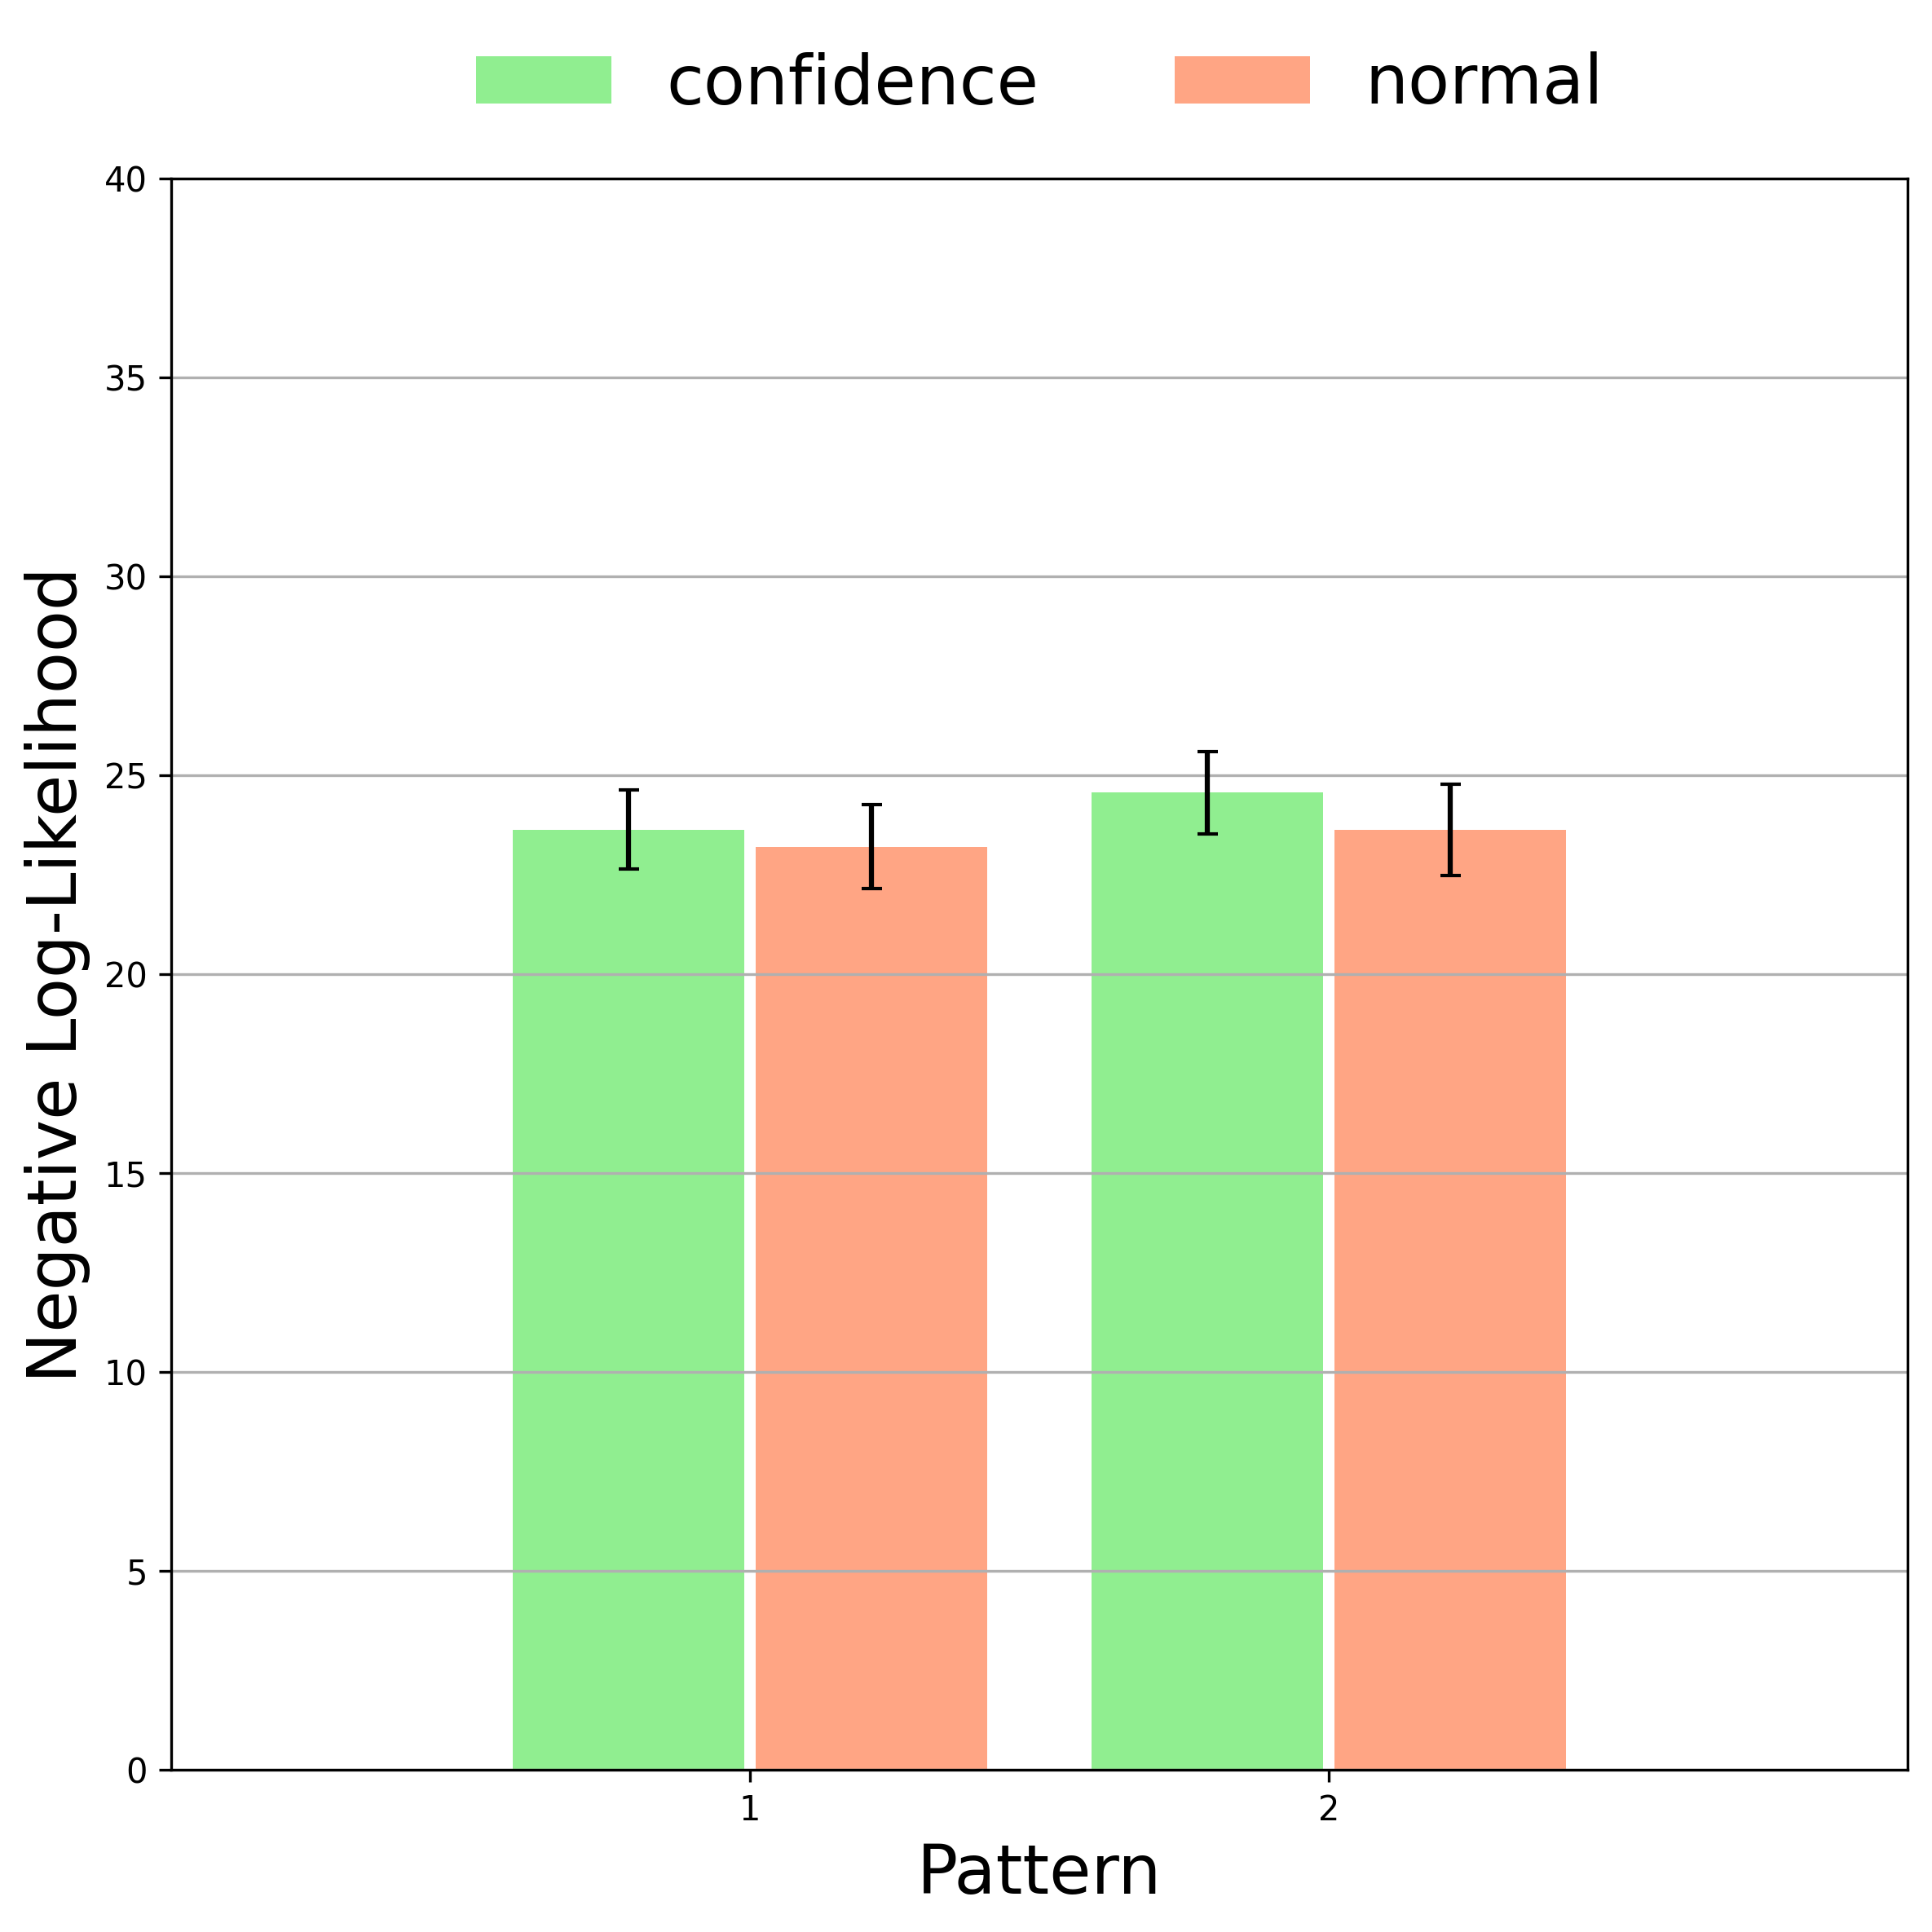

between patterns, so : Wilcoxon less
pattern1, conf-normal : 0.982330322265625
pattern2, conf-normal : 0.999969482421875


In [ ]:
df_oo_conf = pd.read_excel('result_oo_conf.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood(df_oo_conf, ax, 'll_softmax', -gap, 'confidence', width, ymax, 'lightgreen', 1)
negative_likelihood(     df_oo, ax, 'll_softmax',  gap, 'normal', width, ymax, 'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between patterns, oo : Wilcoxon less')
pvalue1 = stats.wilcoxon(-(df_oo_conf[df_oo_conf['pattern']==1]['ll_softmax']), -(df_oo[df_oo['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2 = stats.wilcoxon(-(df_oo_conf[df_oo_conf['pattern']==2]['ll_softmax']), -(df_oo[df_oo['pattern']==2]['ll_softmax']), alternative='less').pvalue
print(f'pattern1, conf-normal : {pvalue1}')
print(f'pattern2, conf-normal : {pvalue2}')


df_so_conf = pd.read_excel('result_so_conf.xlsx')
df_so      = pd.read_excel('result_so m=1.0.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 40
ytick = 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood_so(df_so_conf, ax, 'll_softmax', -gap, 'confidence', width, ymax, ytick, 'lightgreen', 1)
negative_likelihood_so(     df_so, ax, 'll_softmax',  gap, 'normal', width, ymax, ytick,      'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between patterns, so : Wilcoxon less')
pvalue1 = stats.wilcoxon(-(df_so_conf[df_so_conf['pattern']==1]['ll_softmax']), -(df_so[df_so['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2 = stats.wilcoxon(-(df_so_conf[df_so_conf['pattern']==2]['ll_softmax']), -(df_so[df_so['pattern']==2]['ll_softmax']), alternative='less').pvalue
print(f'pattern1, conf-normal : {pvalue1}')
print(f'pattern2, conf-normal : {pvalue2}')

In [ ]:
def value_diff(df, ax):
    capsize = 3
    diff_1112 = df[df['pattern']==1]['q_12']-df[df['pattern']==1]['q_11']
    diff_1123 = df[df['pattern']==1]['q_13']-df[df['pattern']==1]['q_12']
    diff_1212 = df[df['pattern']==1]['q_22']-df[df['pattern']==1]['q_21']
    diff_1223 = df[df['pattern']==1]['q_23']-df[df['pattern']==1]['q_22']
    diff_1312 = df[df['pattern']==1]['q_32']-df[df['pattern']==1]['q_31']
    diff_1323 = df[df['pattern']==1]['q_33']-df[df['pattern']==1]['q_32']
    diff_2112 = df[df['pattern']==2]['q_12']-df[df['pattern']==2]['q_11']
    diff_2123 = df[df['pattern']==2]['q_13']-df[df['pattern']==2]['q_12']
    diff_2212 = df[df['pattern']==2]['q_22']-df[df['pattern']==2]['q_21']
    diff_2223 = df[df['pattern']==2]['q_23']-df[df['pattern']==2]['q_22']
    diff_2312 = df[df['pattern']==2]['q_32']-df[df['pattern']==2]['q_31']
    diff_2323 = df[df['pattern']==2]['q_33']-df[df['pattern']==2]['q_32']

    ax.scatter(diff_1112, diff_1123, label='p1_b1', color='b', marker='o')
    ax.scatter(diff_1212, diff_1223, label='p1_b2', color='b', marker='x')
    ax.scatter(diff_1312, diff_1323, label='p1_b3', color='b', marker='^')
    ax.scatter(diff_2112, diff_1223, label='p2_b1', color='r', marker='o')
    ax.scatter(diff_2212, diff_2223, label='p2_b2', color='r', marker='x')
    ax.scatter(diff_2312, diff_2323, label='p2_b3', color='r', marker='^')

    ax.set_xlim(-10, 50)
    ax.set_ylim(-20, 30)
    ax.set_xticks(np.arange(-10, 50, step=5))
    ax.set_yticks(np.arange(-20, 30, step=5))
    ax.set_xlabel('diff_12', fontsize=18)
    ax.set_ylabel('diff_23', fontsize=18)
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=10)
    # ax.set_title(T_title_label[i], x=.5, y=1.15, fontsize=20)

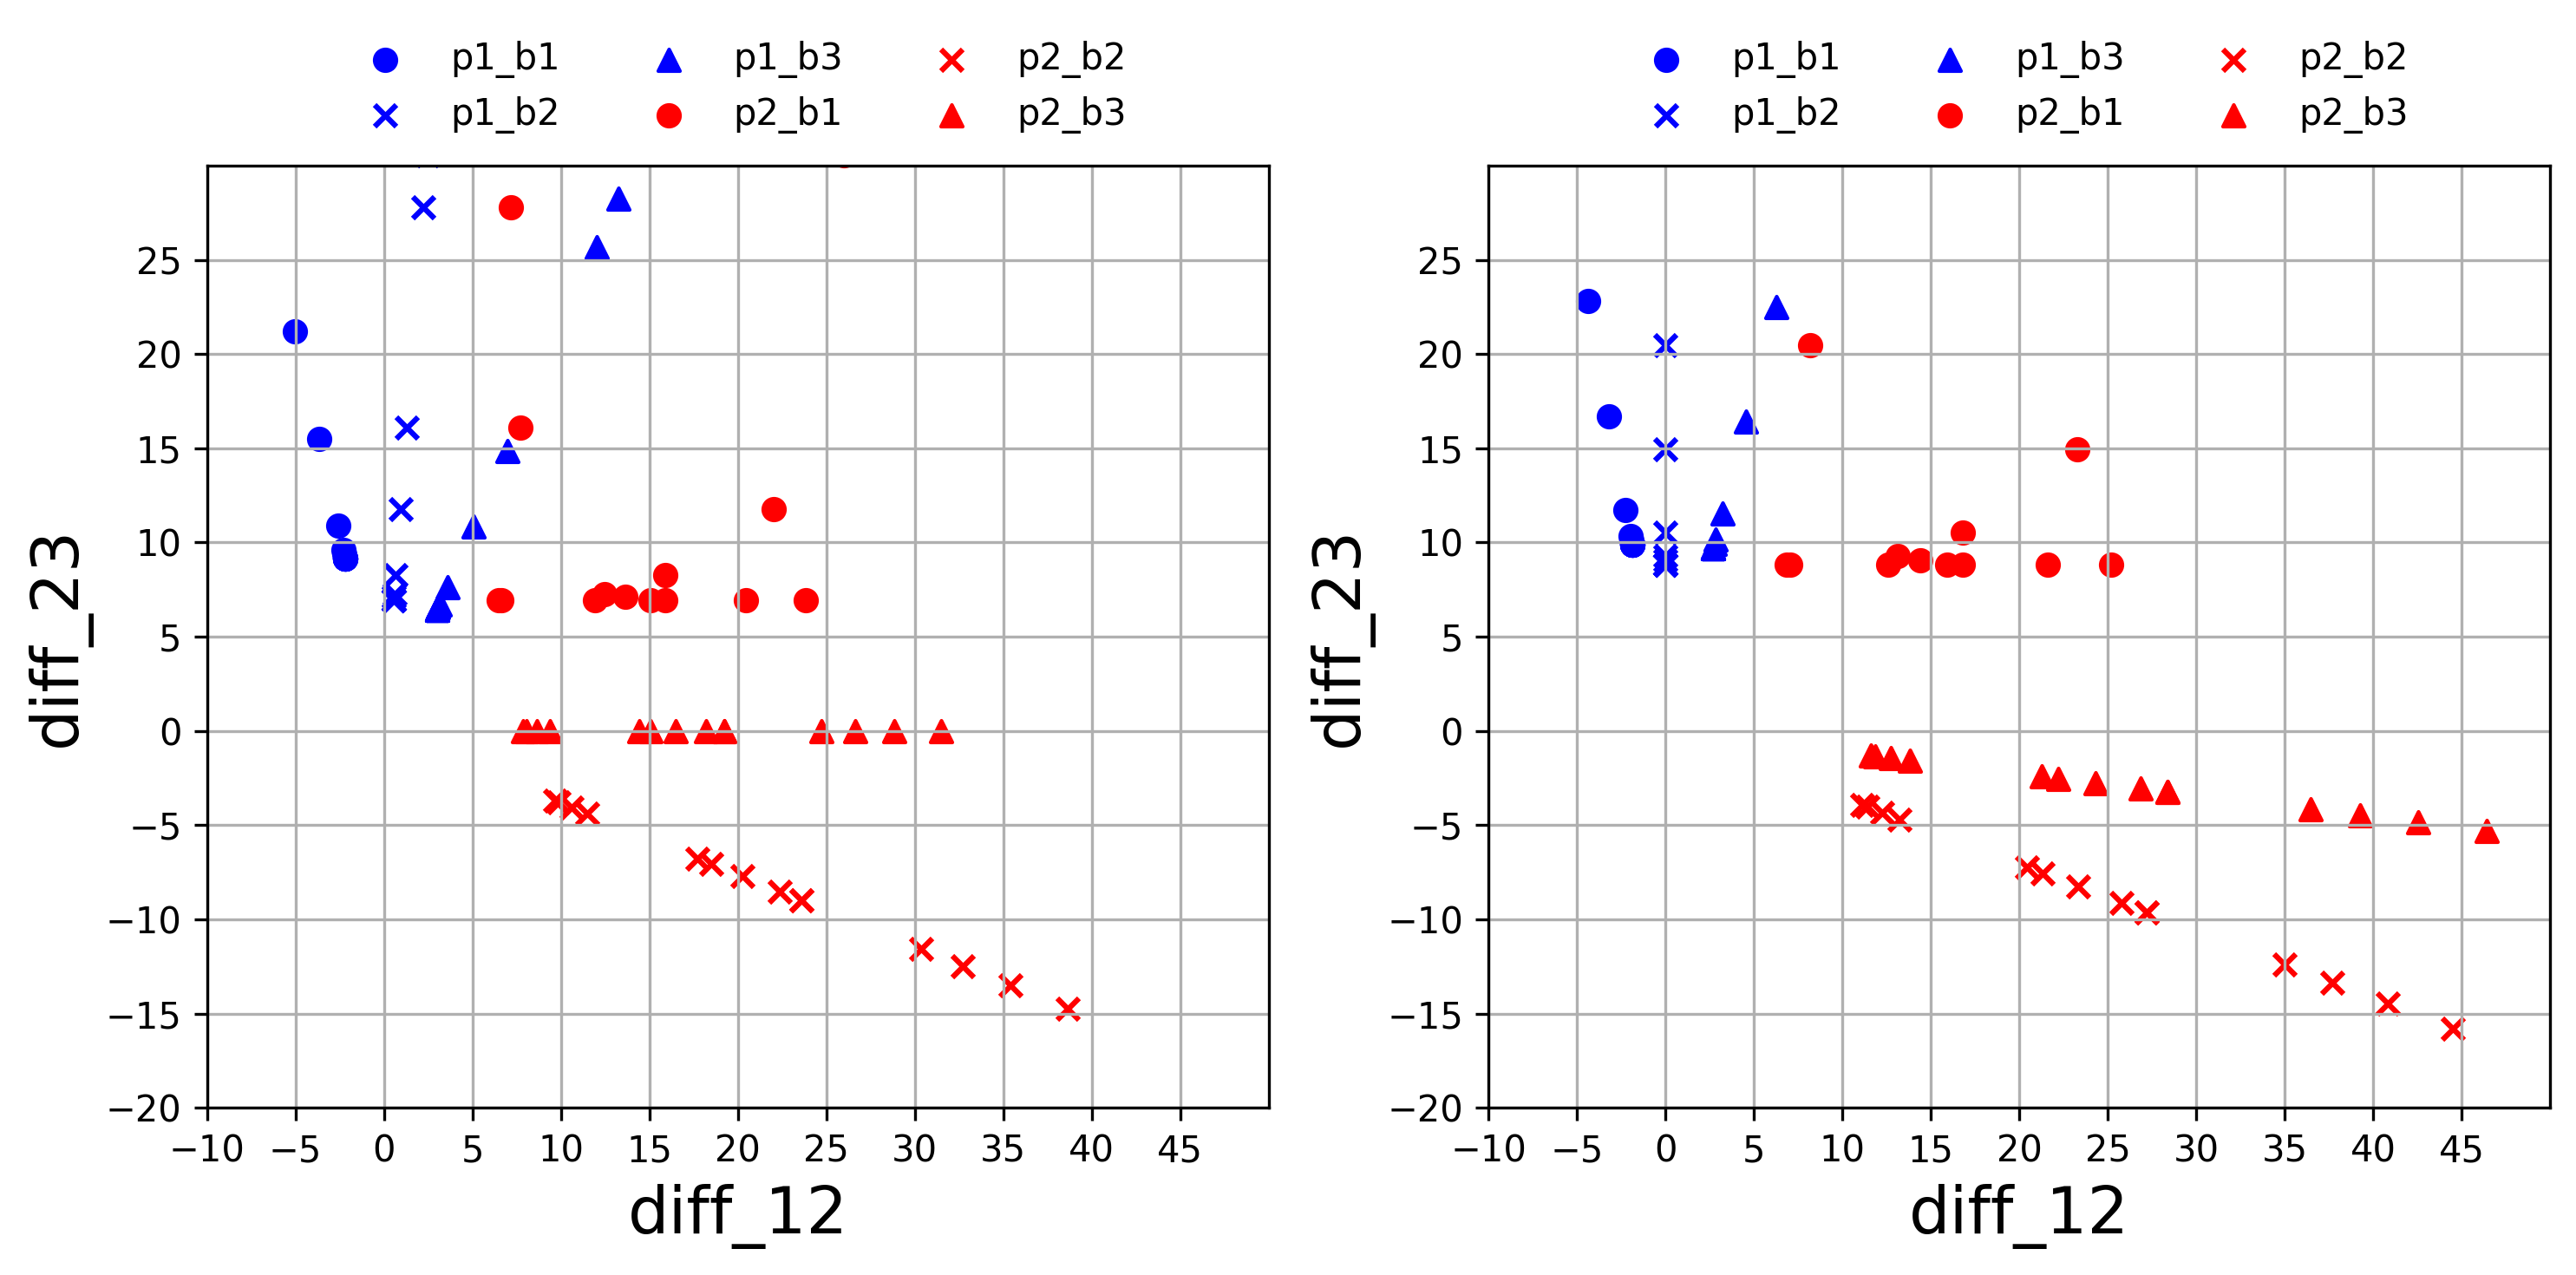

In [ ]:
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300, tight_layout=True)
value_diff(df_oo_conf, ax[0])
value_diff(     df_oo, ax[1])

ax[0].grid()
ax[1].grid()
plt.show()

In [ ]:
def diff_accuracy(df):
    for si in range(subj_num):
        df = df[(df['subj']==si+1) & (df['subj']==si+1) & (df['subj']==si+1)]


In [ ]:
dft1 = integrated_data_0[0][2]
dft1 = dft1[dft1['loc_pattern']>=4]
dft2 = integrated_data_0[1][2]
dft2 = dft2[dft2['loc_pattern']>=4]

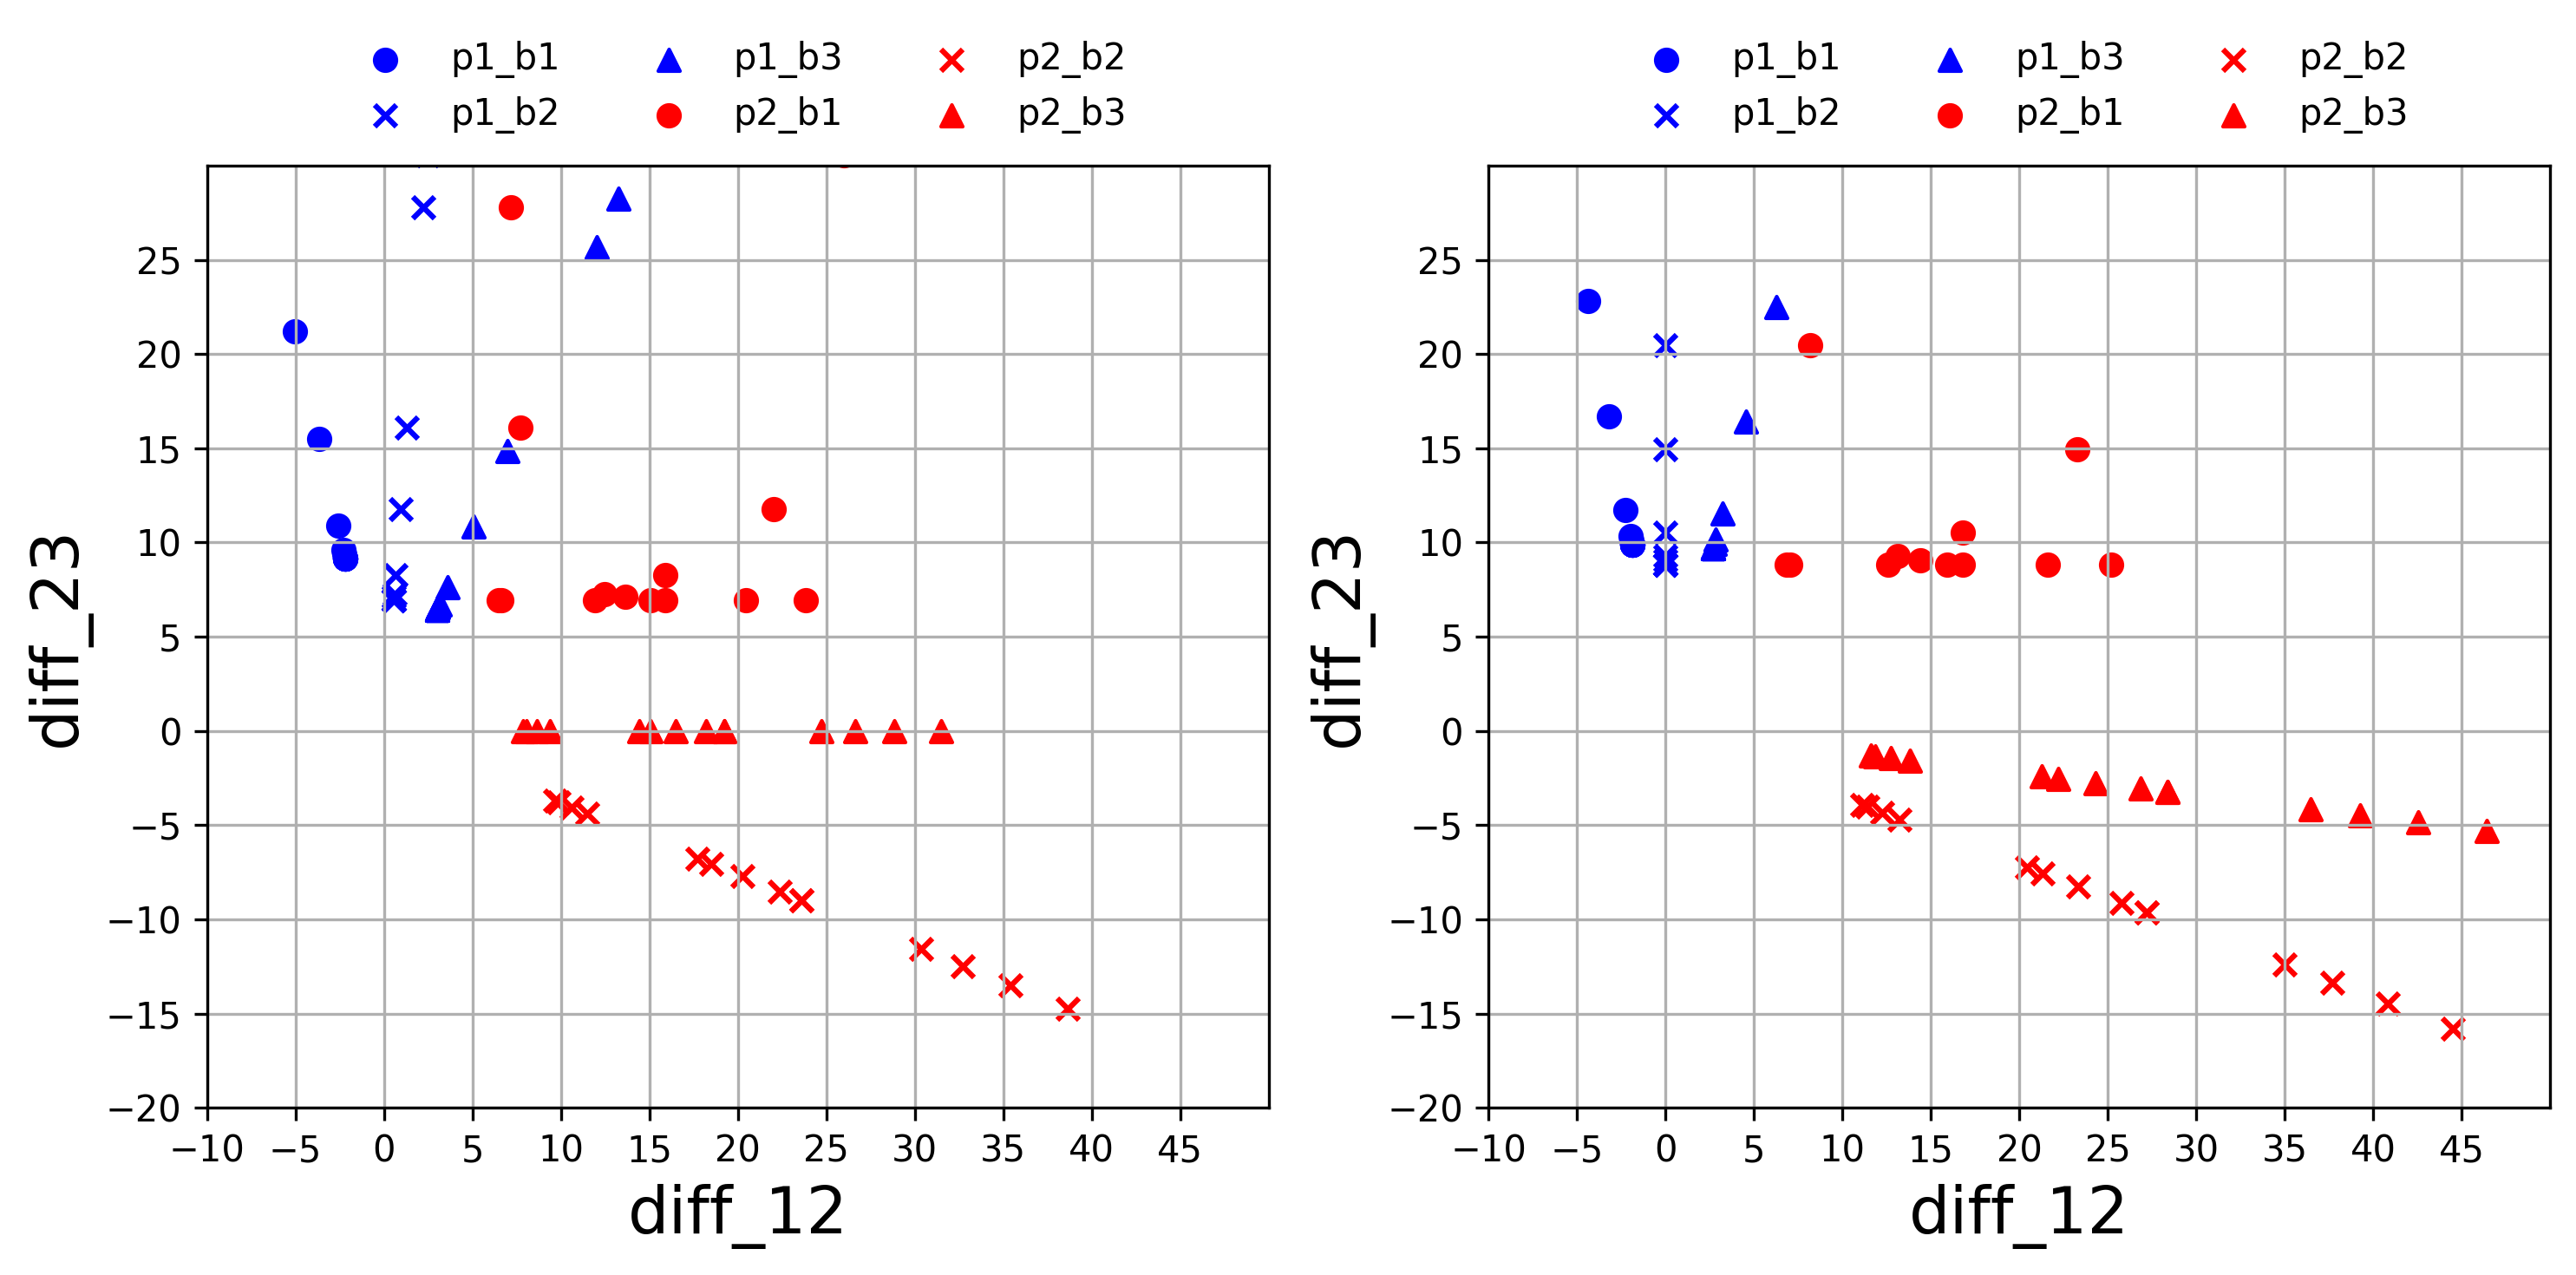

In [ ]:


width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300, tight_layout=True)
value_diff(df_oo_conf, ax[0])
value_diff(     df_oo, ax[1])

ax[0].grid()
ax[1].grid()
plt.show()
